In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
class my_Dataset(Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, data_paths,  num_arrival_moms=5, num_ser_moms = 5):
        self.data_paths = data_paths
        self.num_arrival_moms = num_arrival_moms
        self.num_ser_moms = num_ser_moms
        
    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        x, y = pkl.load(open(self.data_paths[index] , 'rb'))
        

        x1 = x[:, :self.num_arrival_moms]
        x2 = x[:,10: 10+self.num_ser_moms]
        x3 = x[:,20:20 +self.num_ser_moms ]
        x = np.concatenate((x1,x2,x3), axis = 1)
        
        x = torch.from_numpy(x)
        y = torch.from_numpy(y[:,:])

        return x, y
    
    


In [22]:
path = r'C:\Users\Eshel\workspace\data\mom_mathcher_data\github_data\gg2_hetro'
file_list = os.listdir(path)
data_paths = [os.path.join(path, name) for name in file_list]
len(data_paths)

3

In [23]:
num_arrival_moms, num_ser_moms = 4, 4

In [24]:
dataset = my_Dataset(data_paths,  num_arrival_moms, num_ser_moms)
batch_size = 1
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

# get first sample and unpack
first_data = dataset[0]
features, labels = first_data
print(features.shape, labels.shape)

torch.Size([128, 12]) torch.Size([128, 500])


In [25]:
import torch
import torch.nn as nn
class Net(nn.Module):

    def __init__(self, input_size, output_size):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_size , 50)
        self.fc2 = nn.Linear(50, 70)
        self.fc3 = nn.Linear(70, 200)
        self.fc4 = nn.Linear(200, 350)
        self.fc5 = nn.Linear(350, 600) # changed from 600
        self.fc6 = nn.Linear(600, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x  


In [26]:
m = nn.Softmax(dim=1)
input_size = features.shape[1]
output_size = labels.shape[1]
input_size = 12
output_size = 500
net = Net(input_size, output_size).to(device)
net.load_state_dict(torch.load( './models/mom_anal_hetro_num_moms_4_layer_6.pkl'))

C:\Users\Eshel\AppData\Local\Temp\ipykernel_26408\2614620926.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load( './models/mom_anal_hetro_num

<All keys matched successfully>

In [27]:
output = m(net(features.to(device).float()))

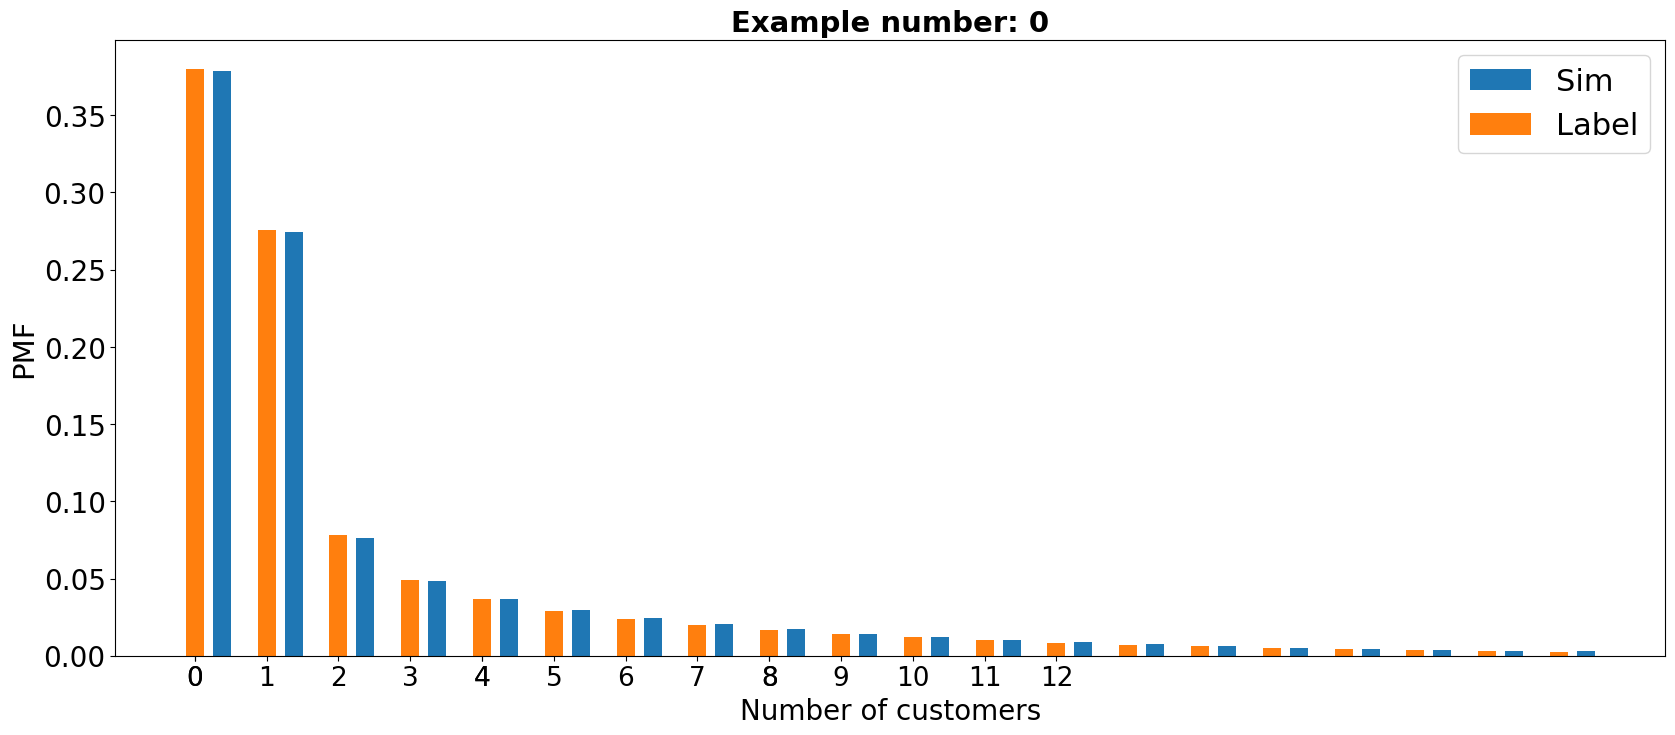

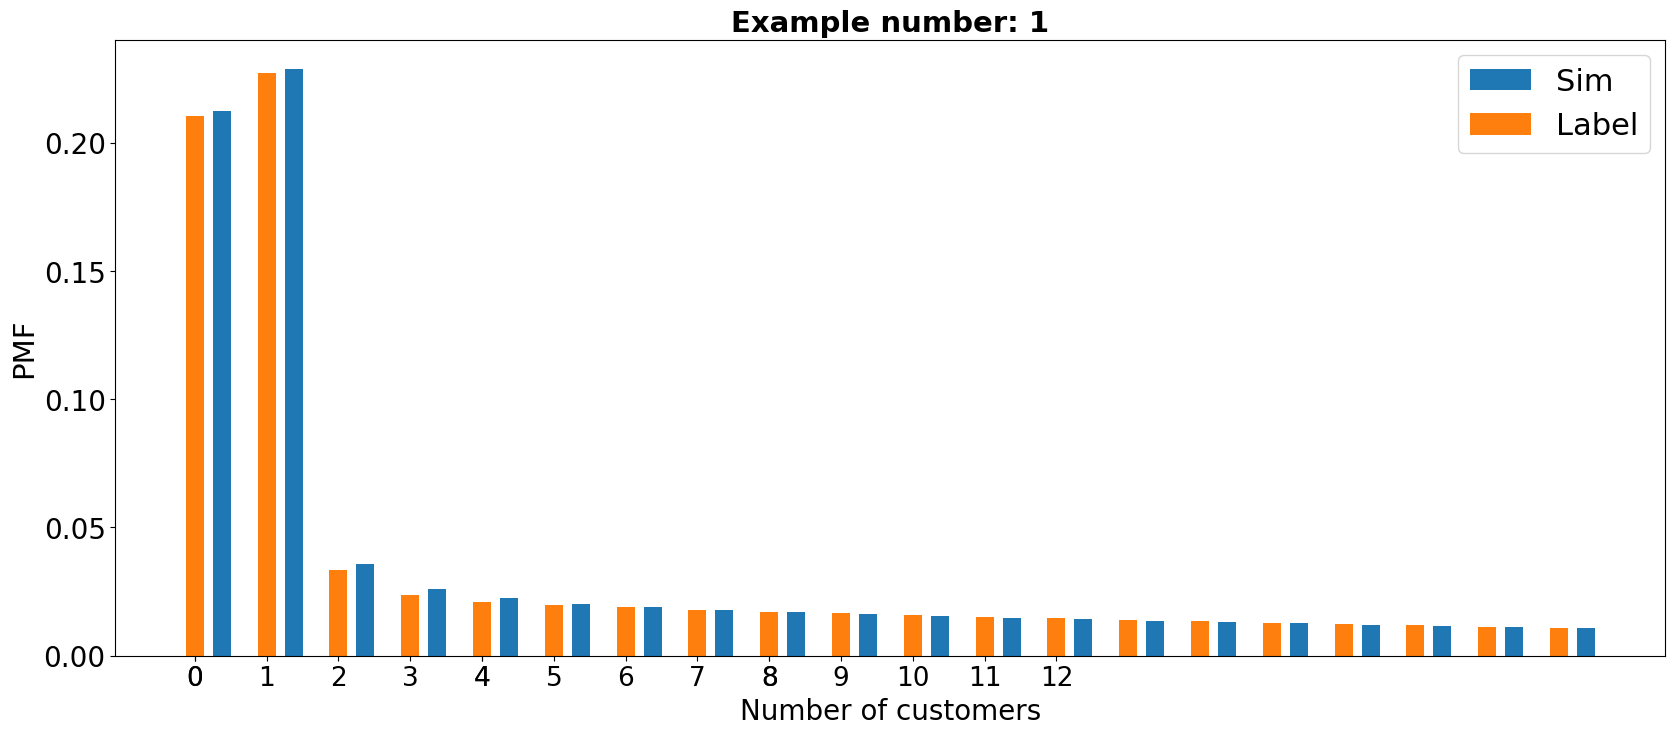

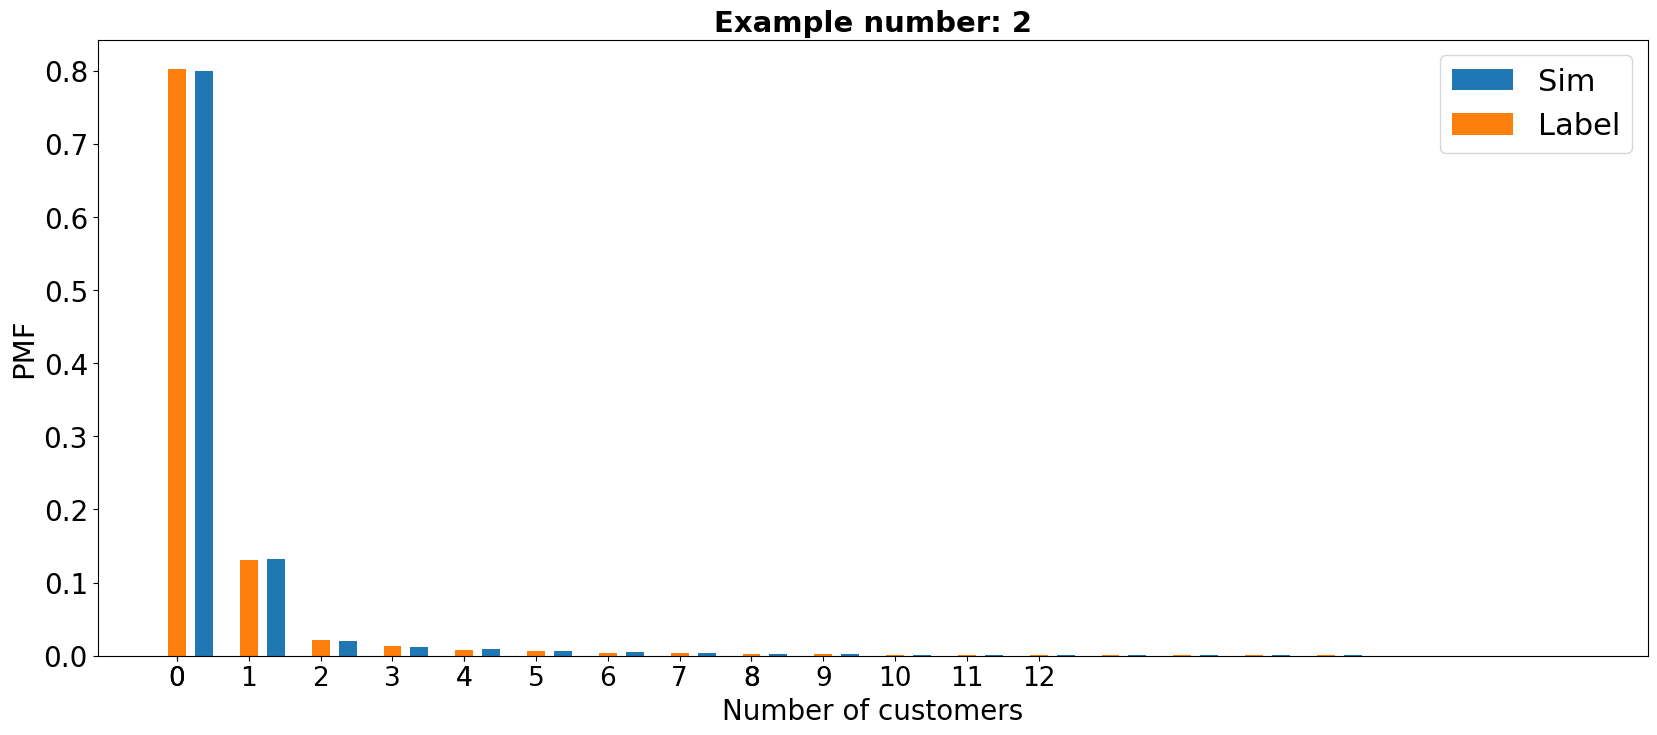

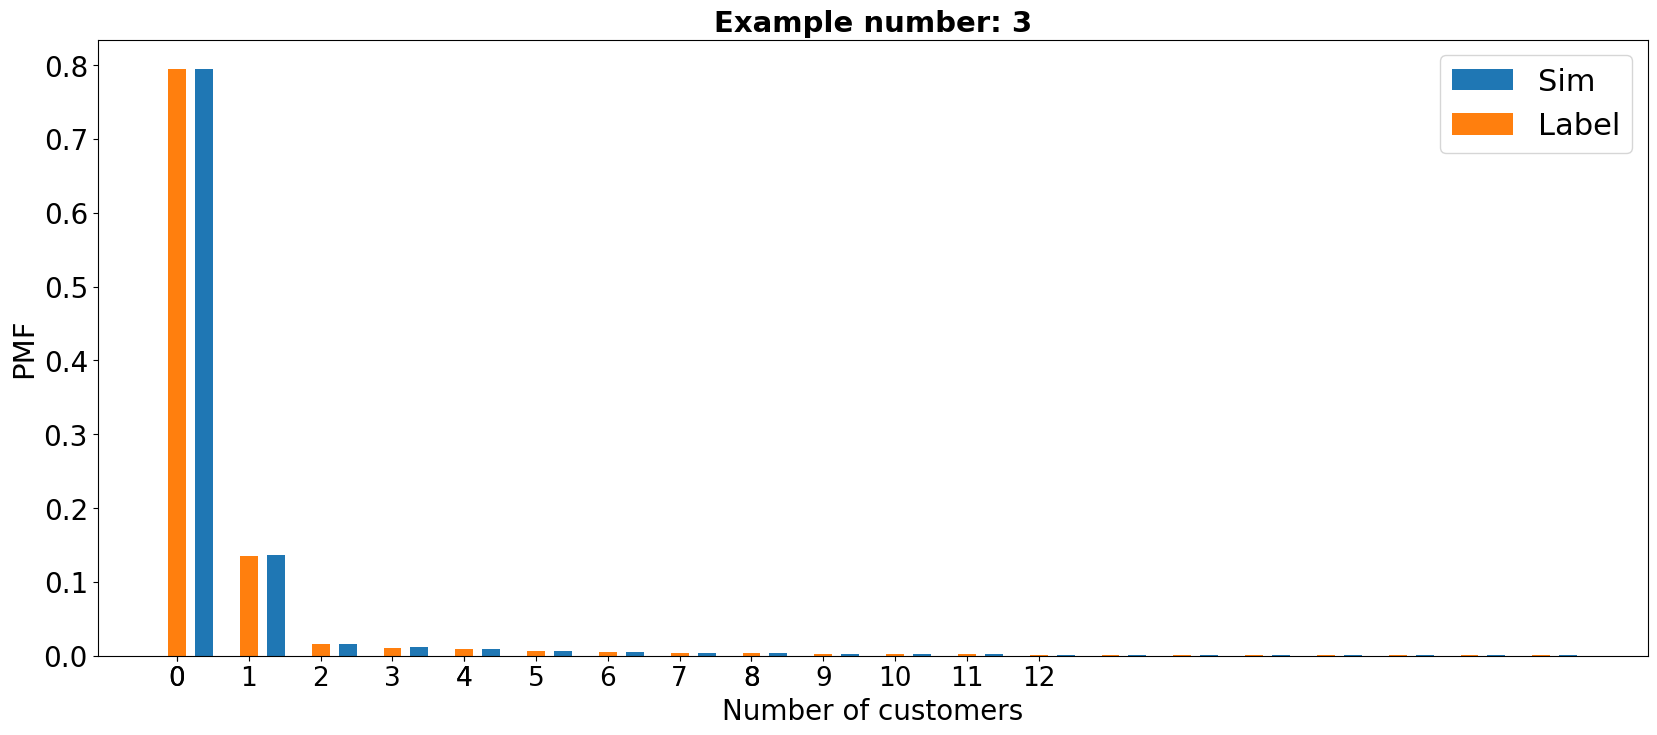

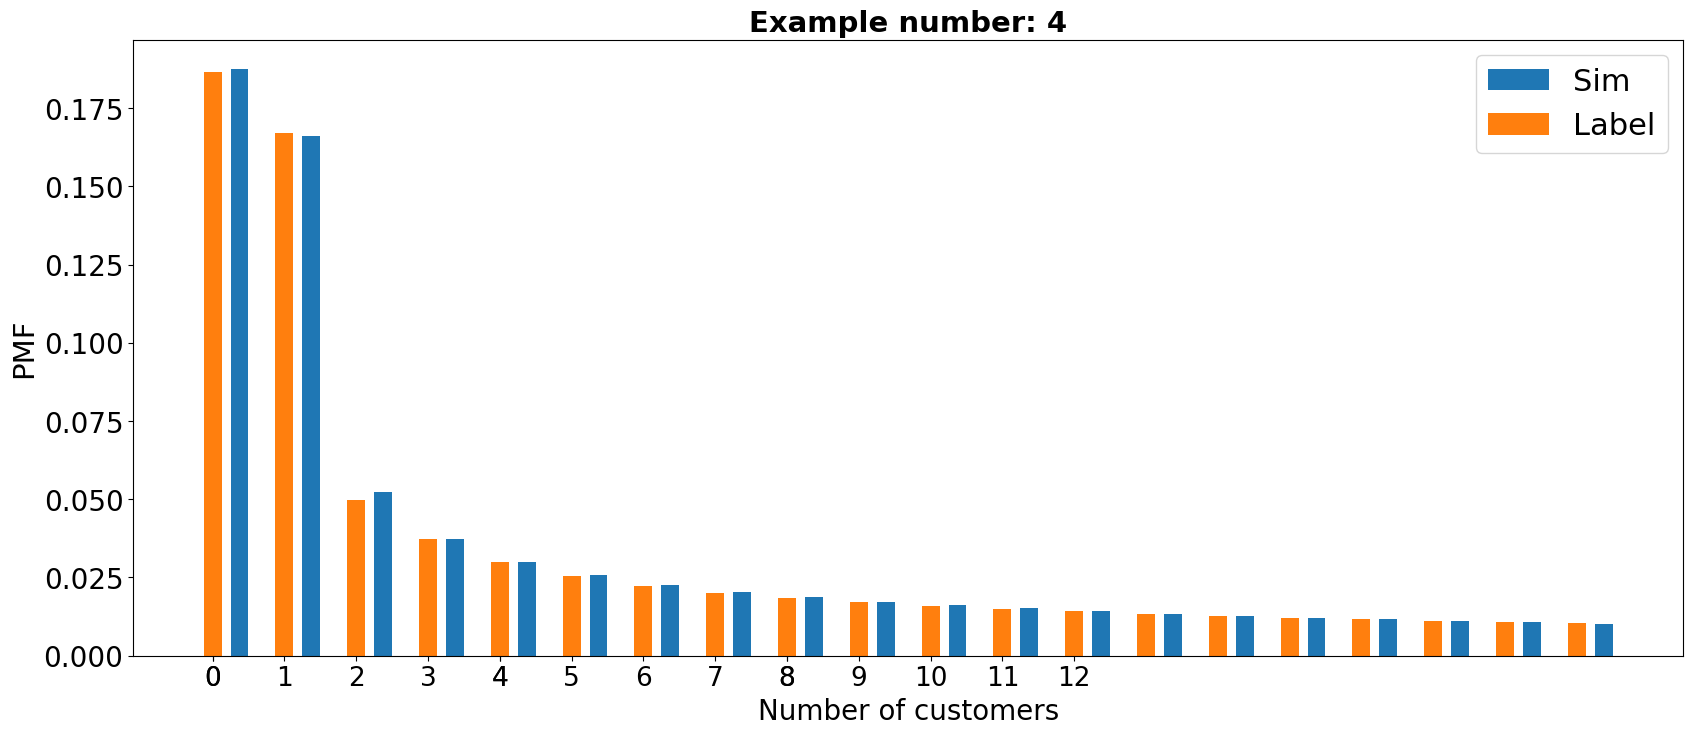

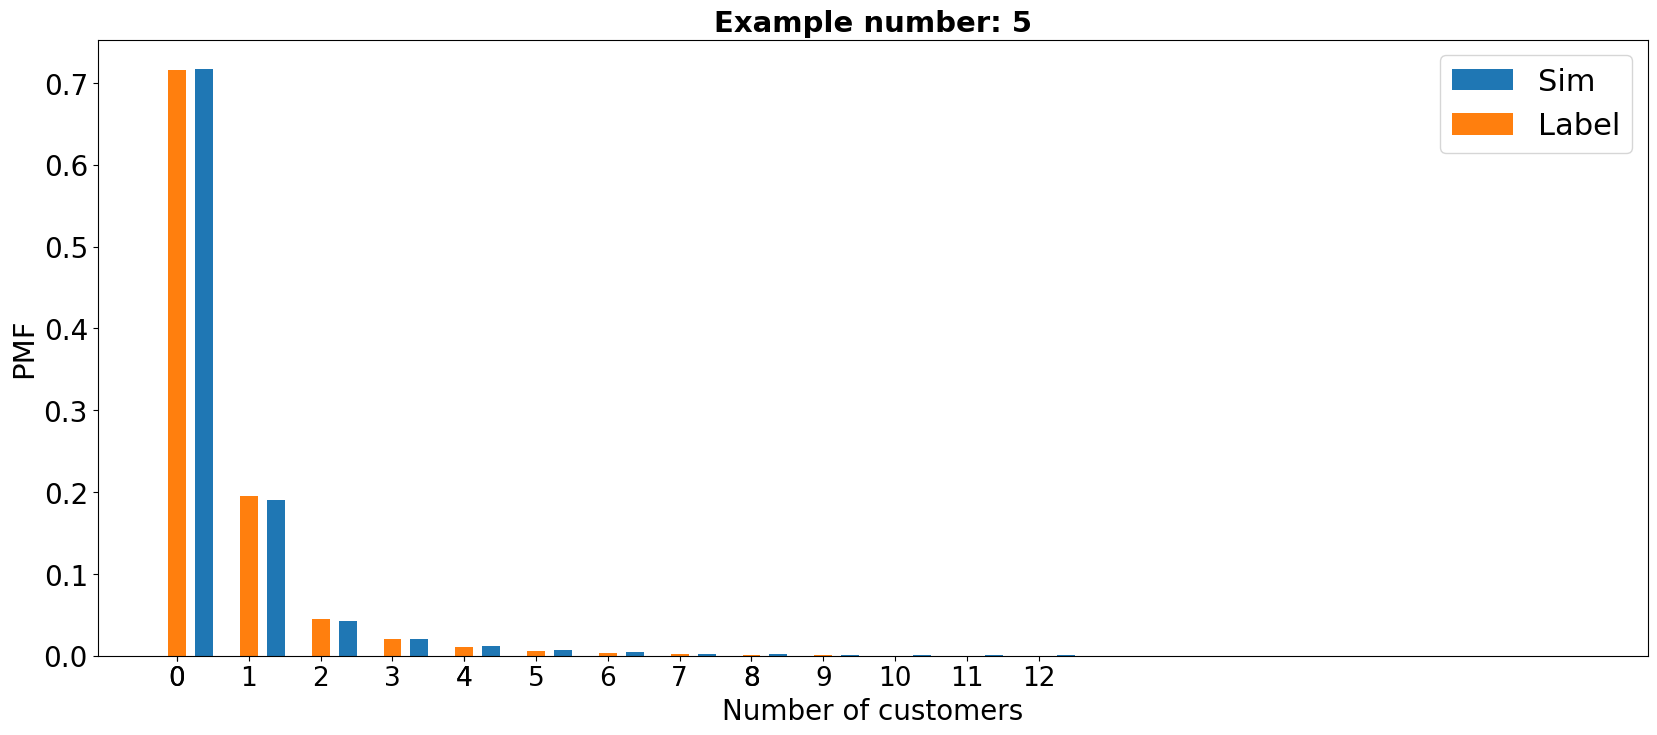

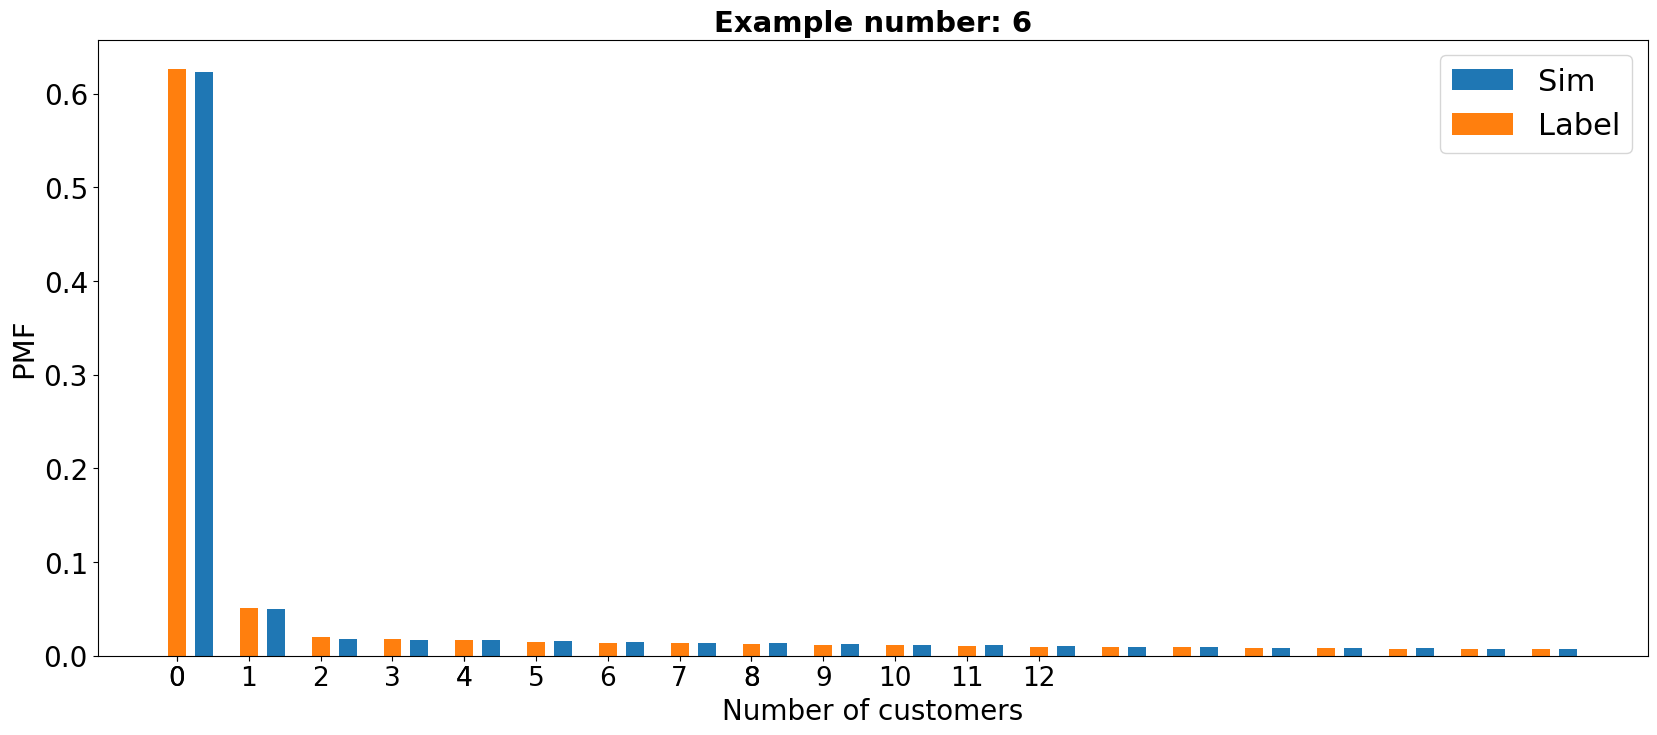

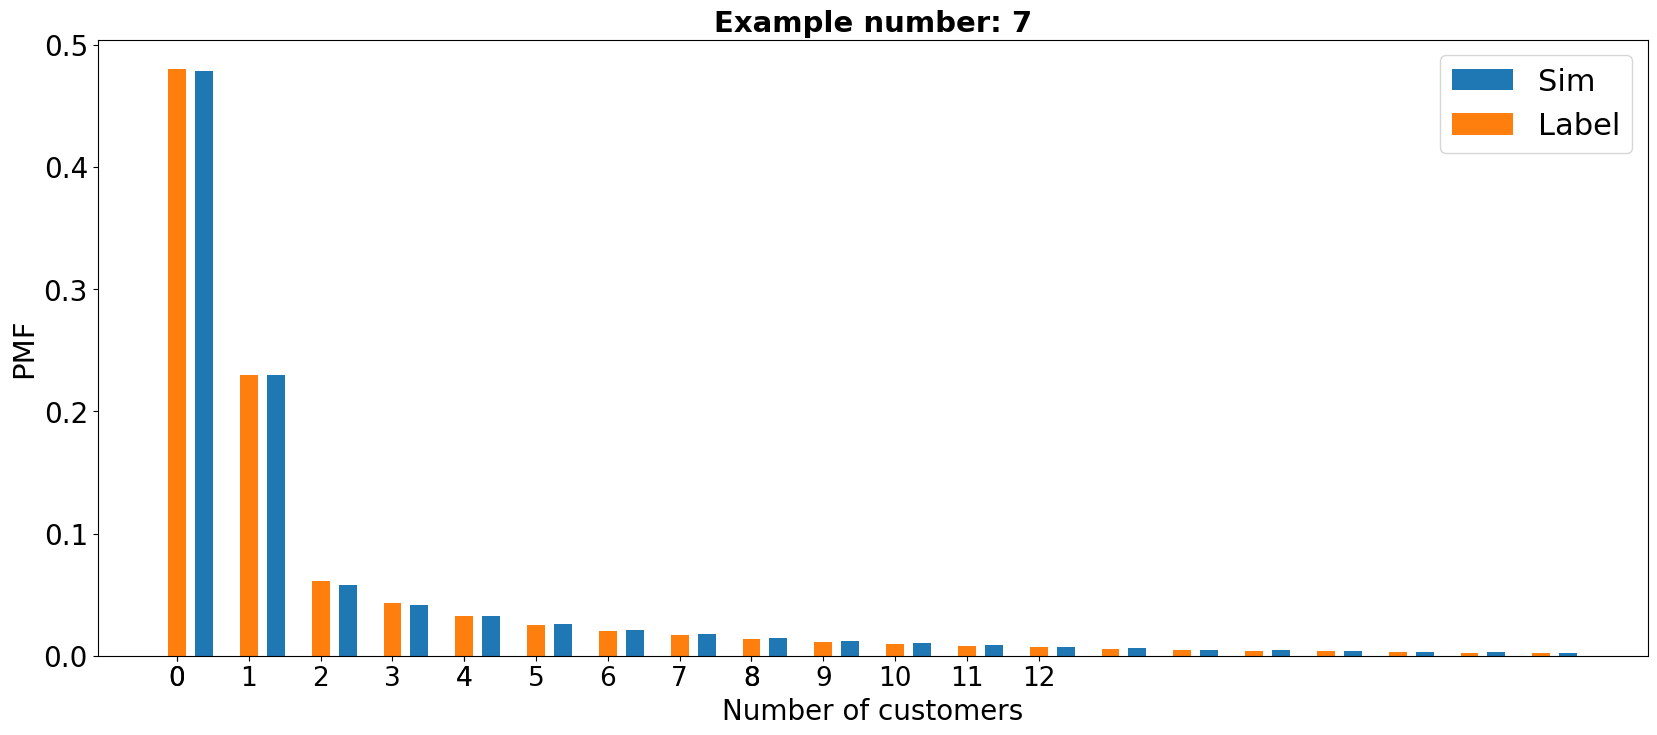

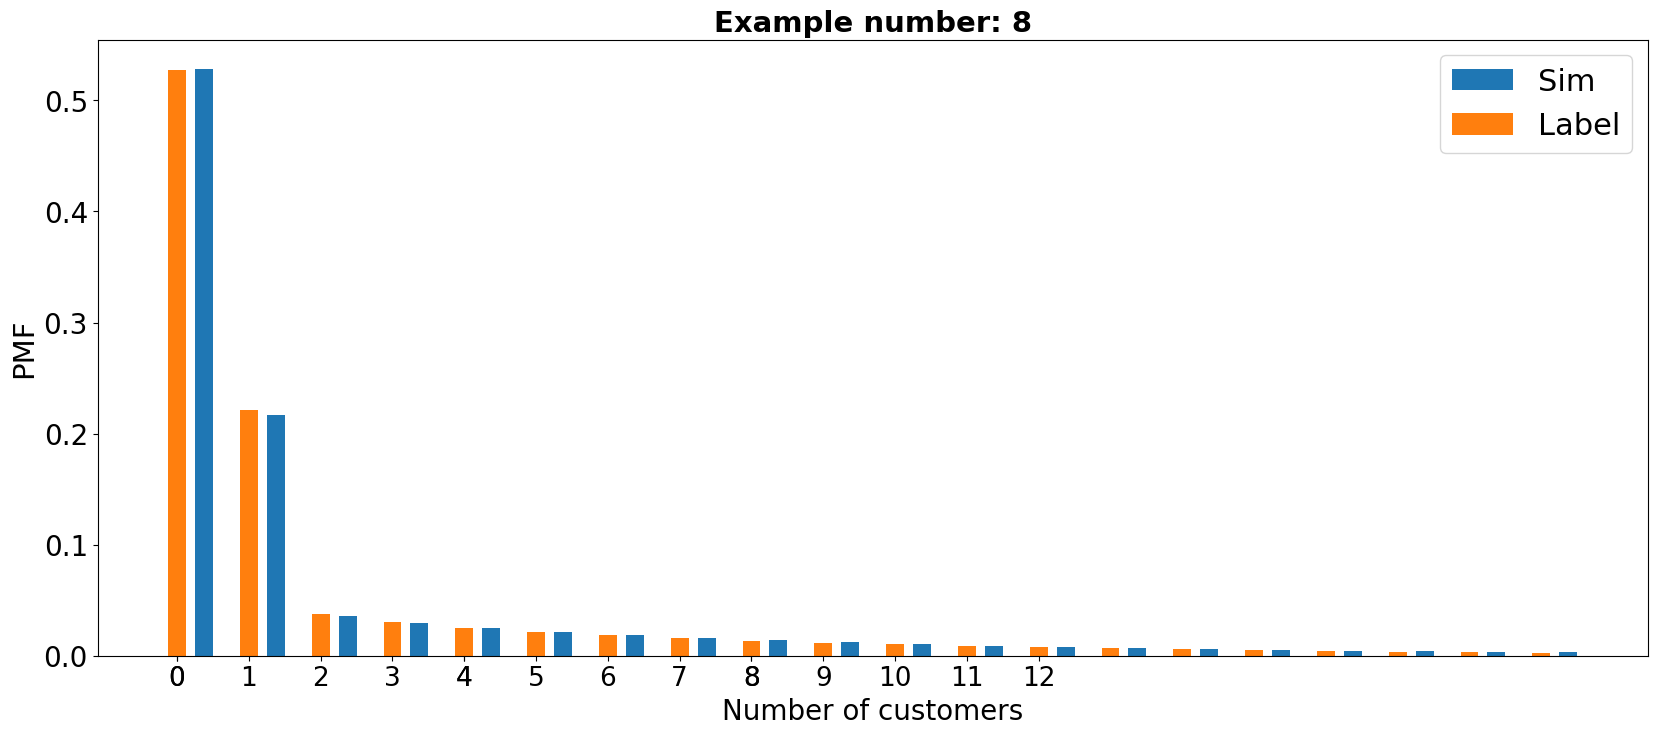

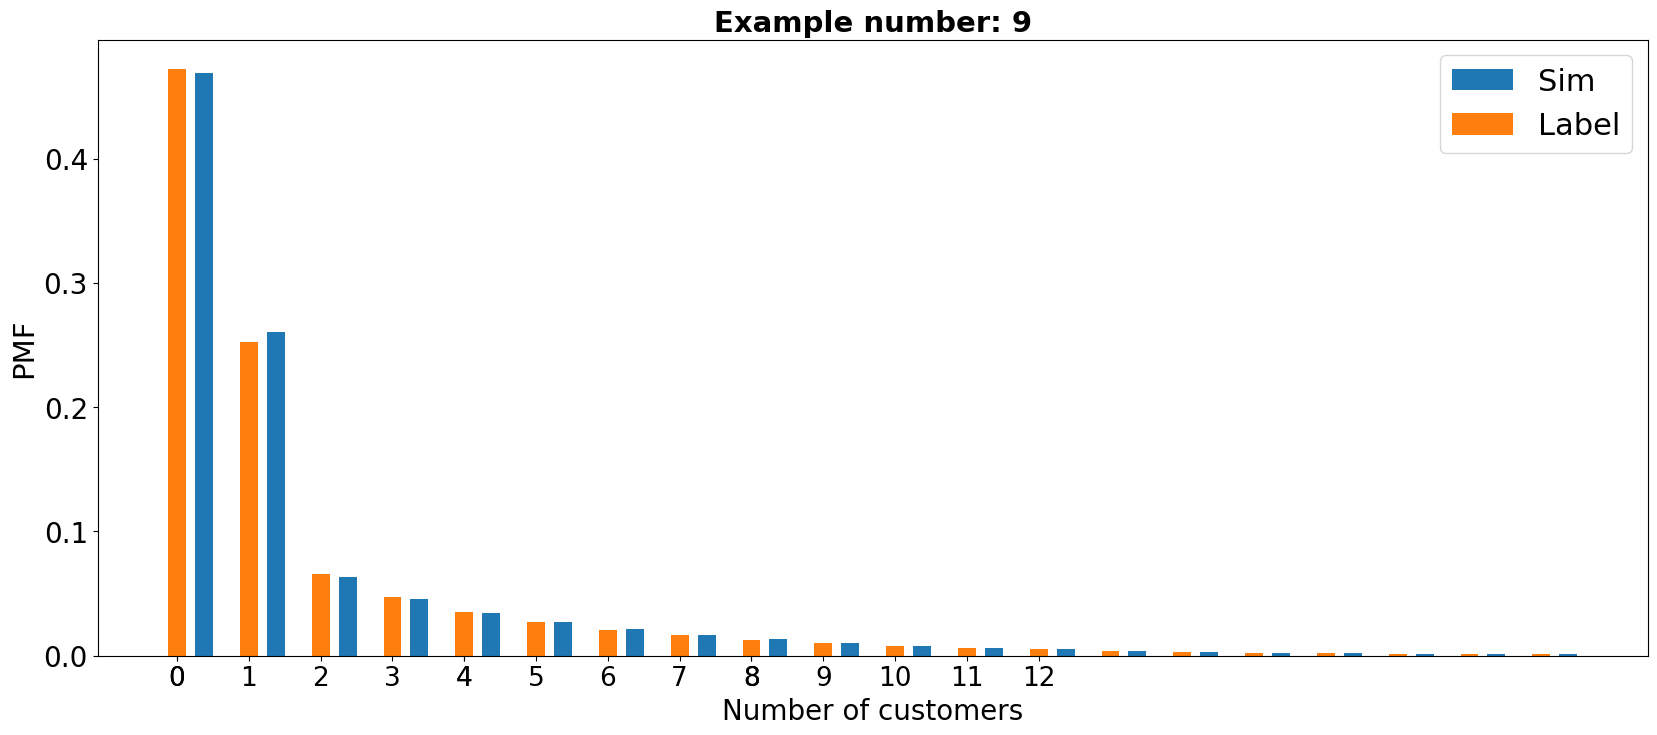

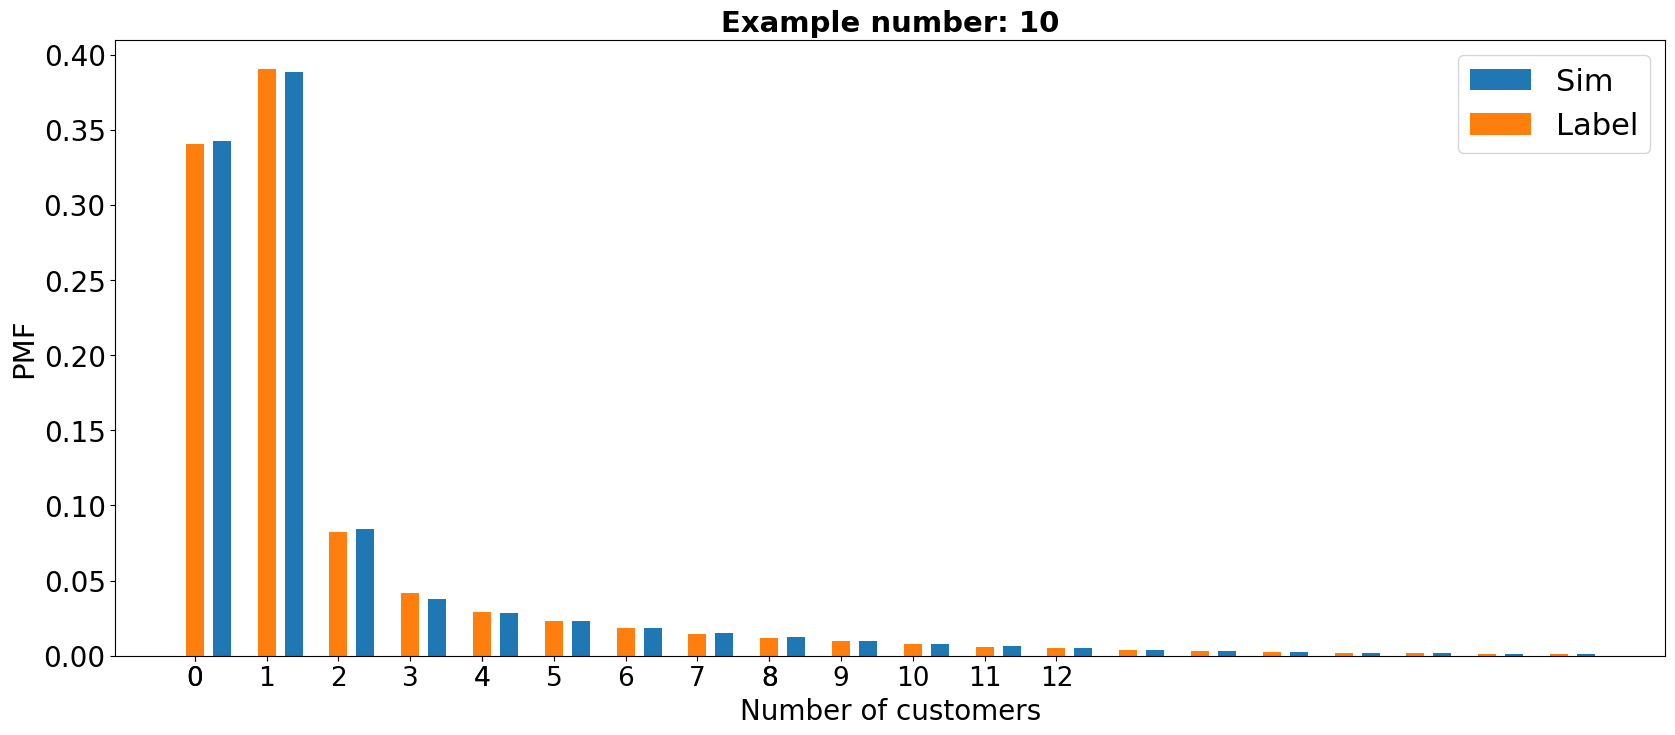

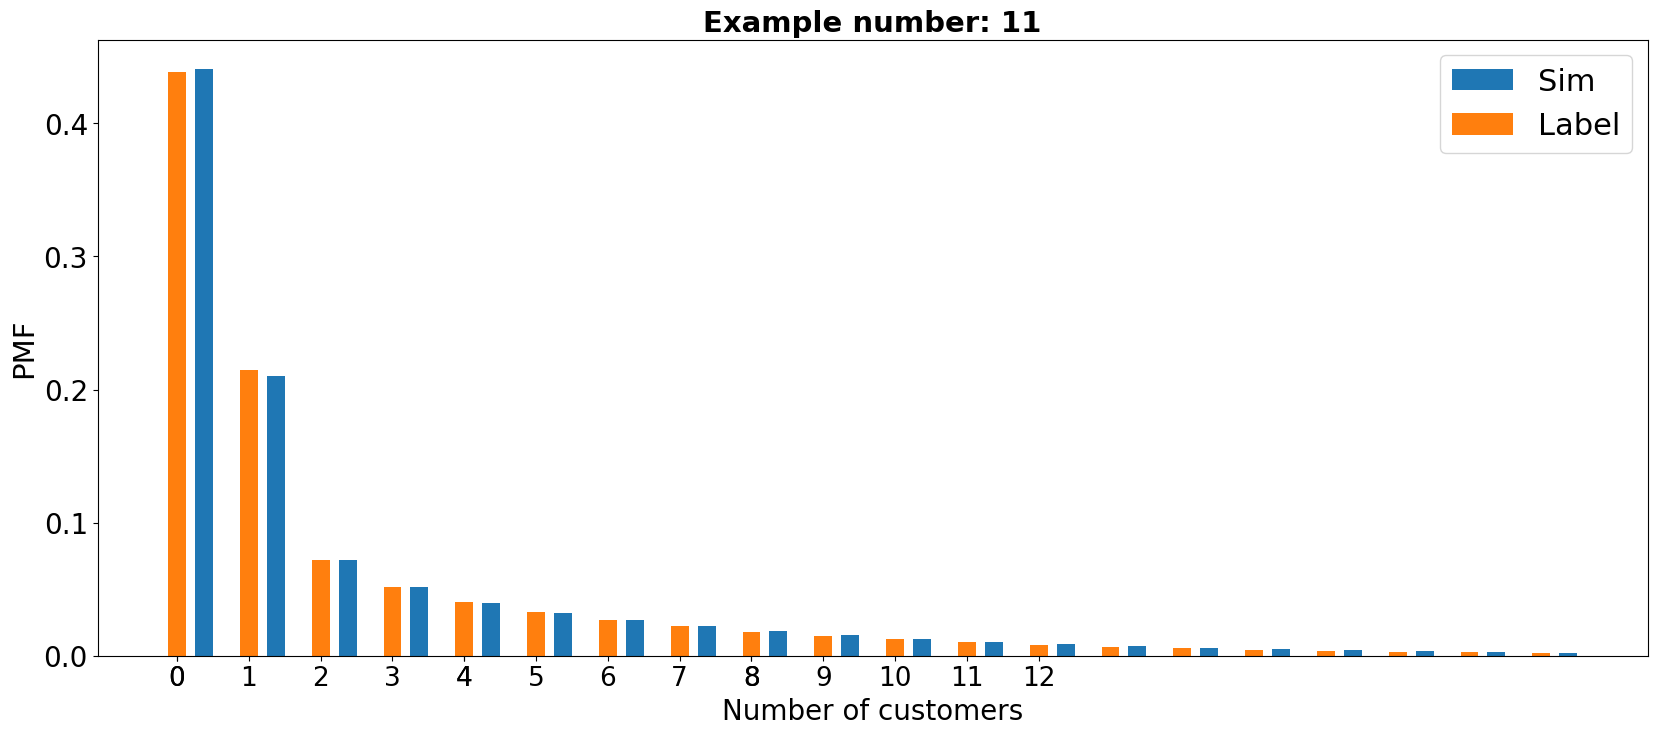

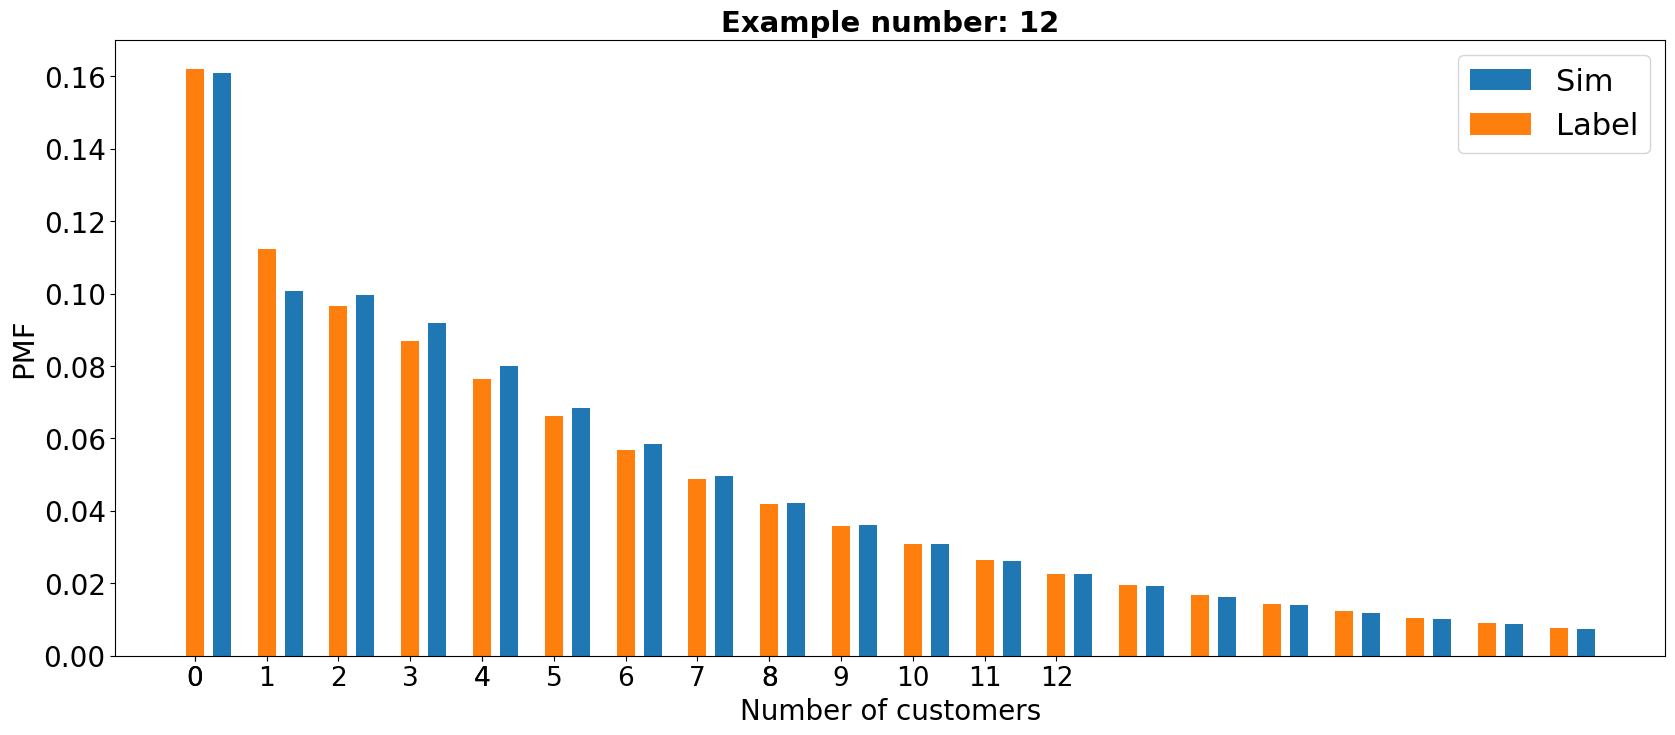

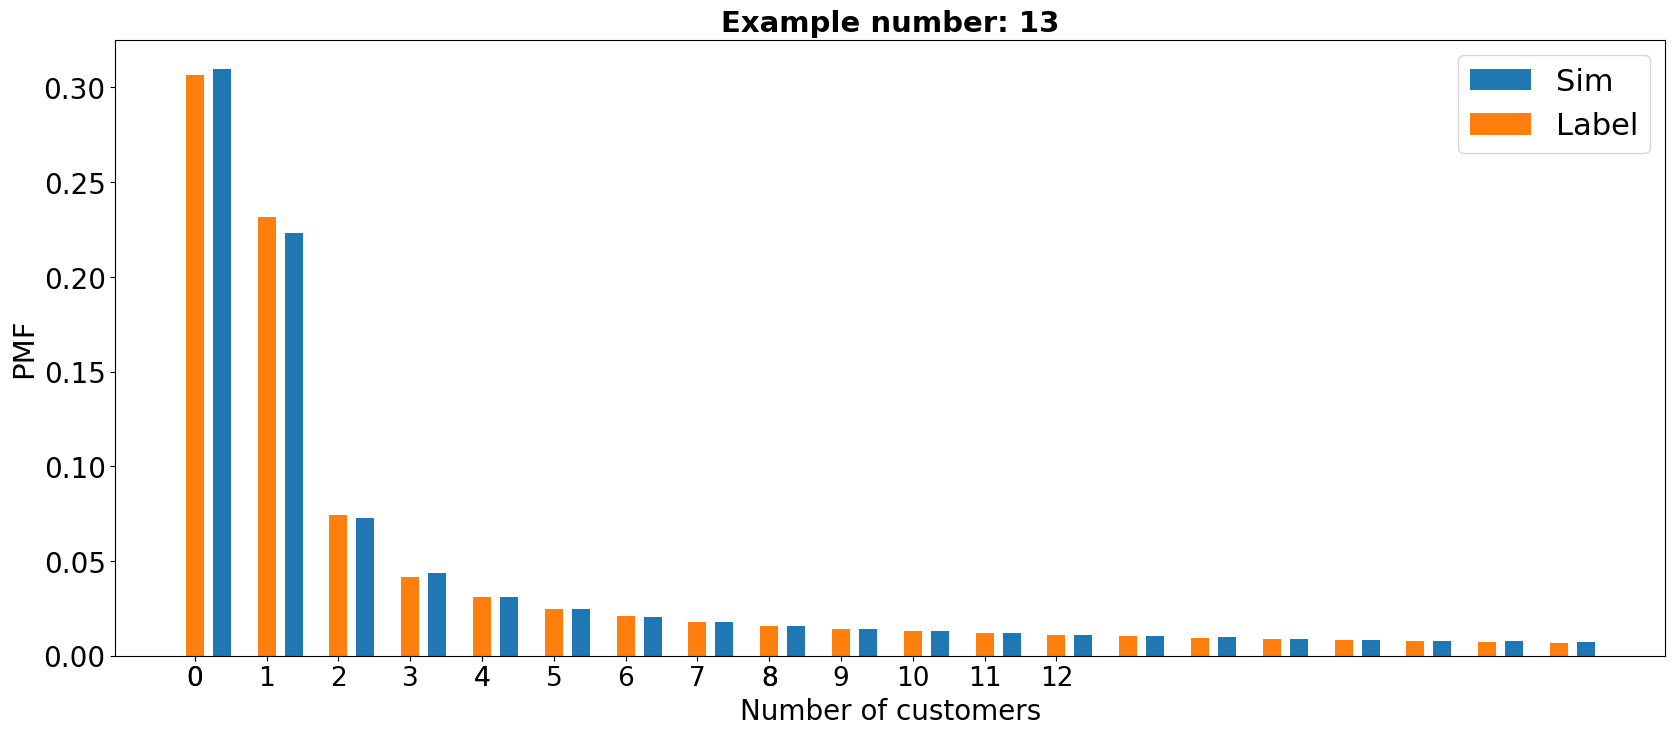

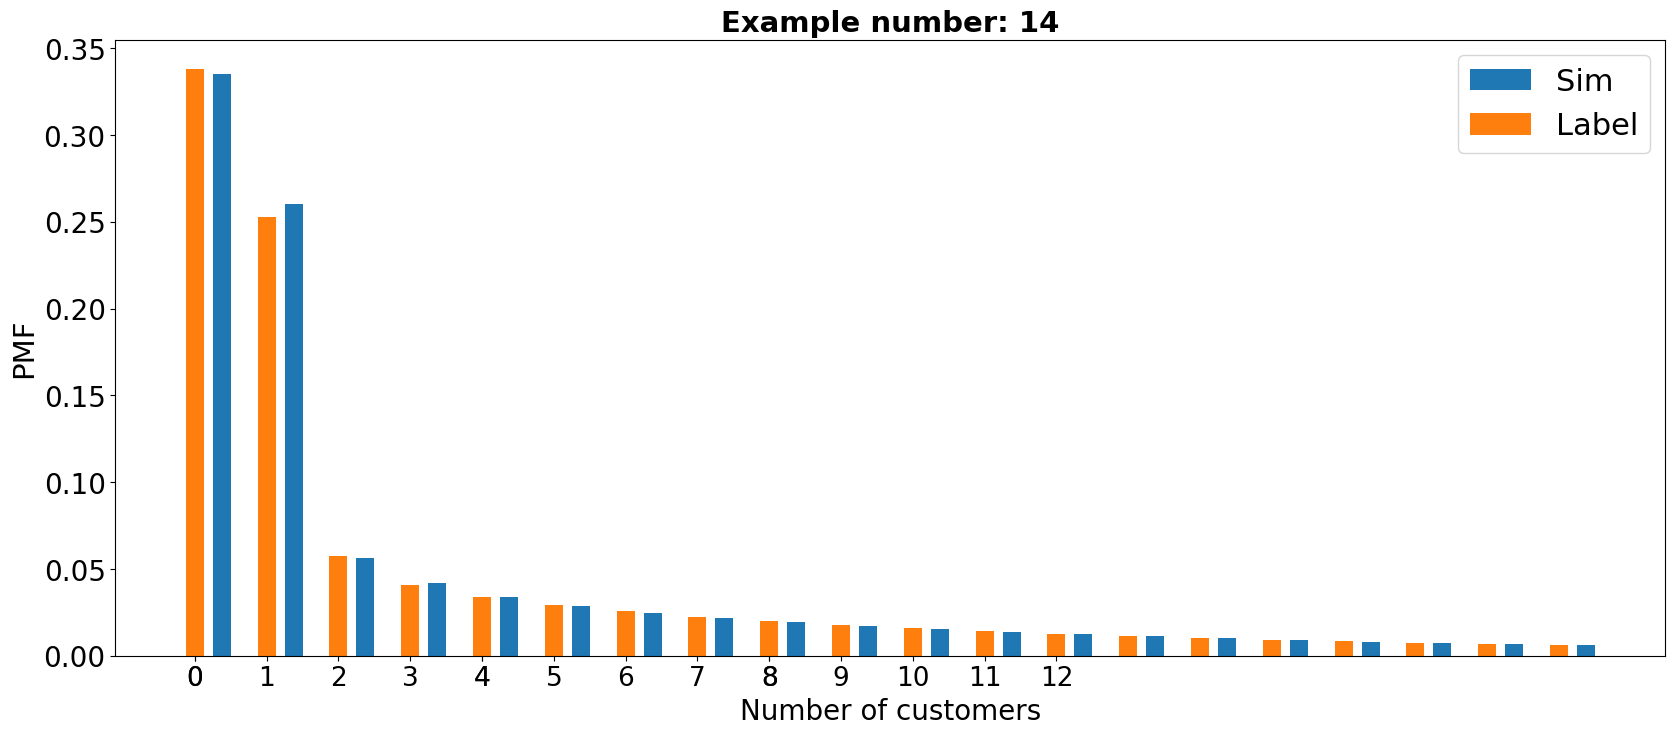

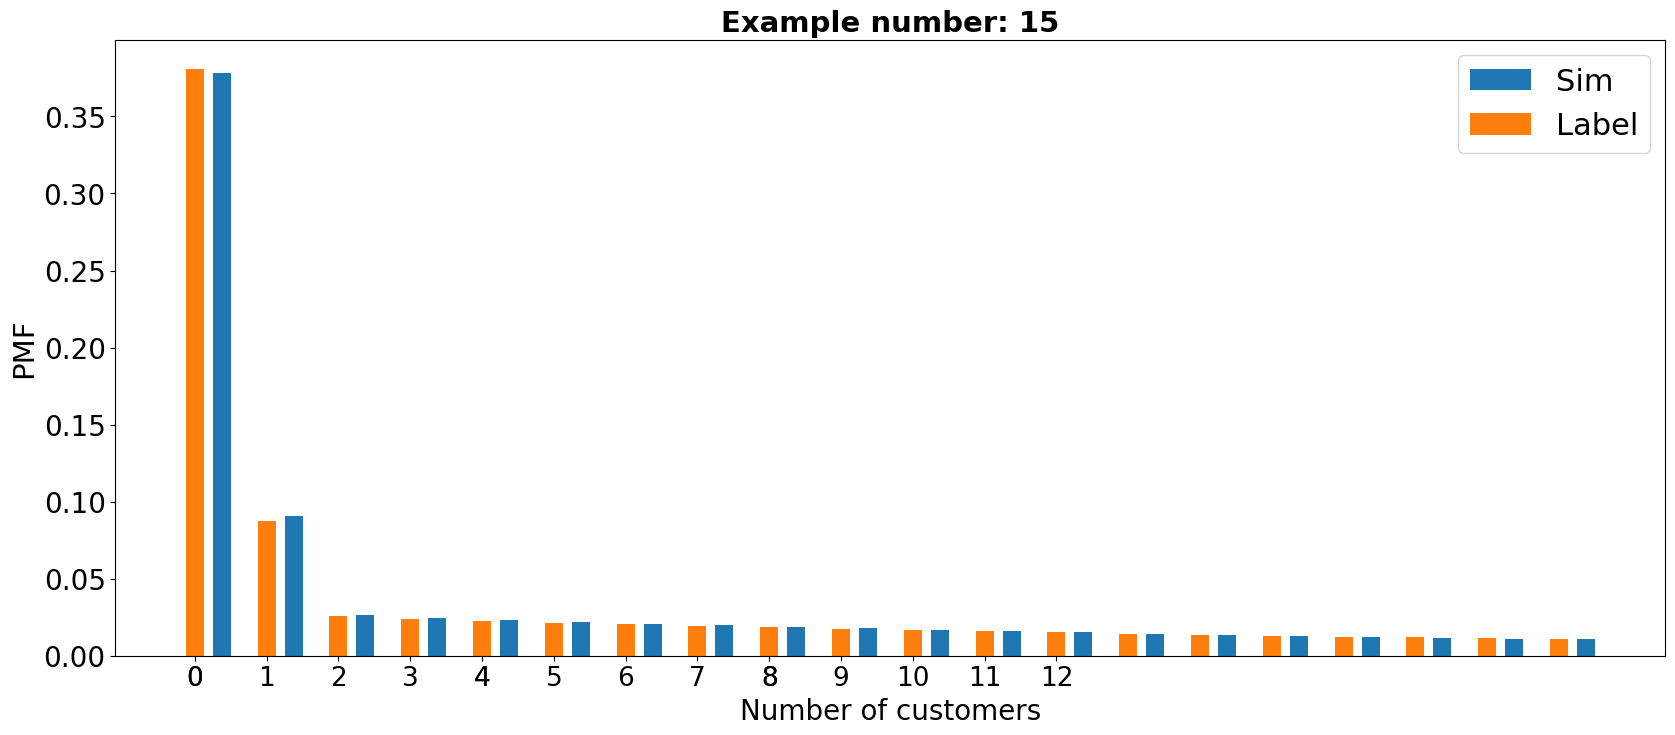

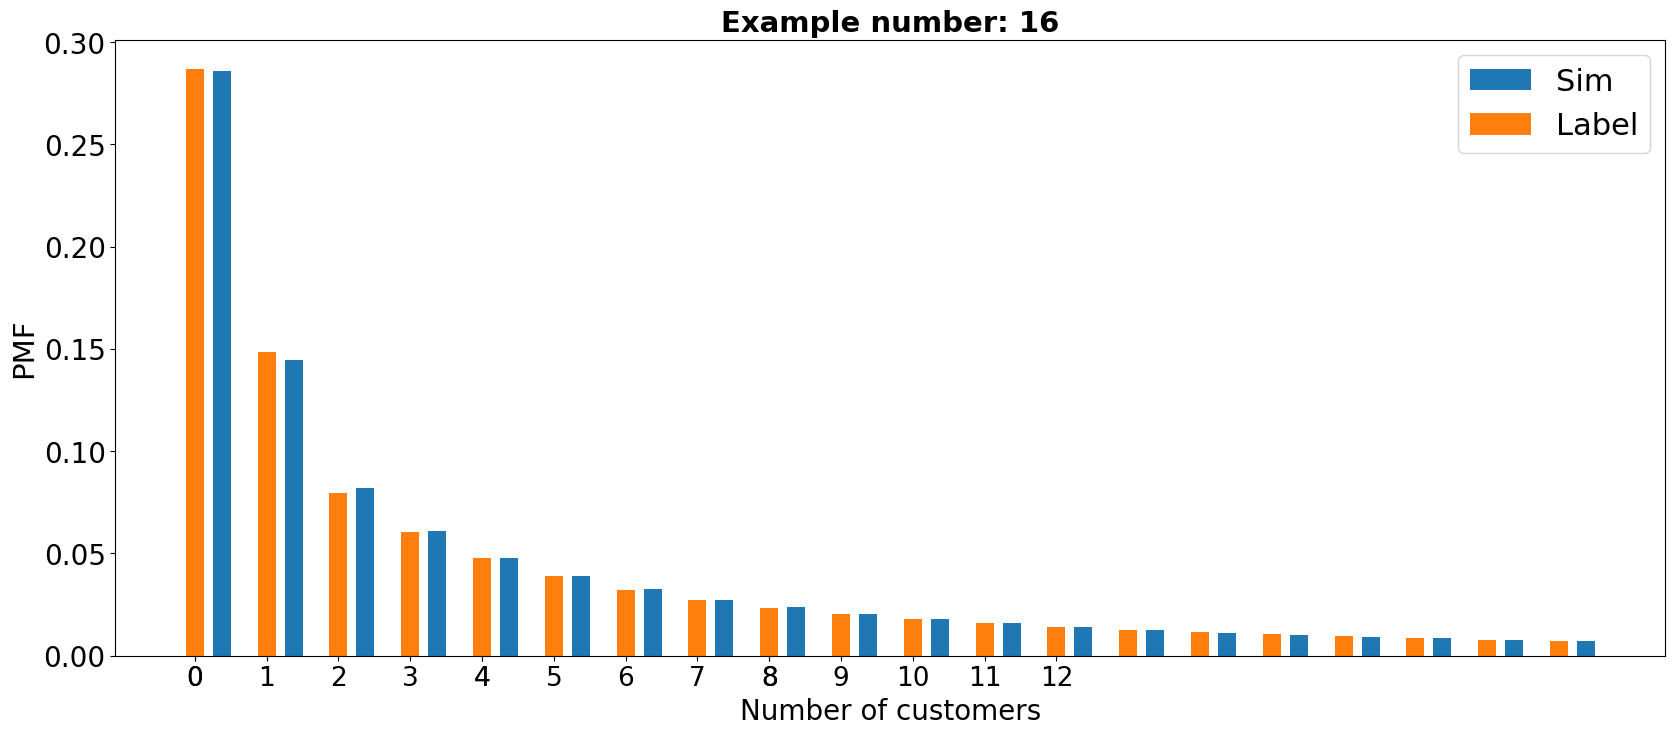

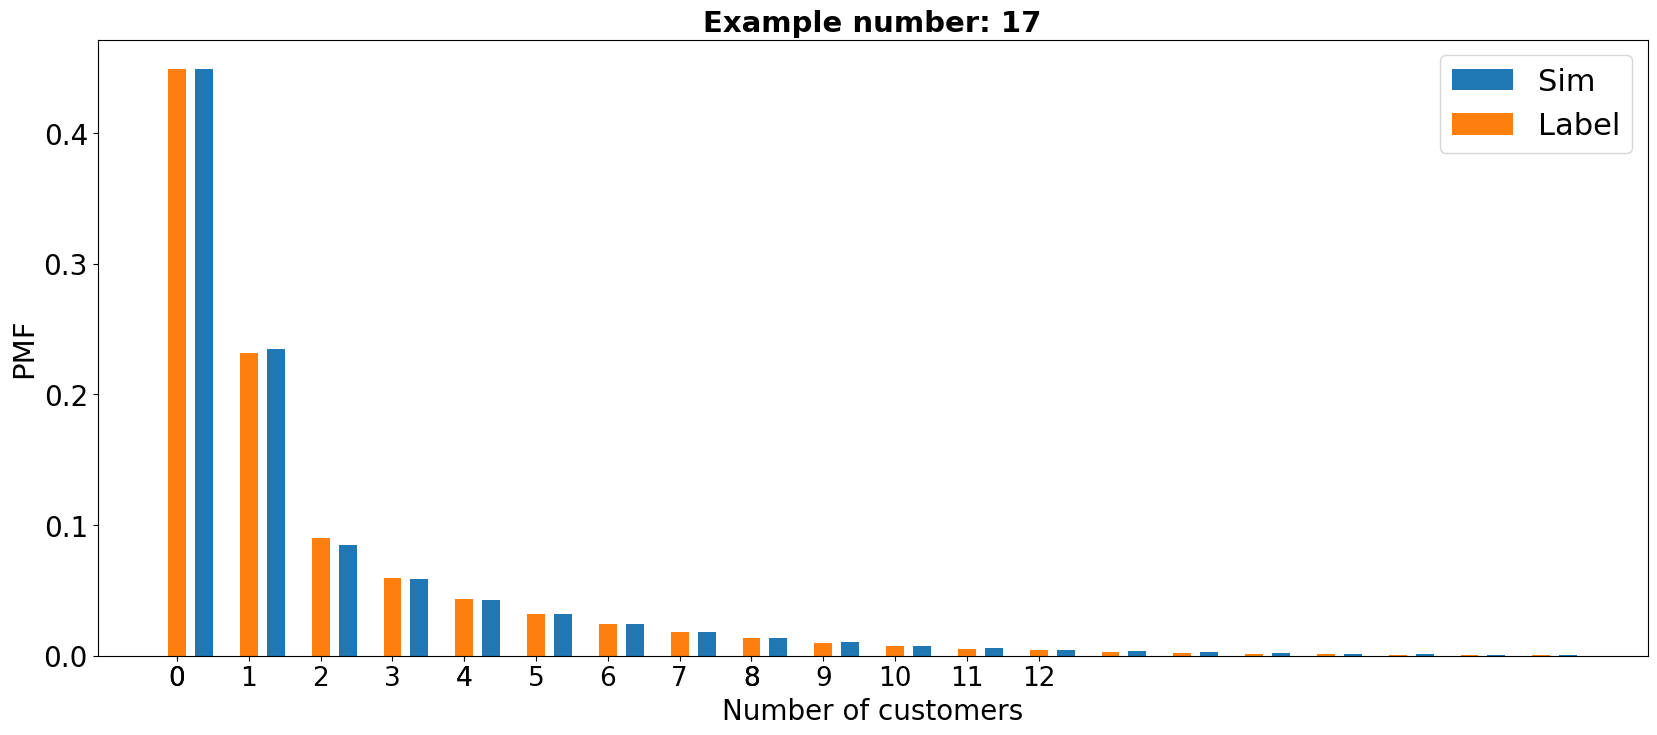

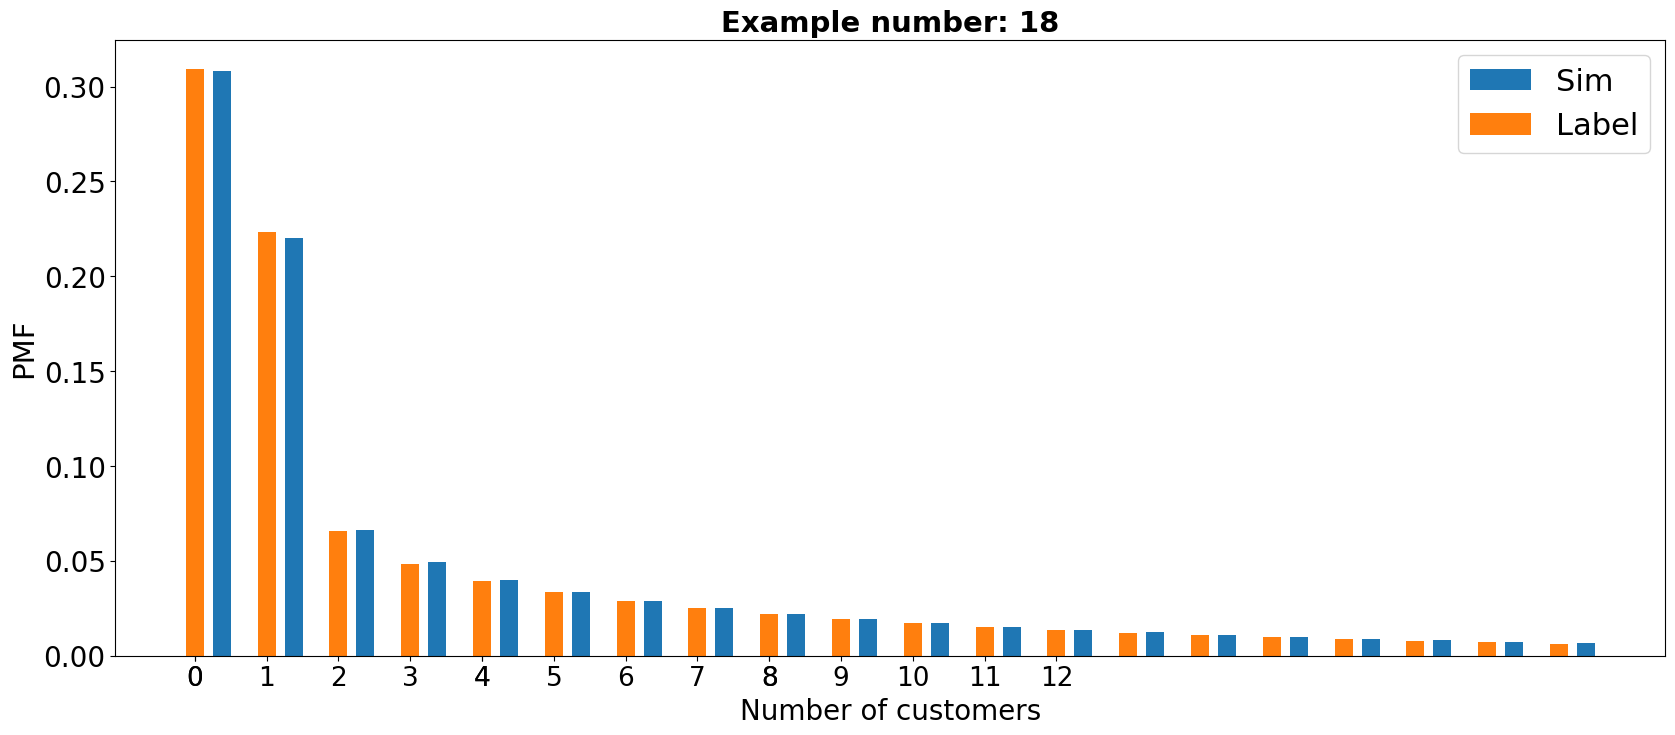

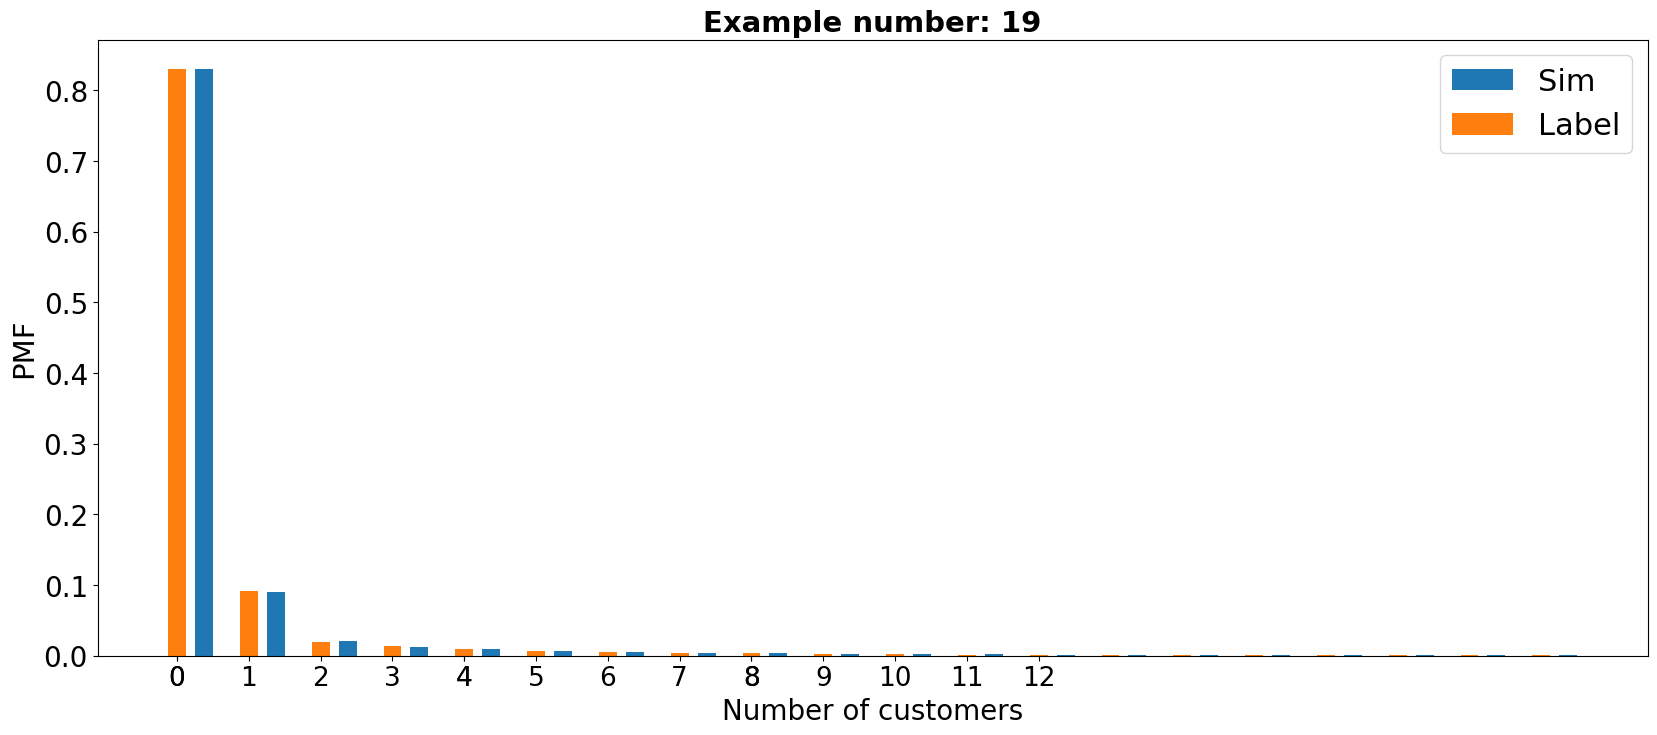

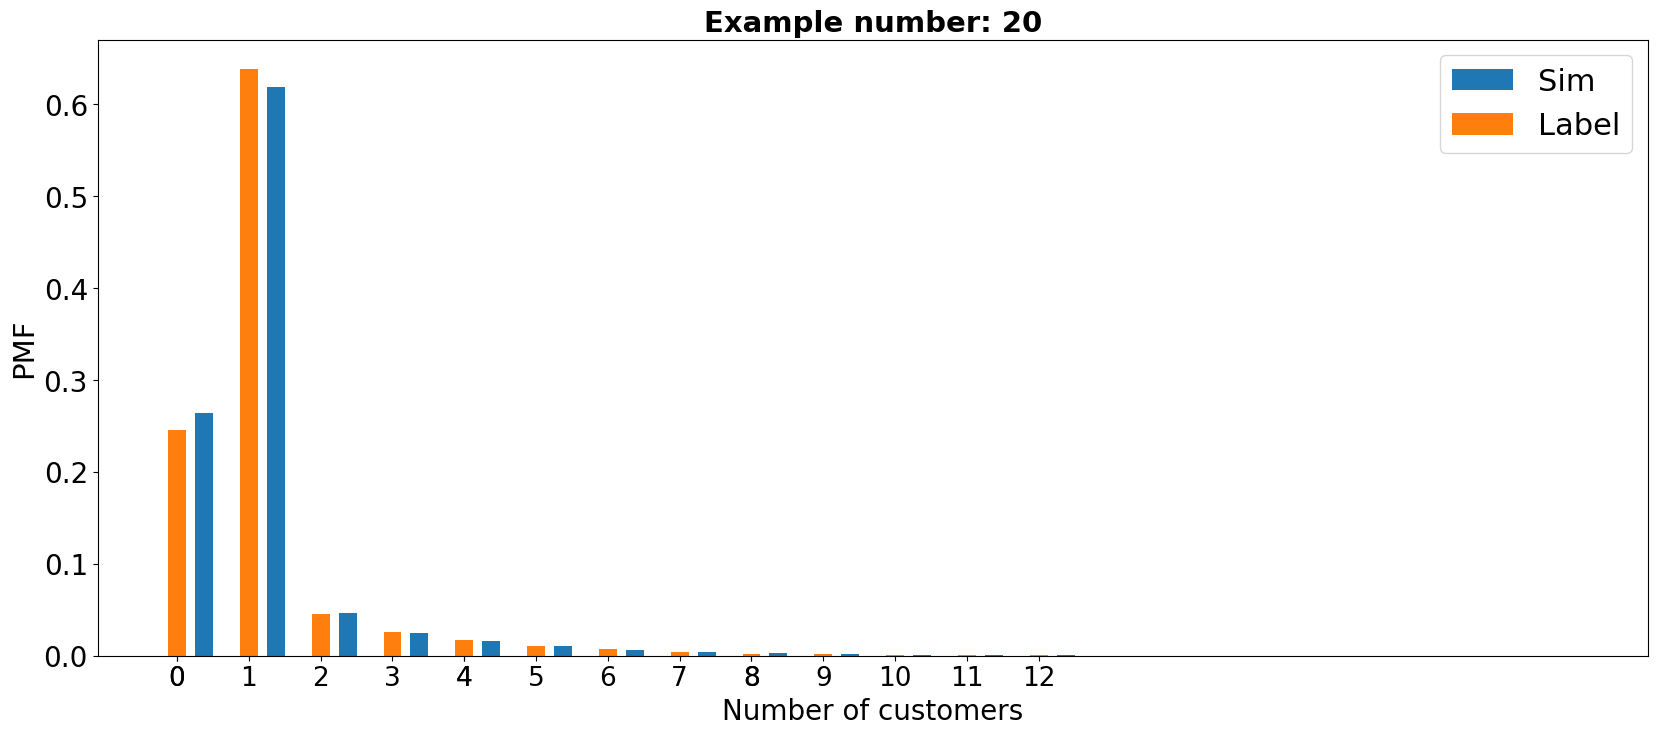

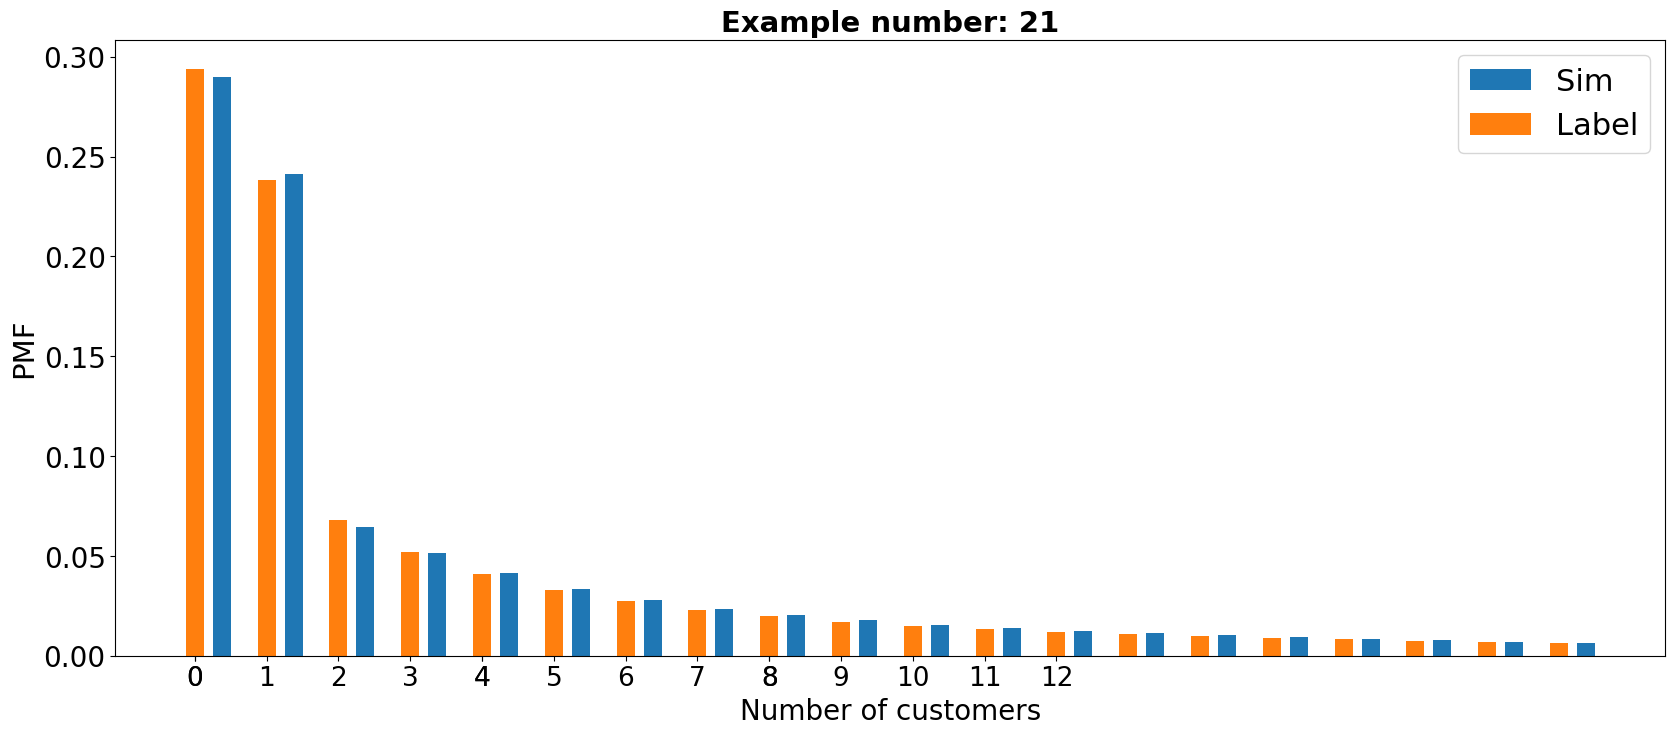

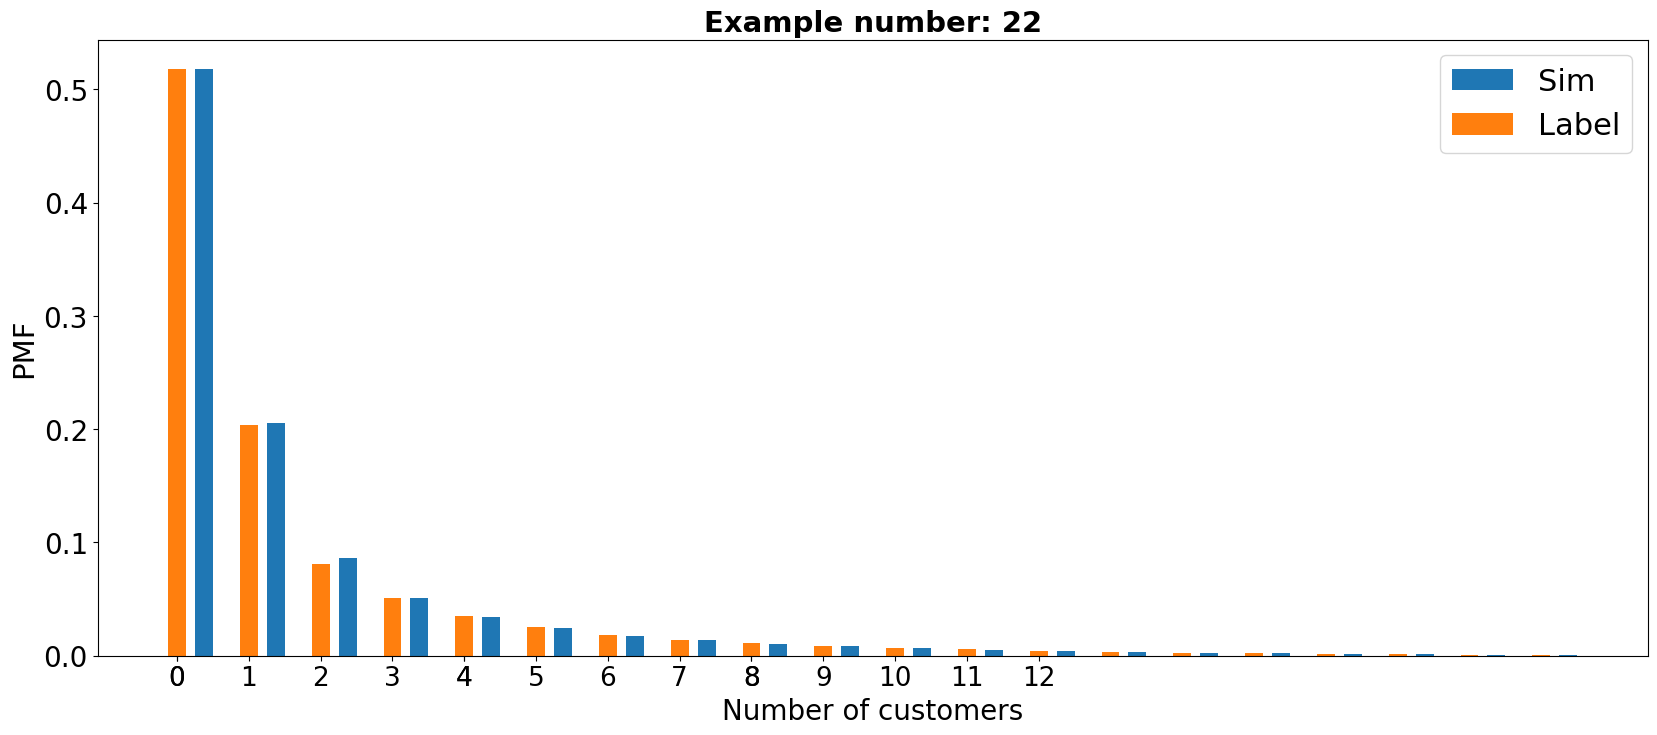

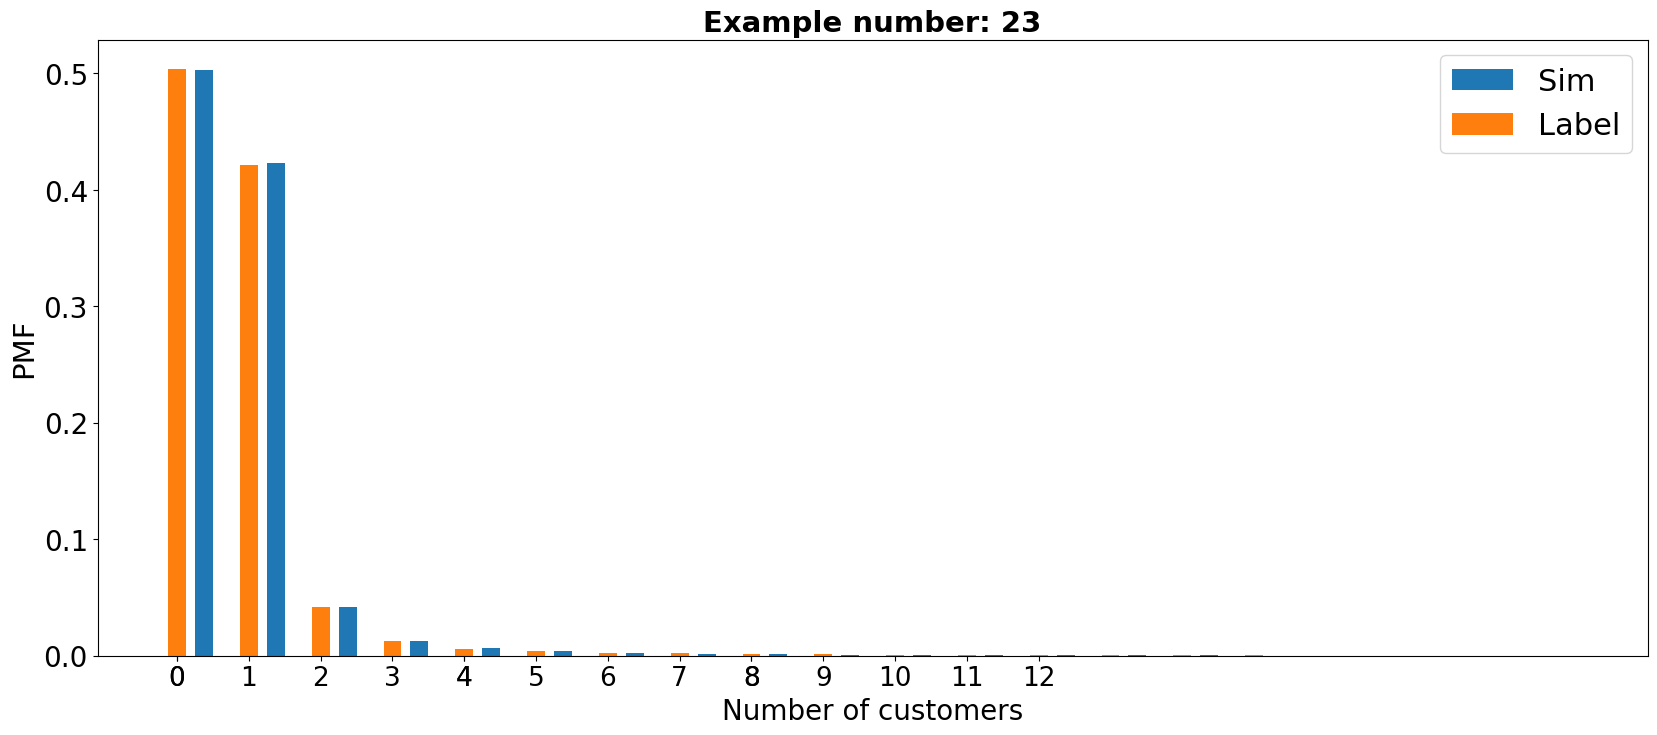

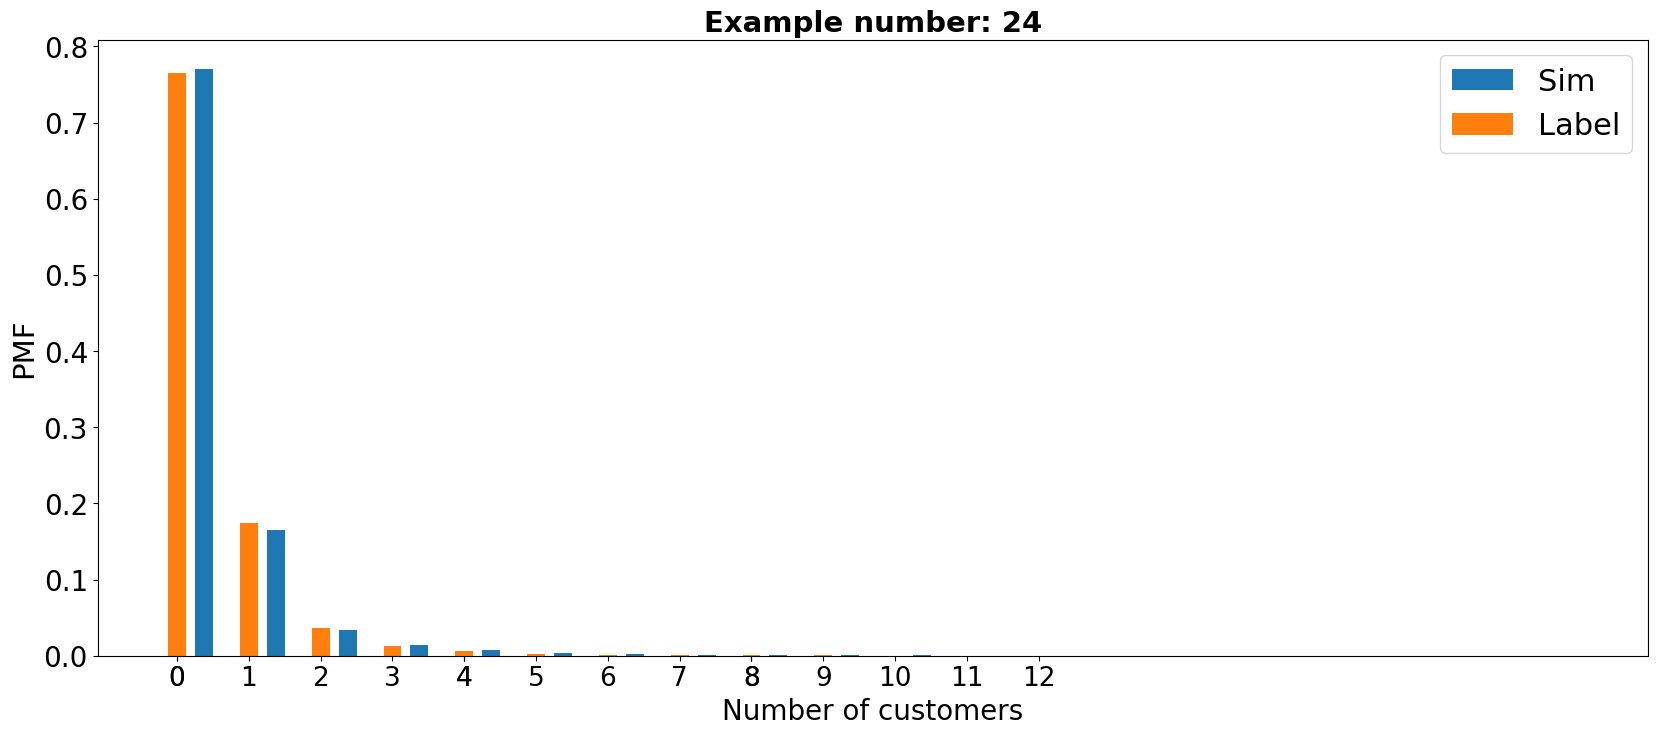

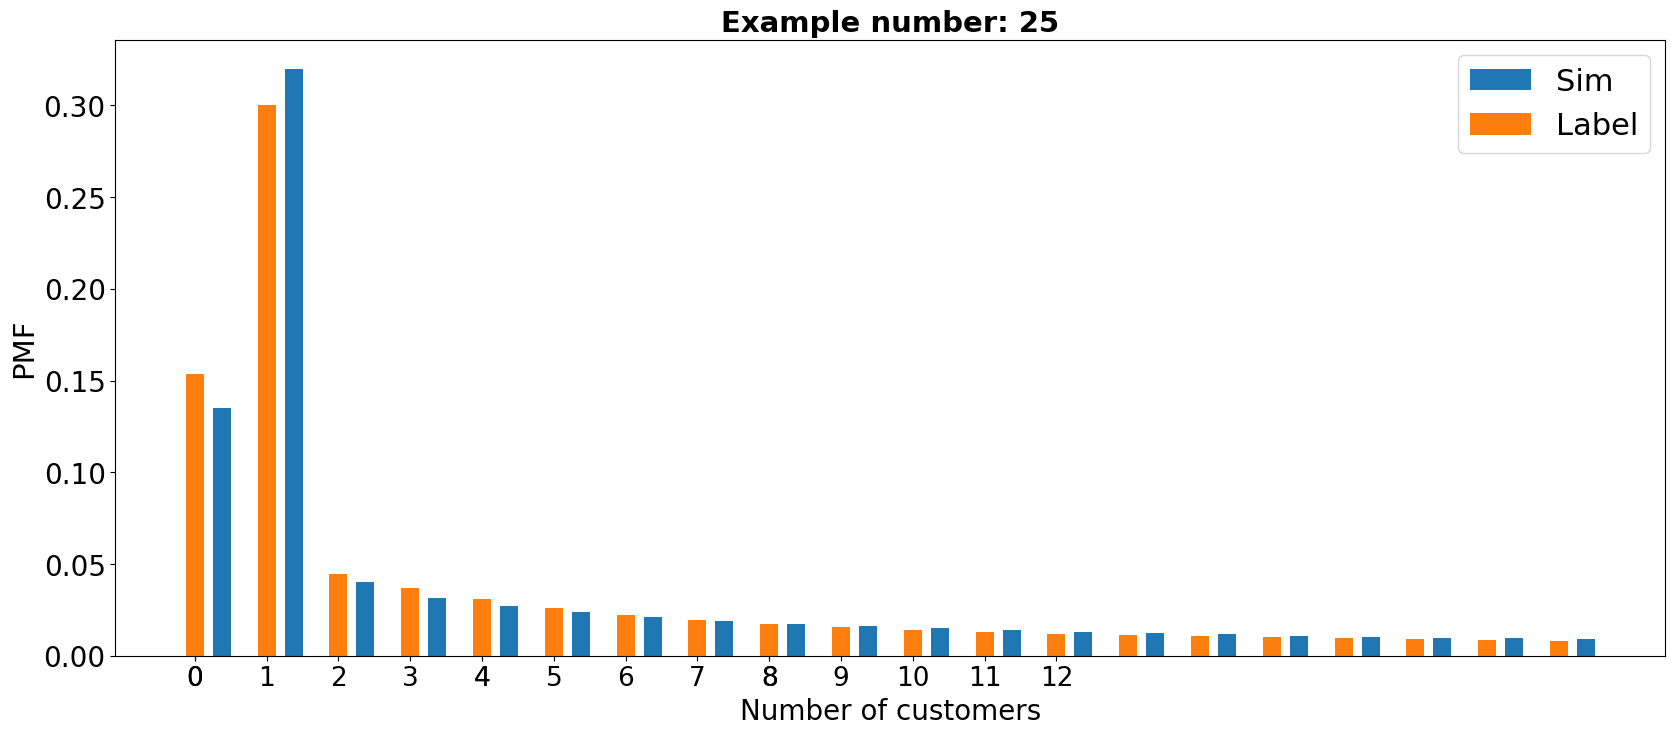

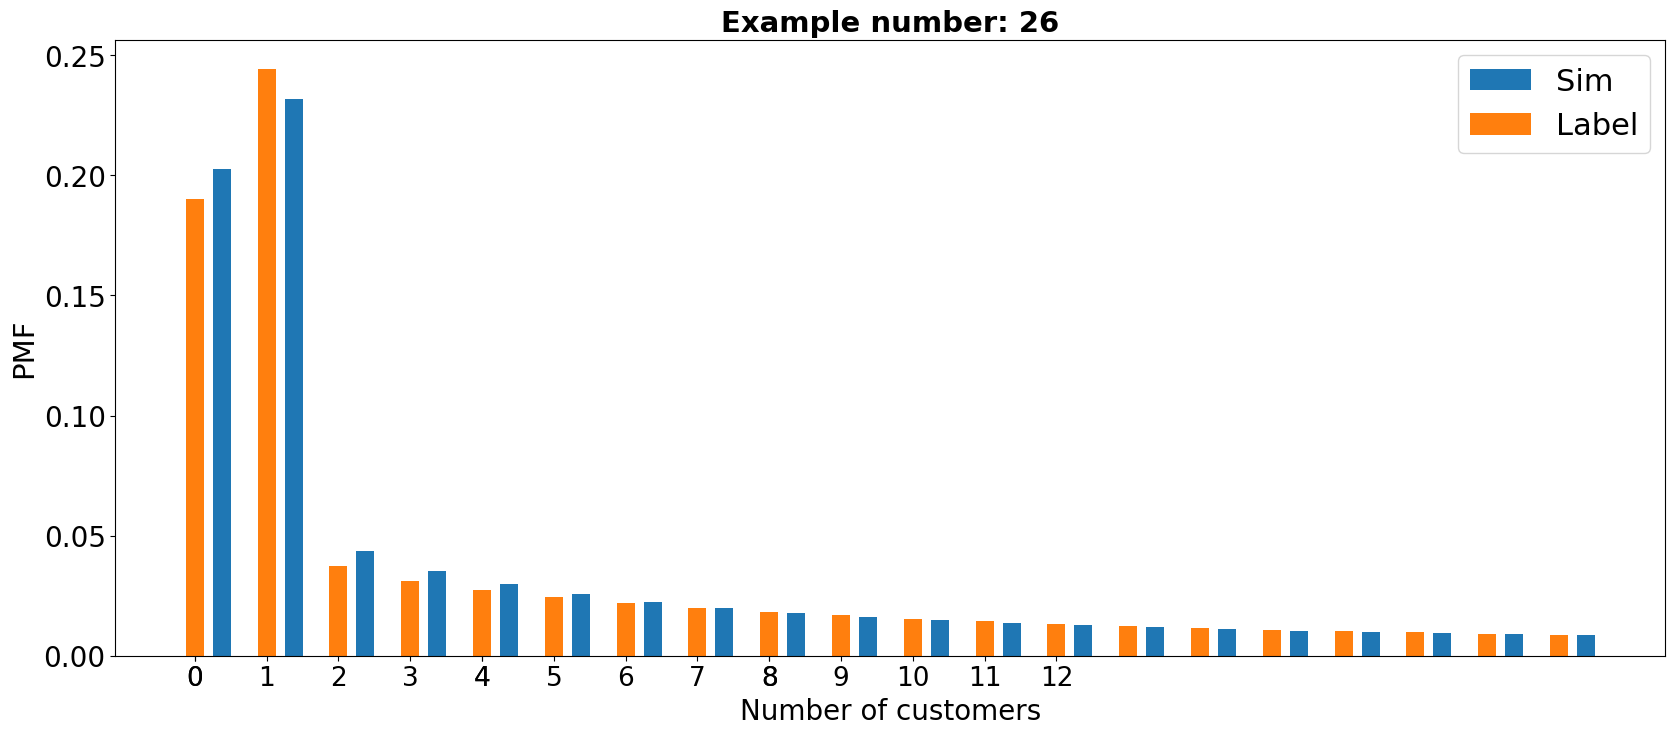

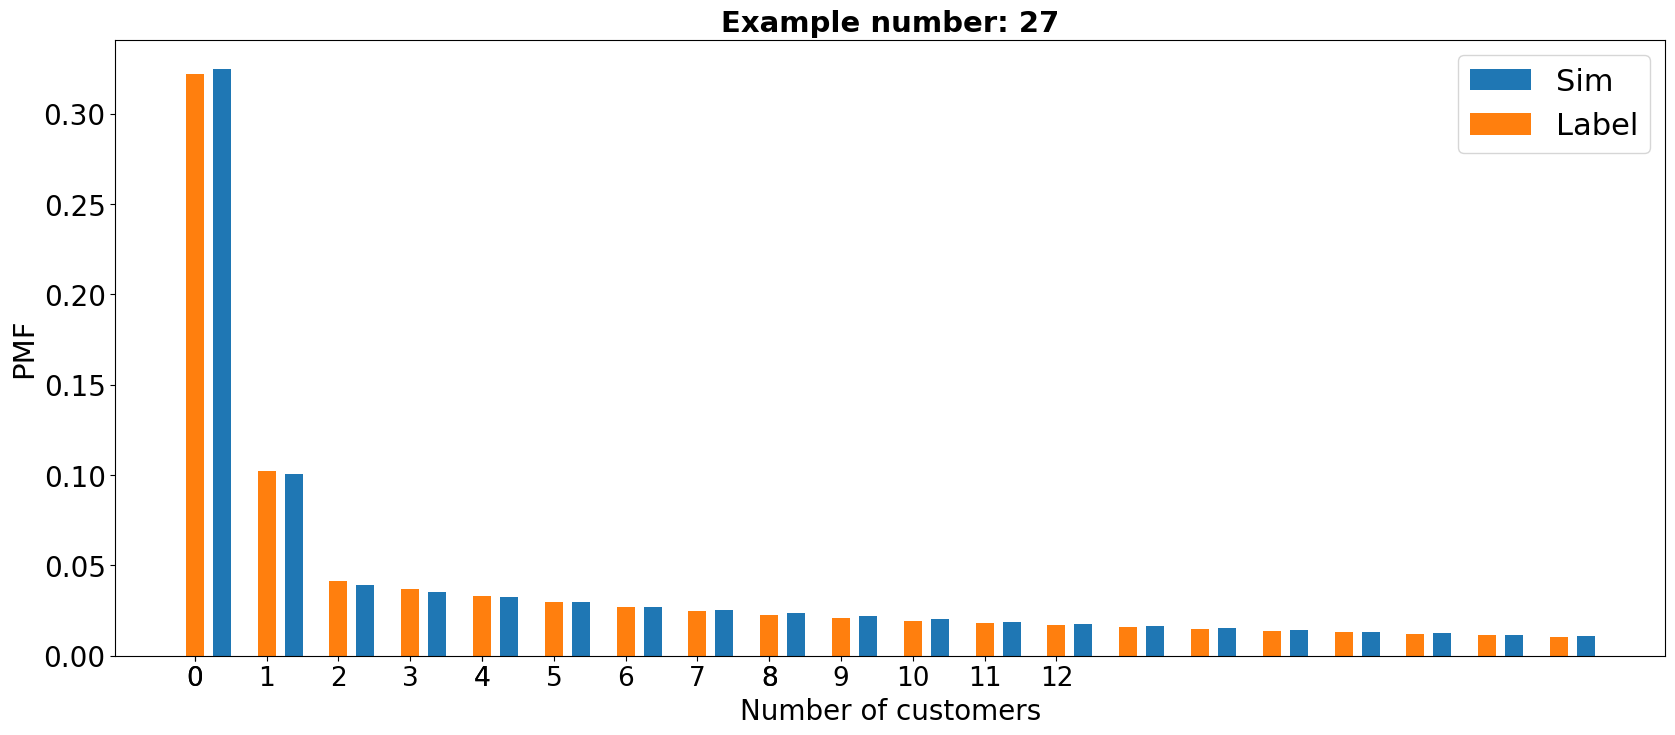

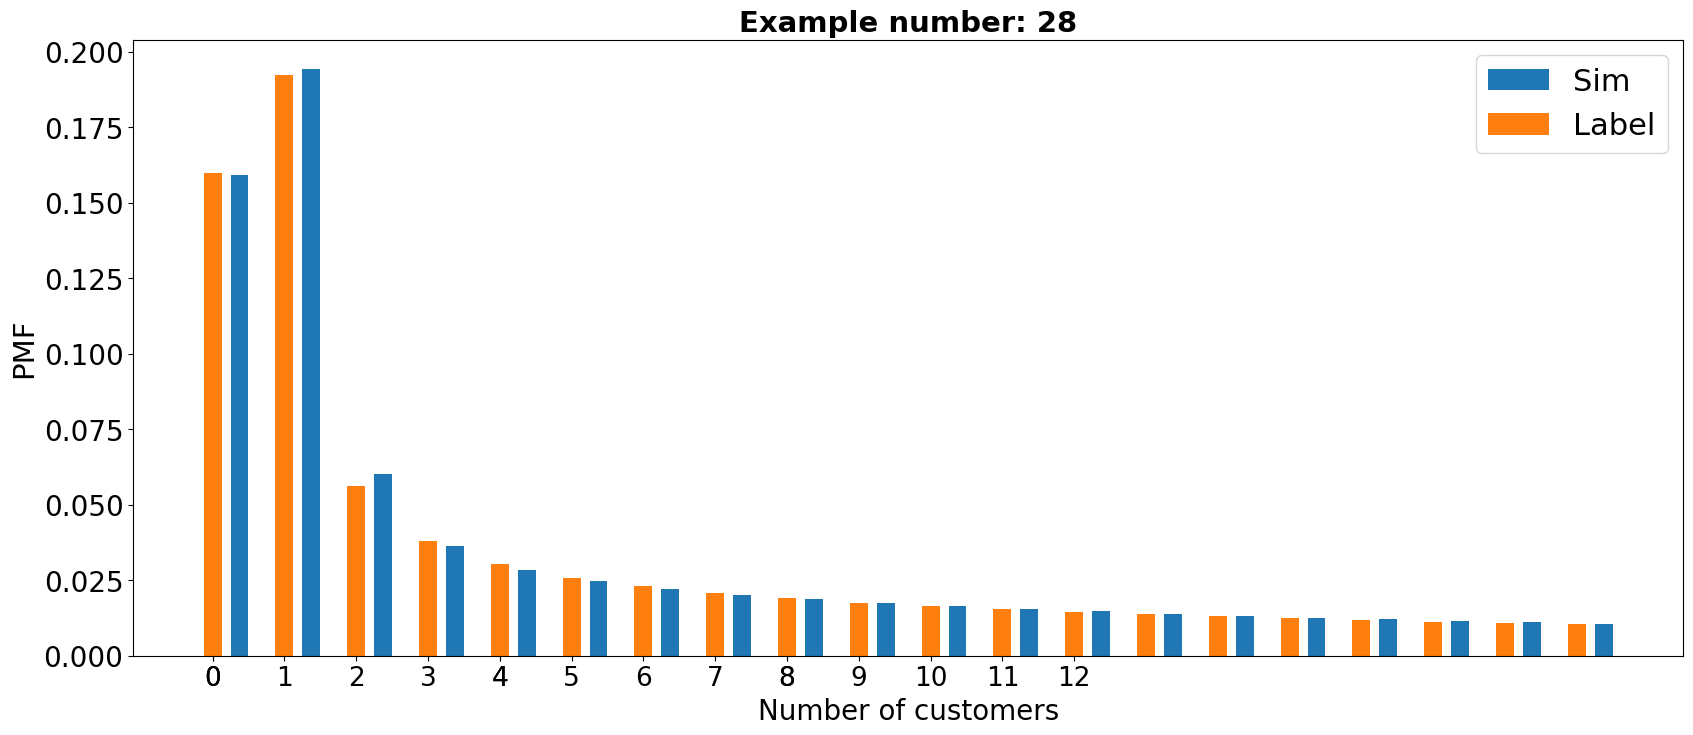

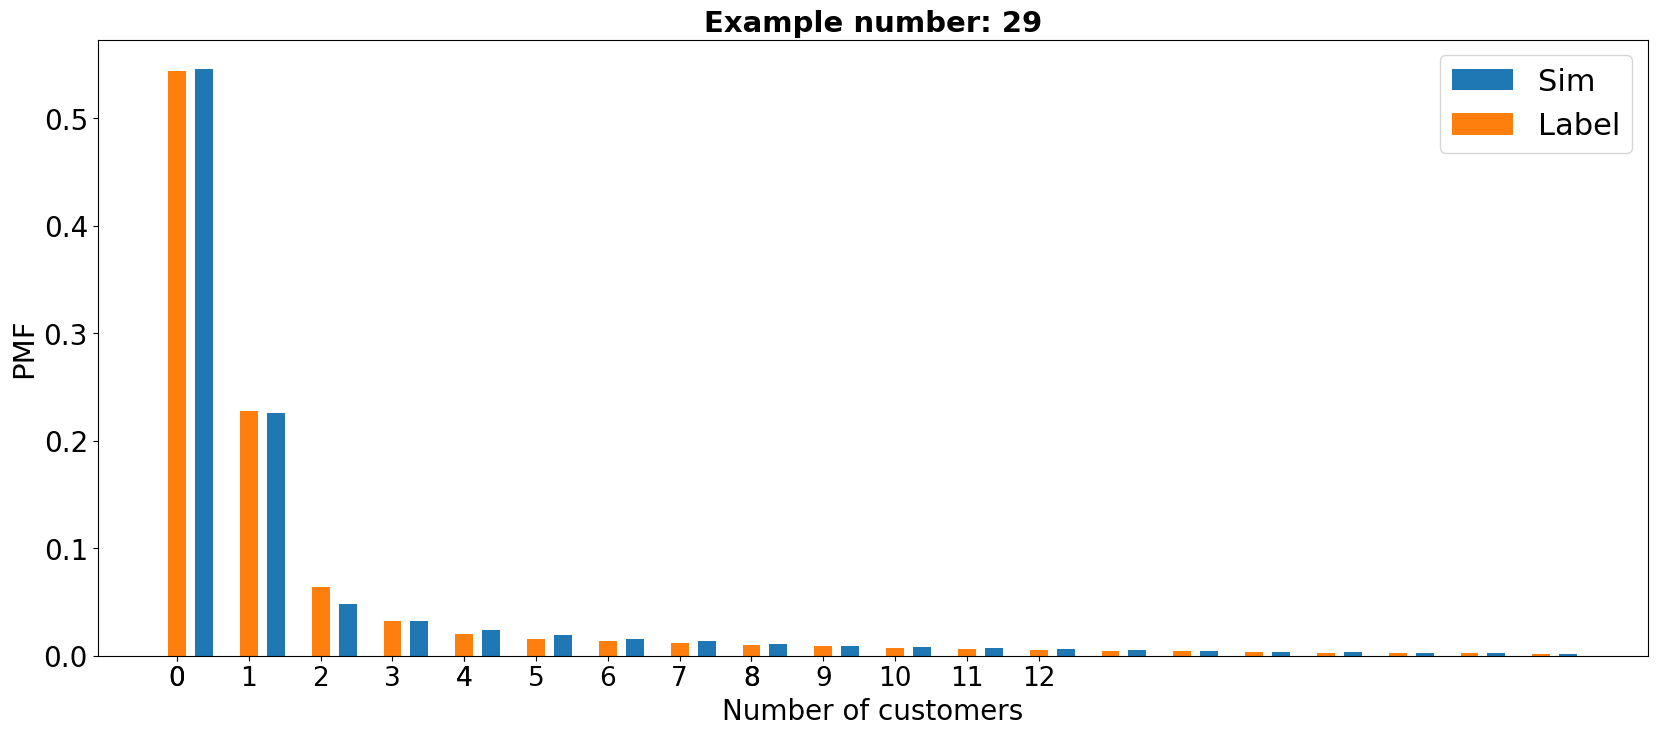

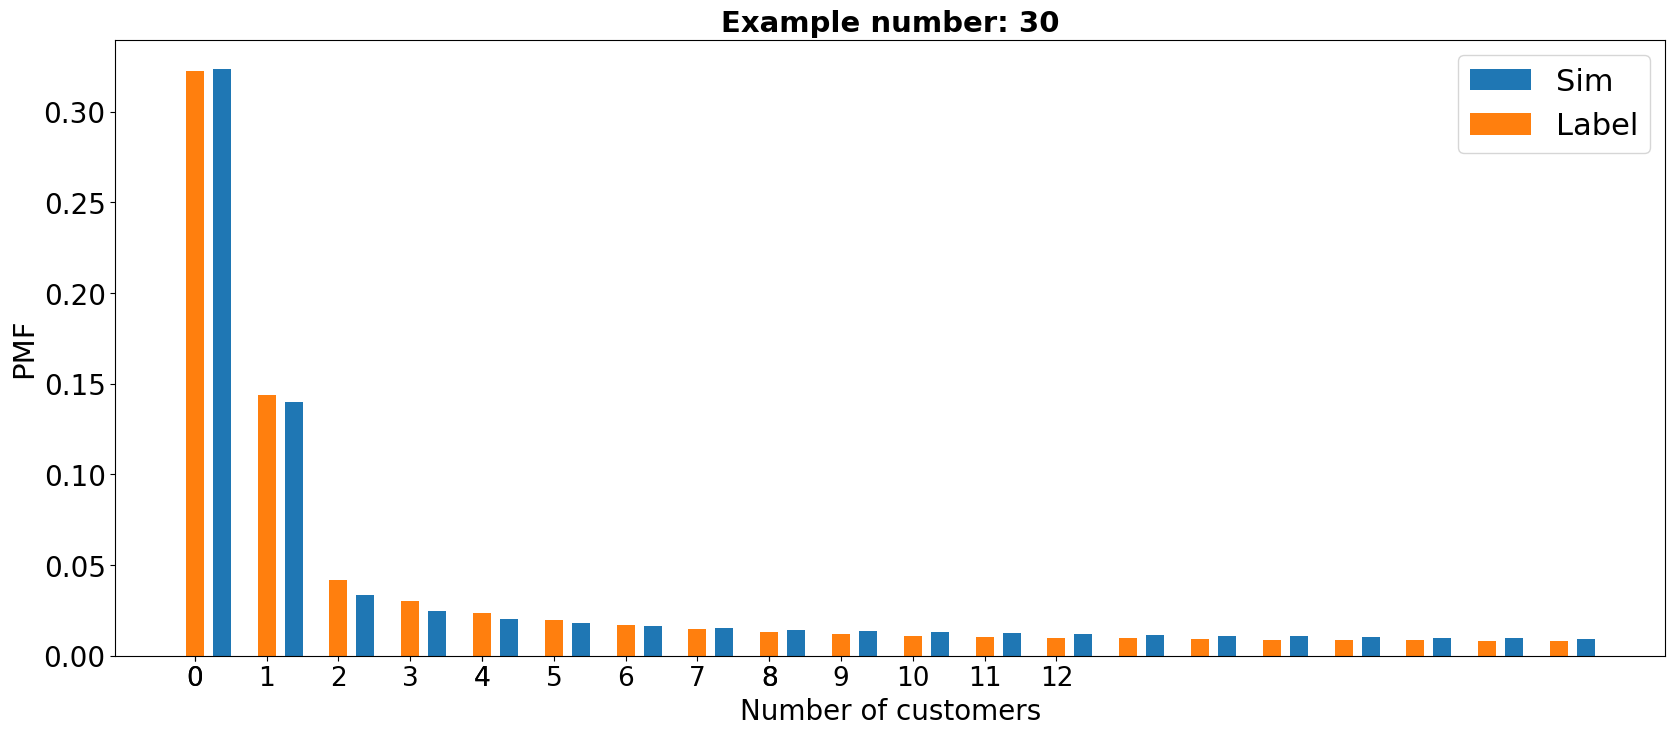

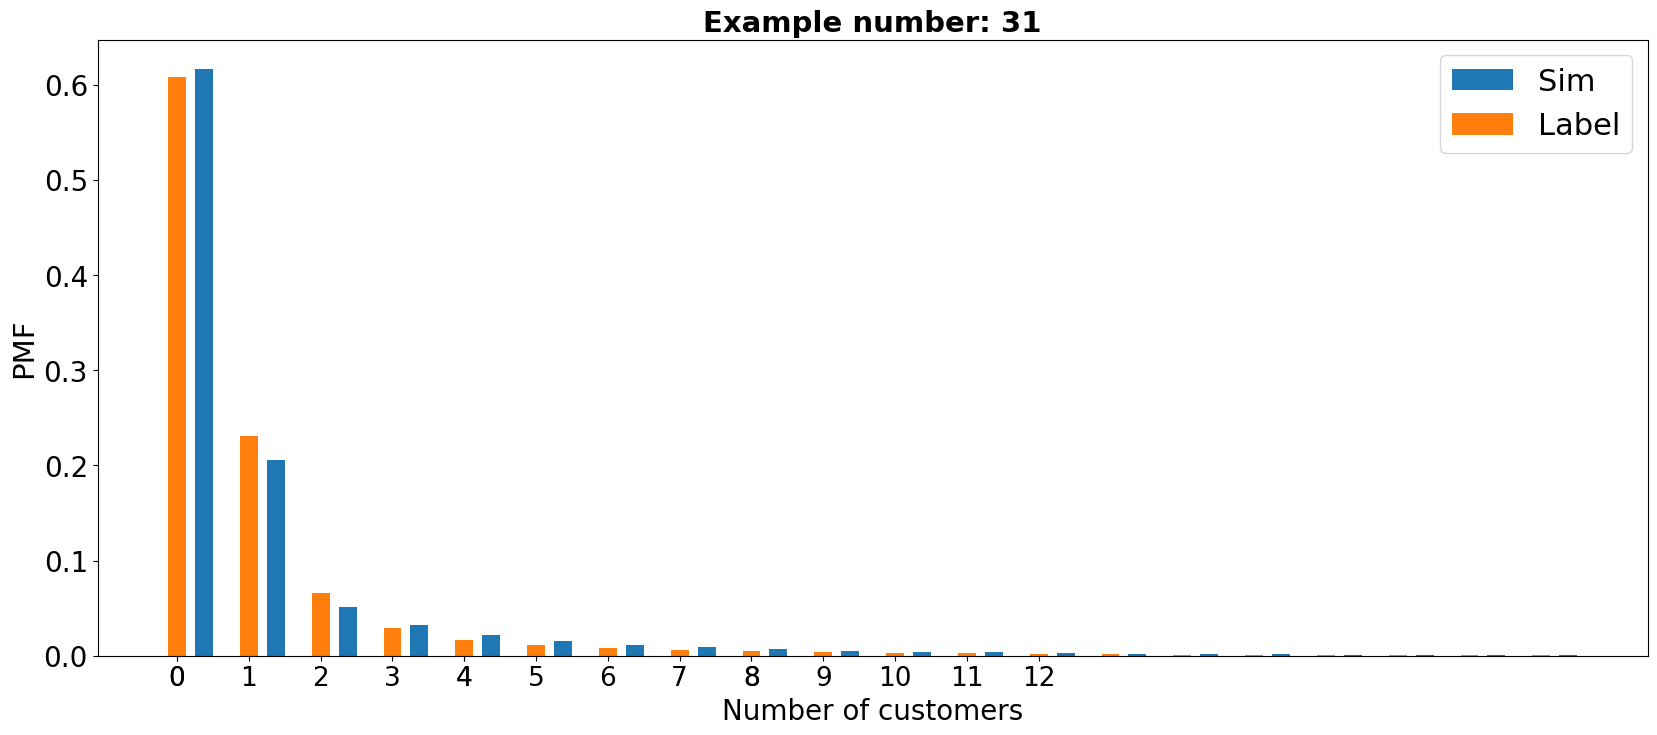

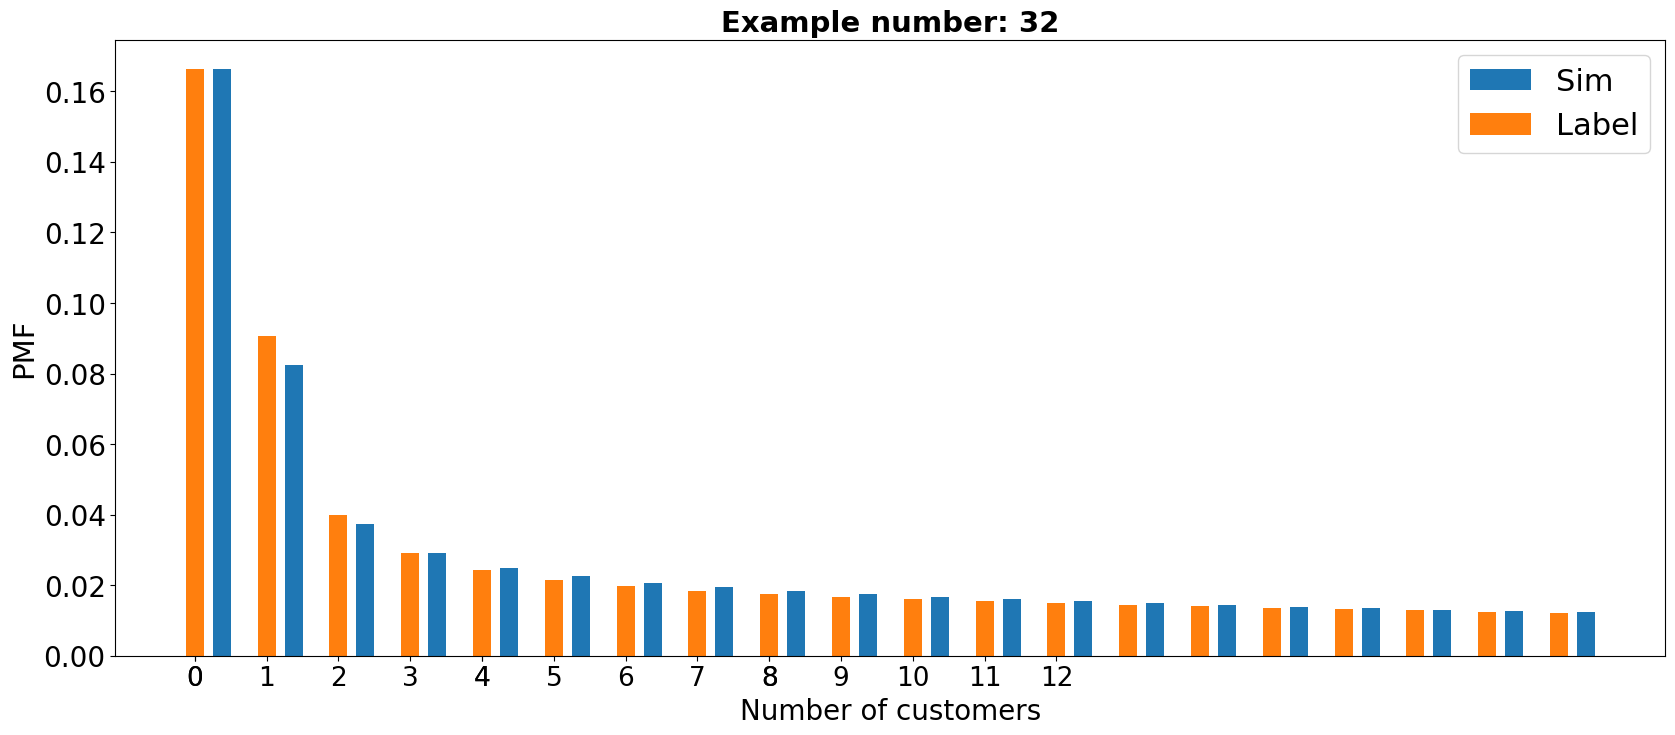

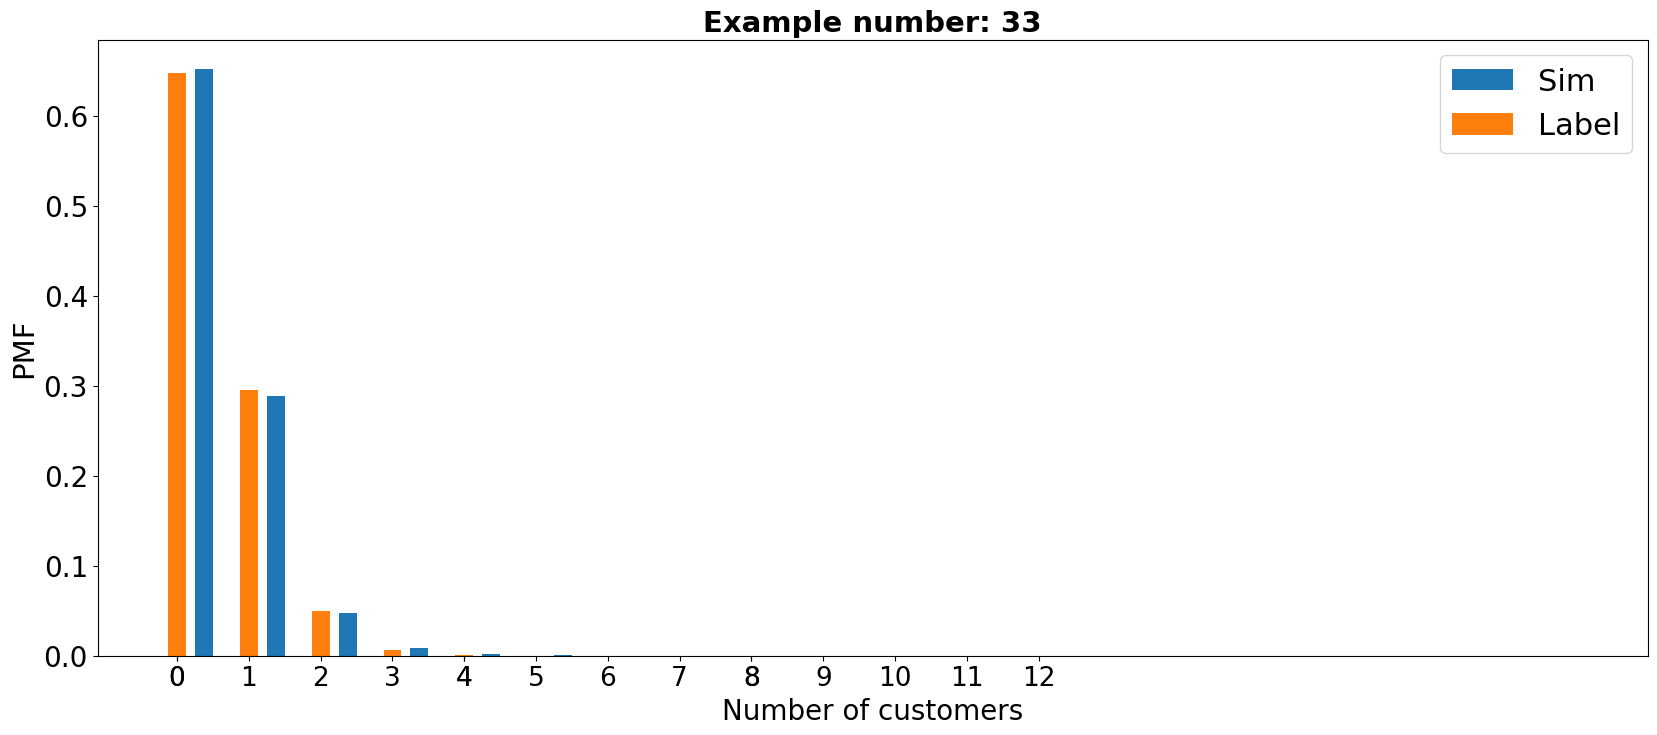

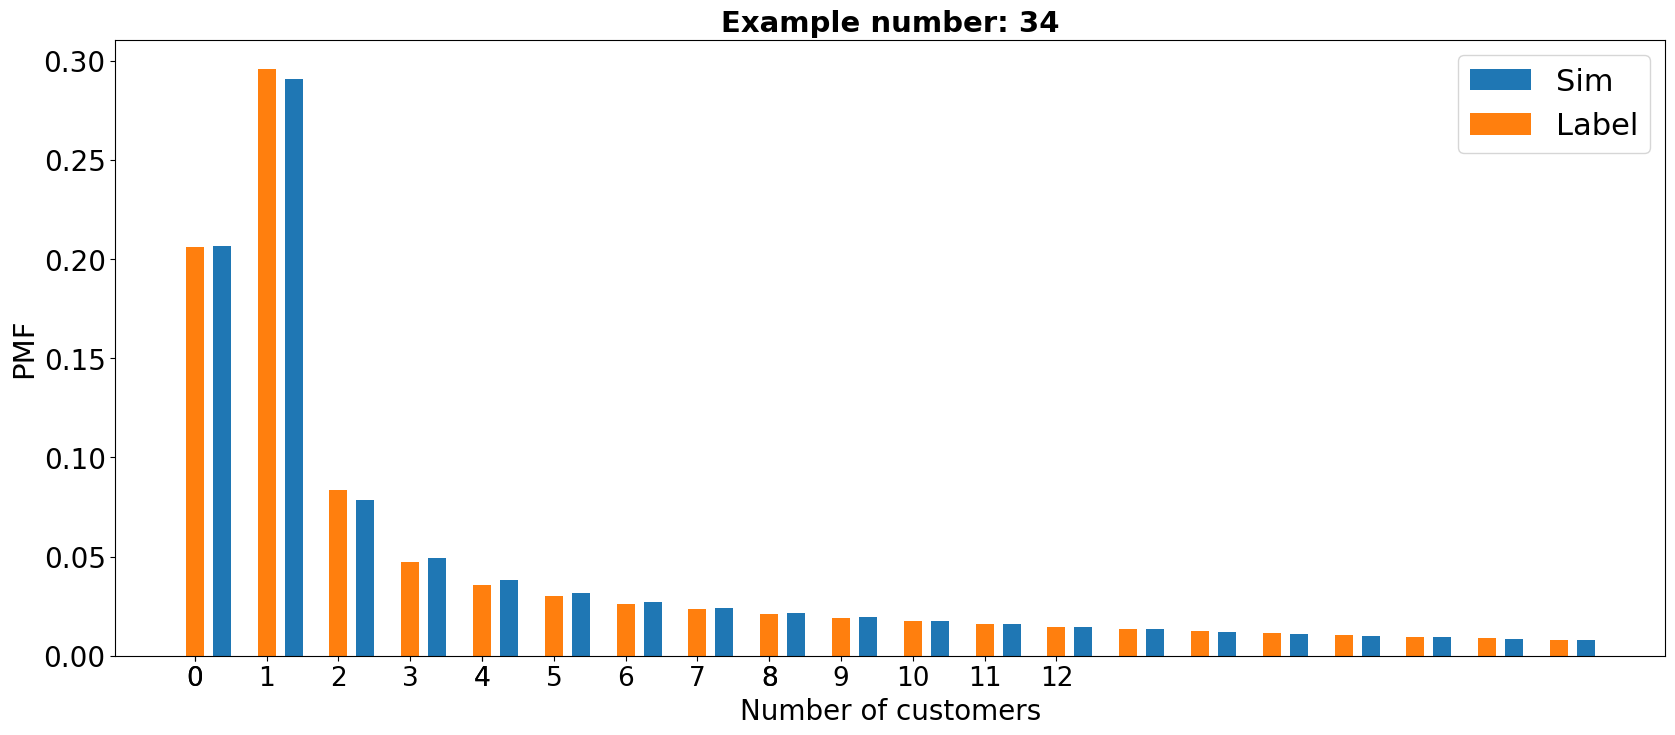

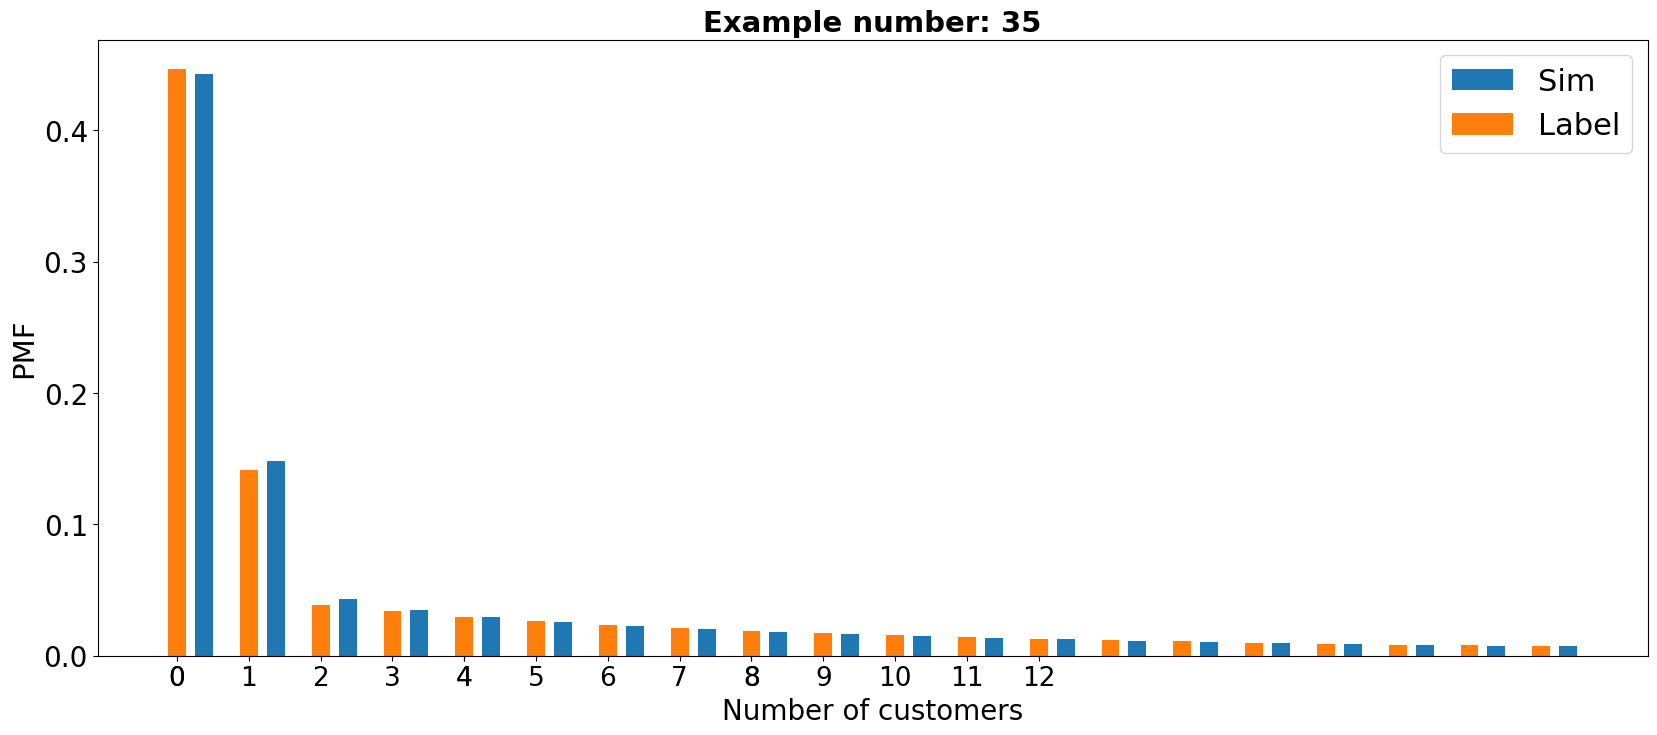

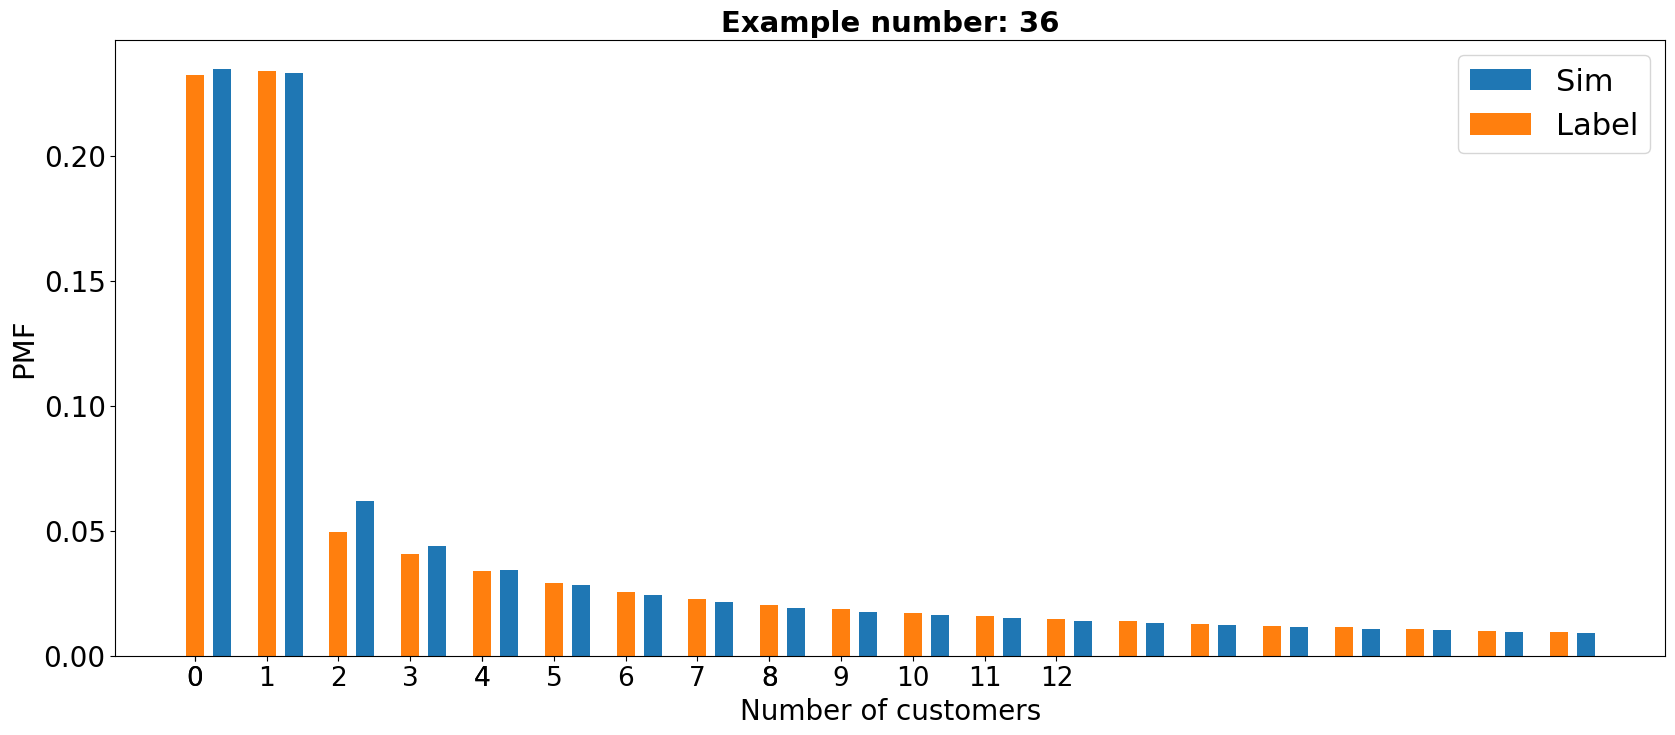

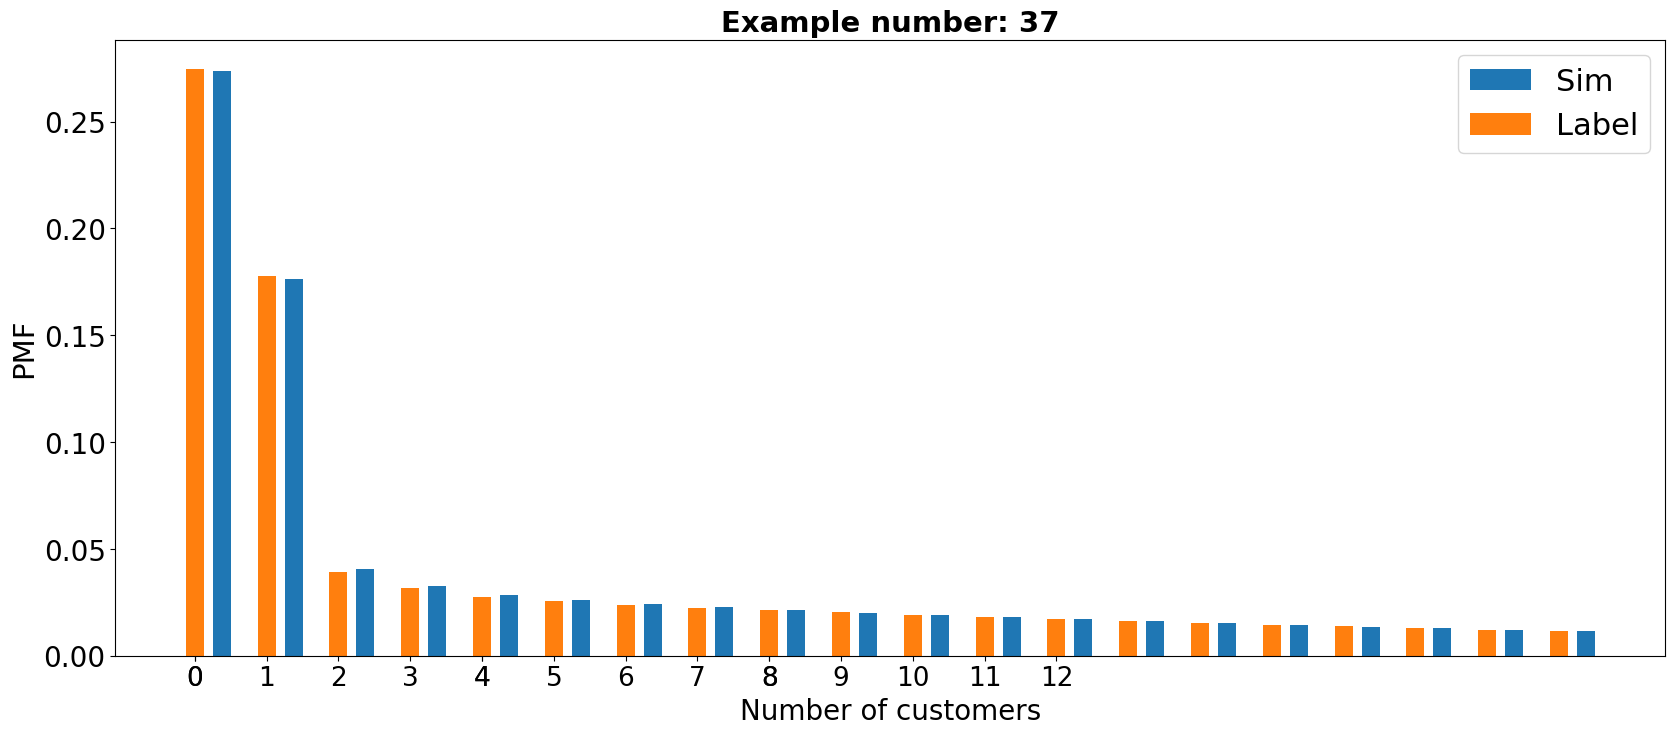

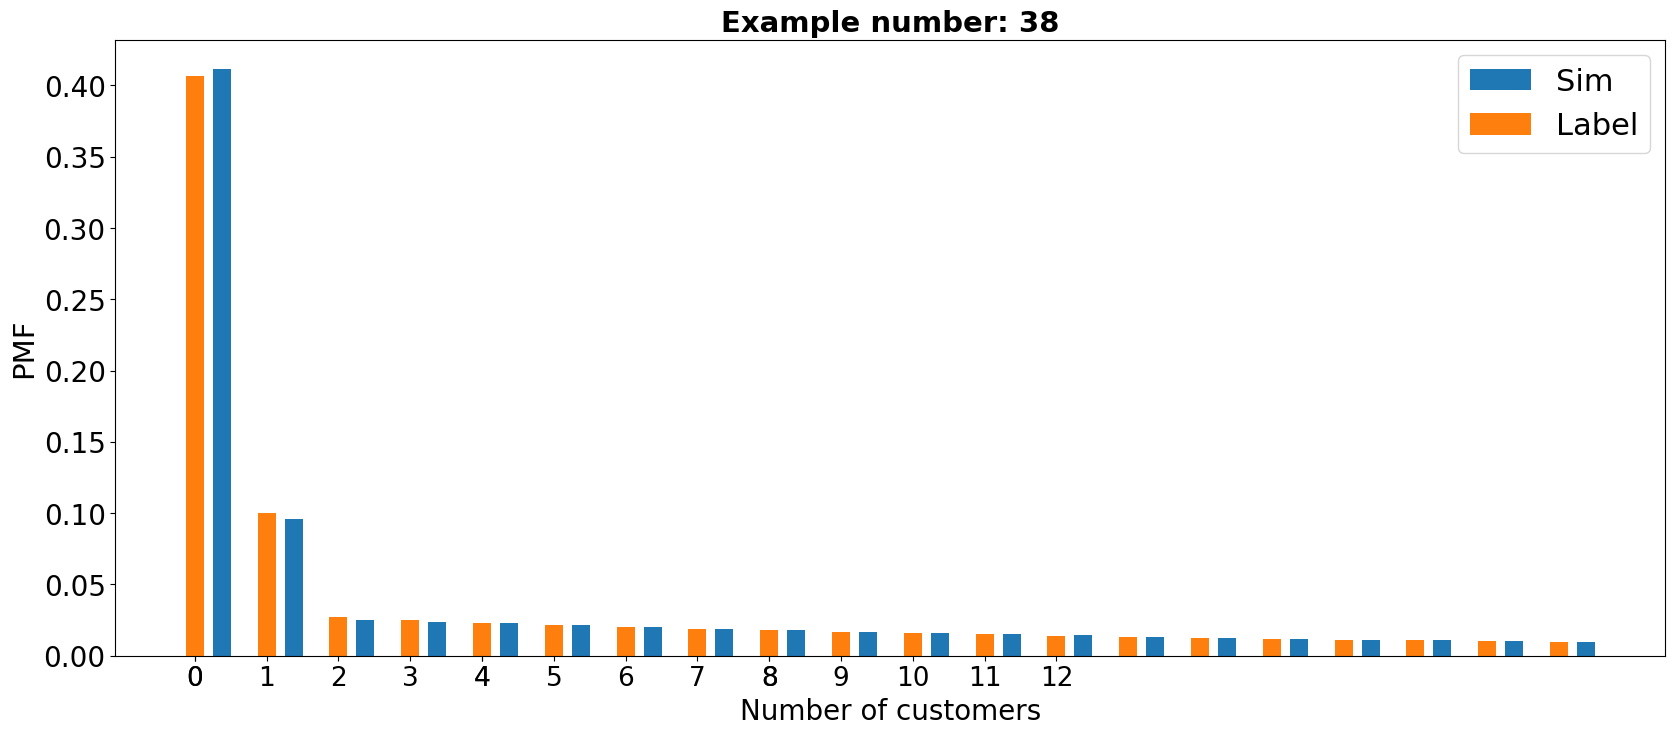

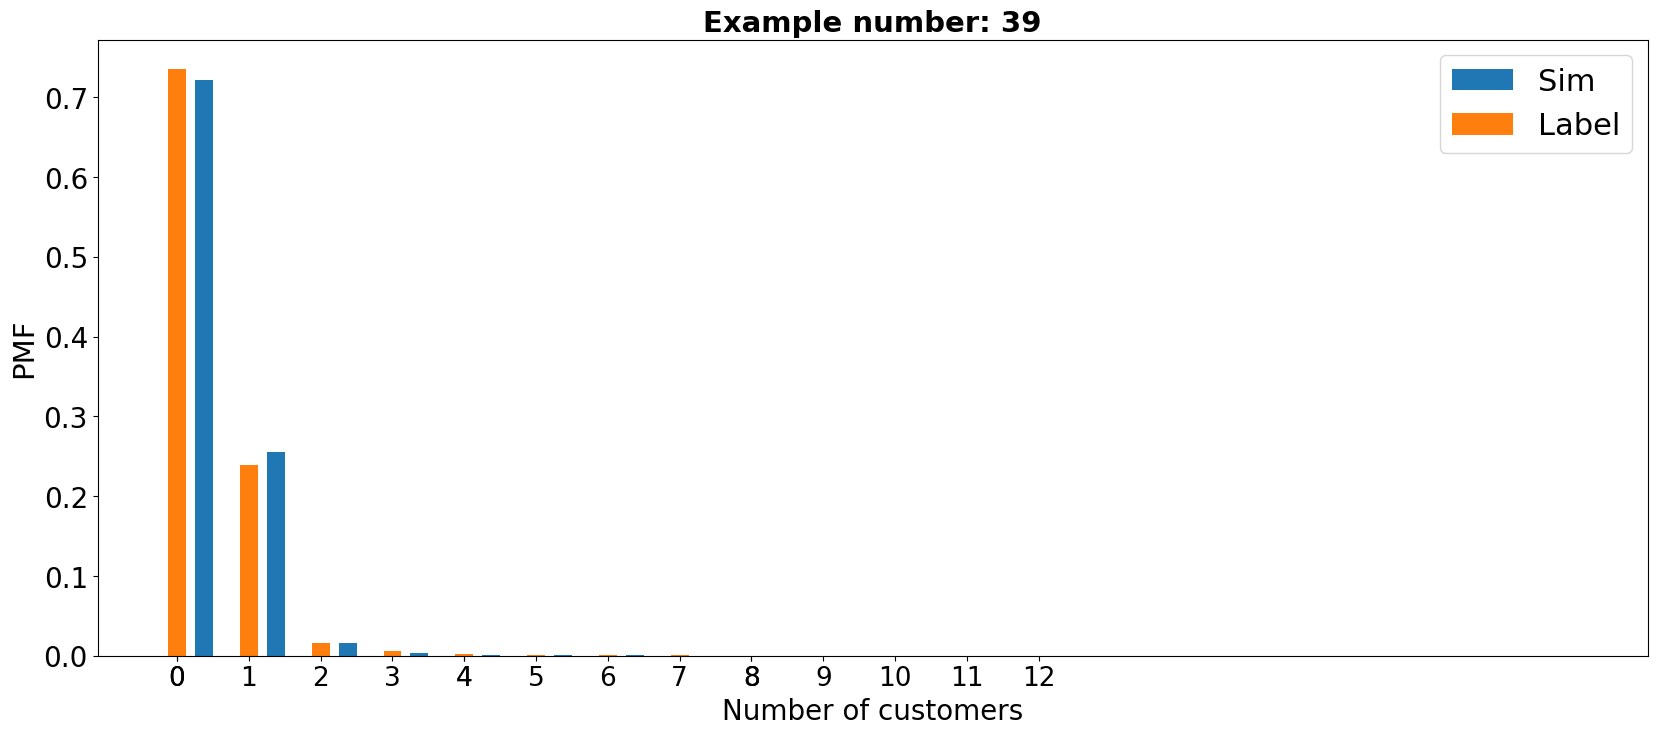

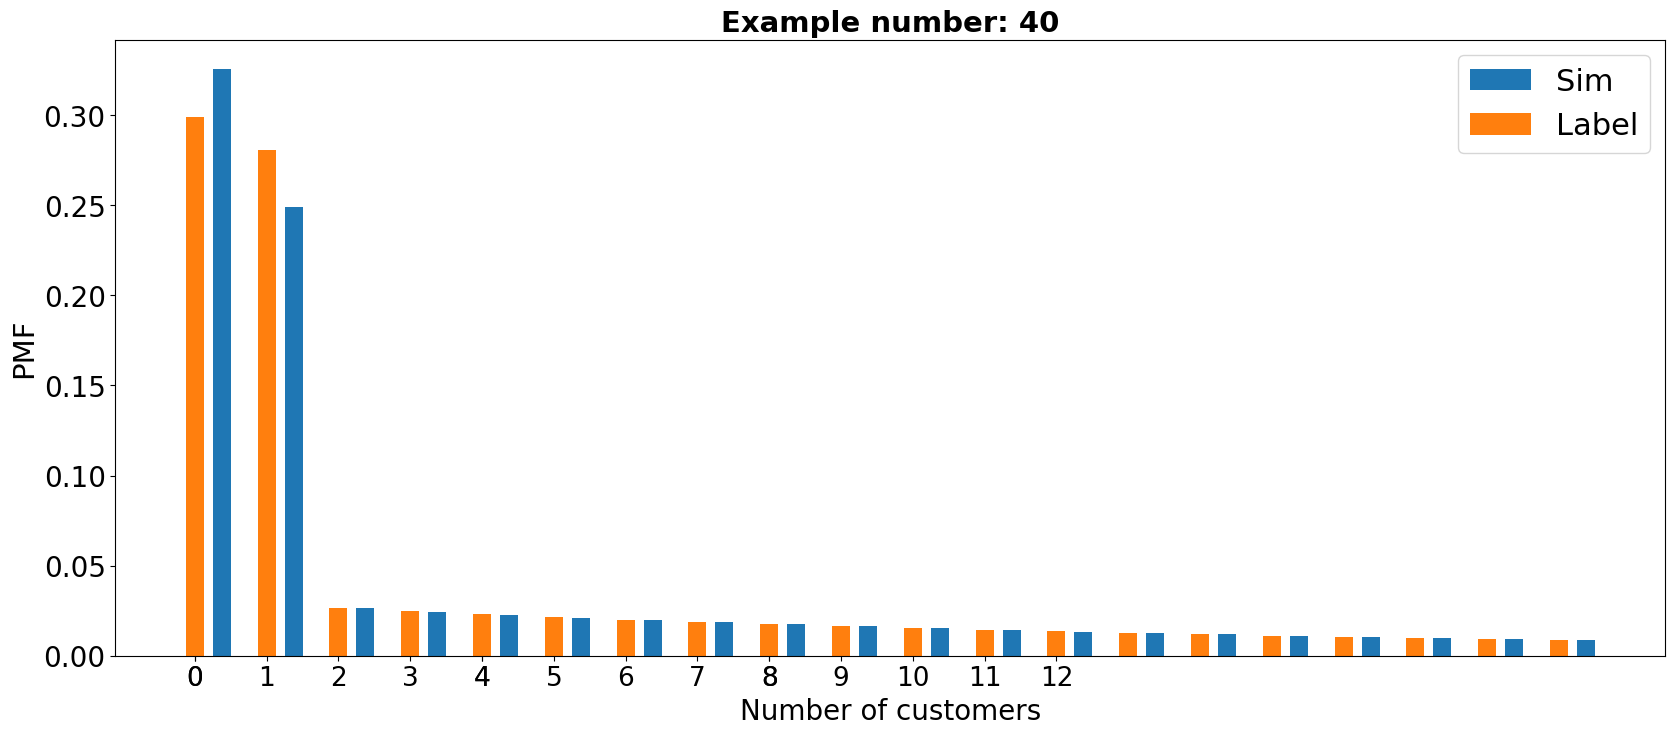

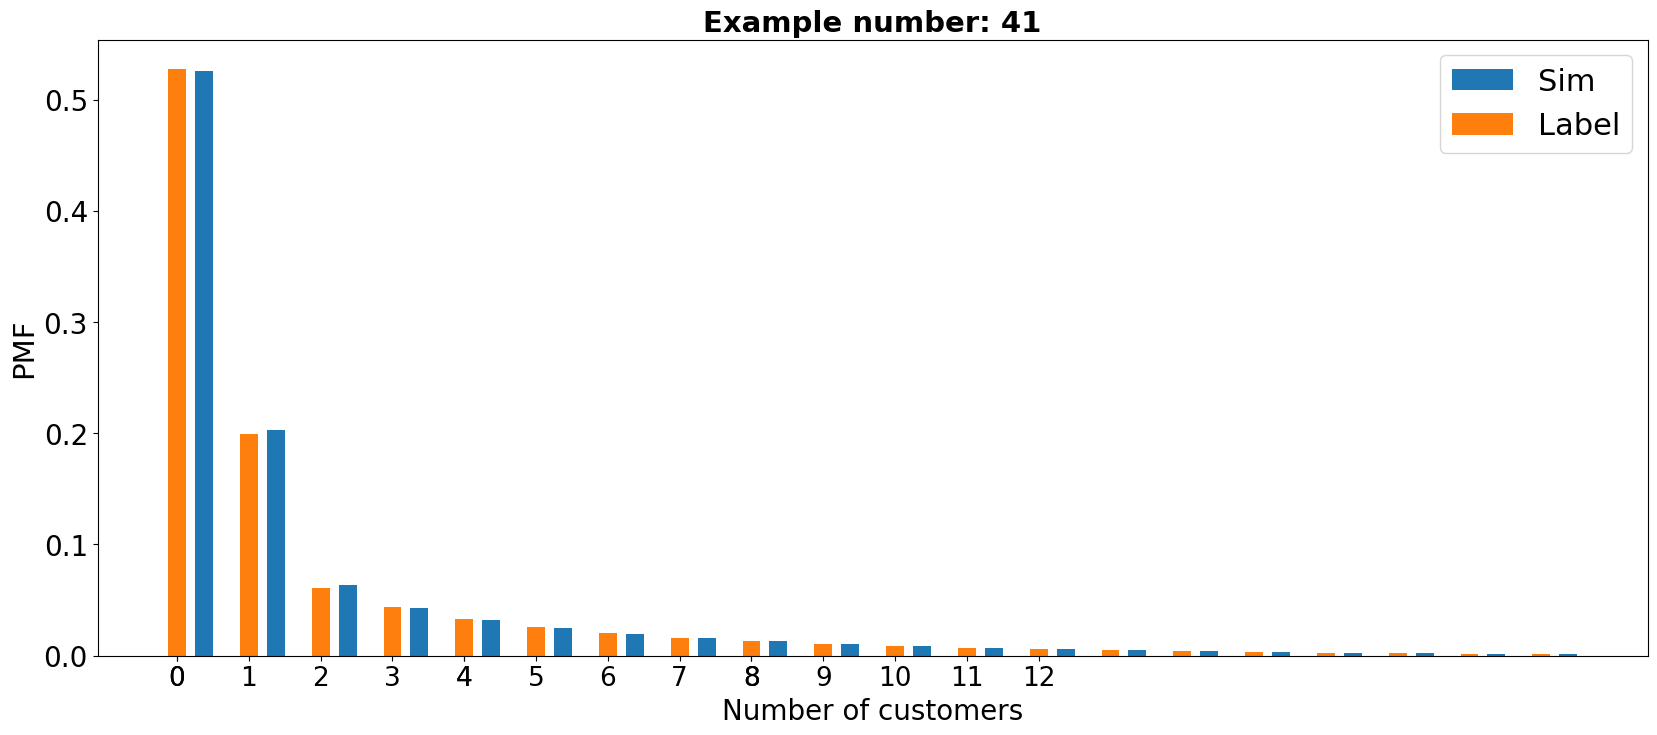

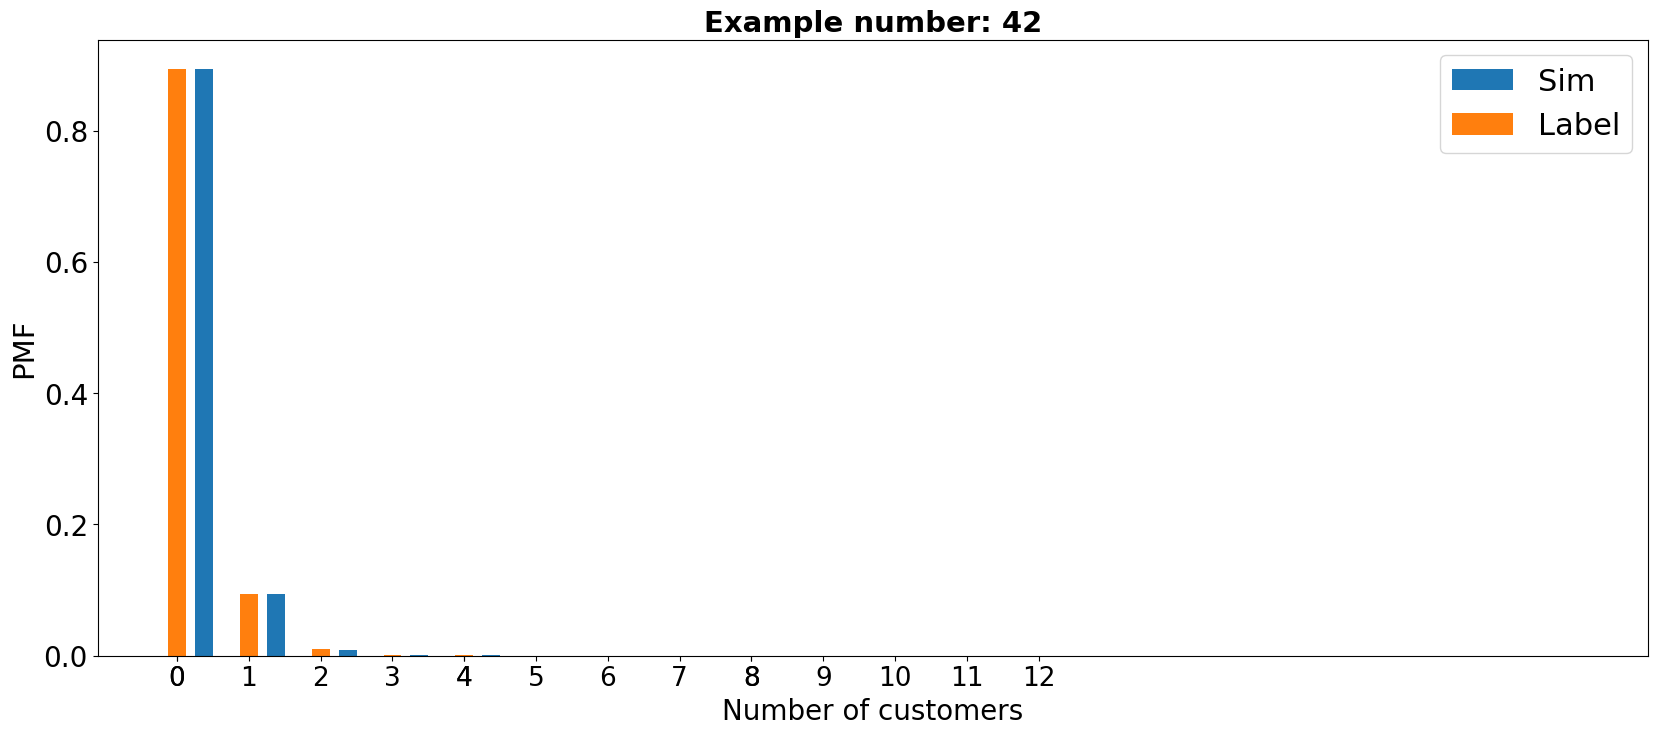

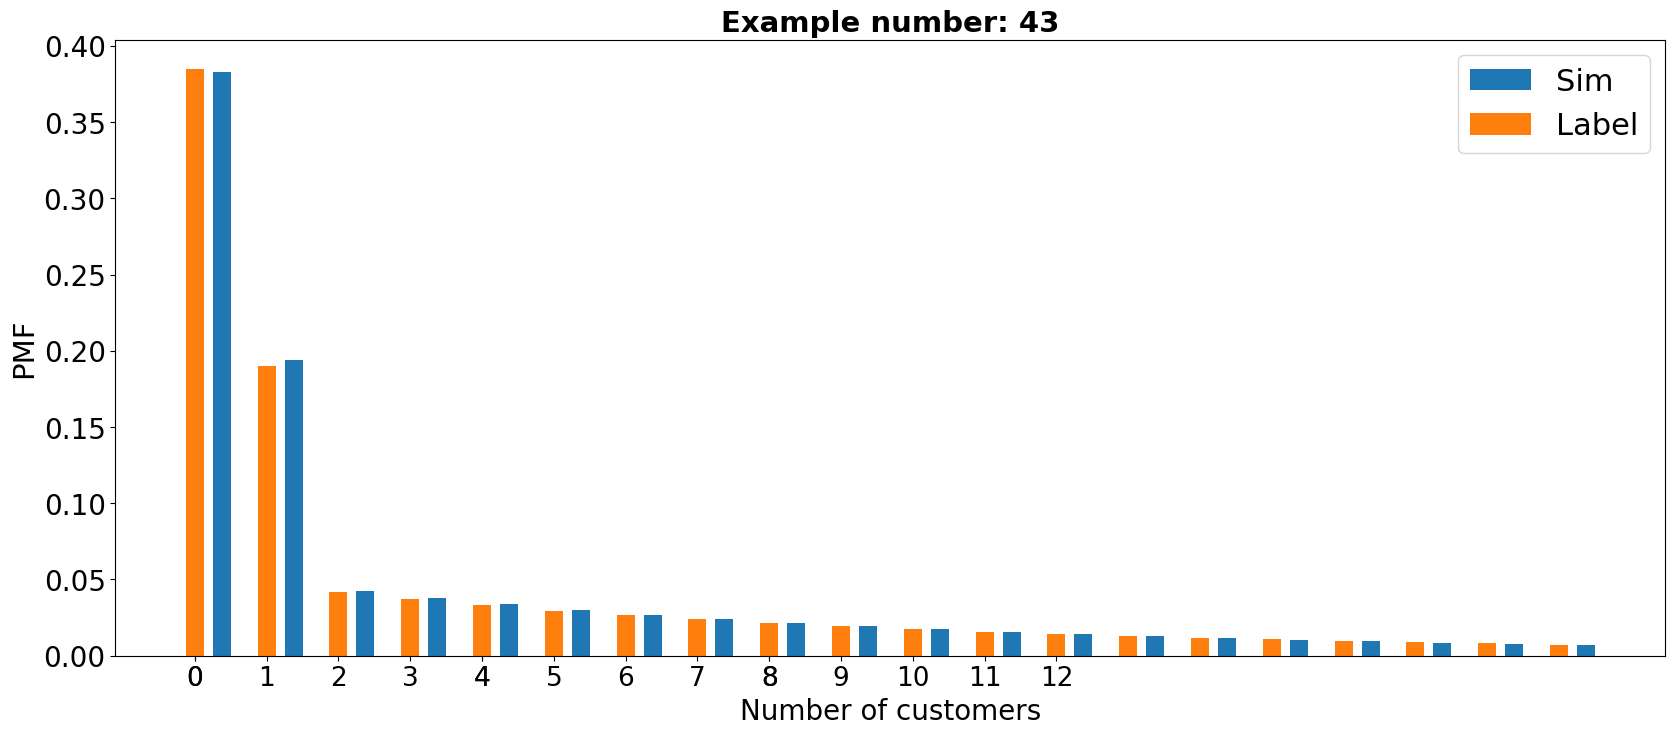

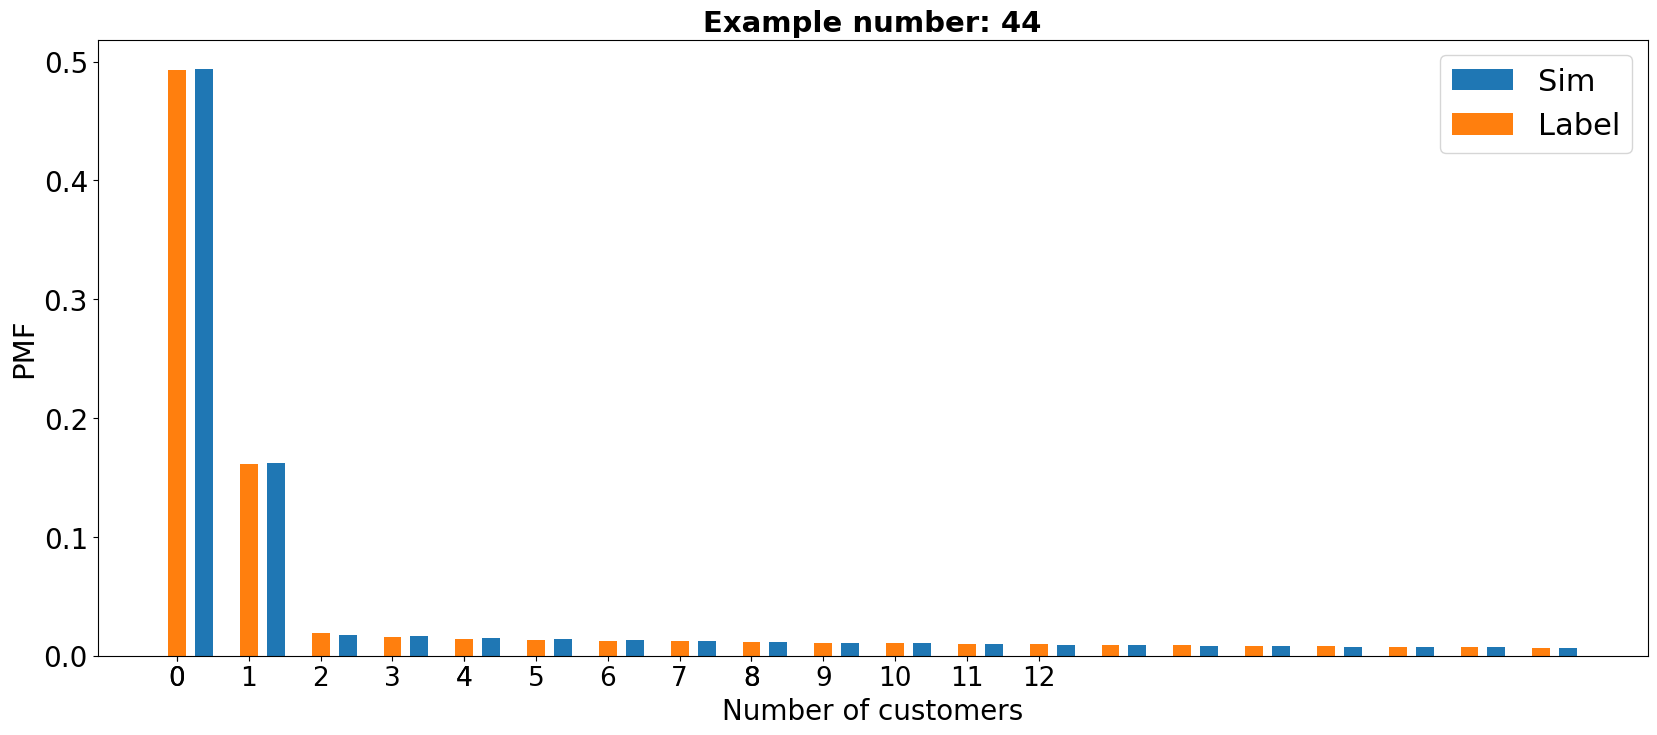

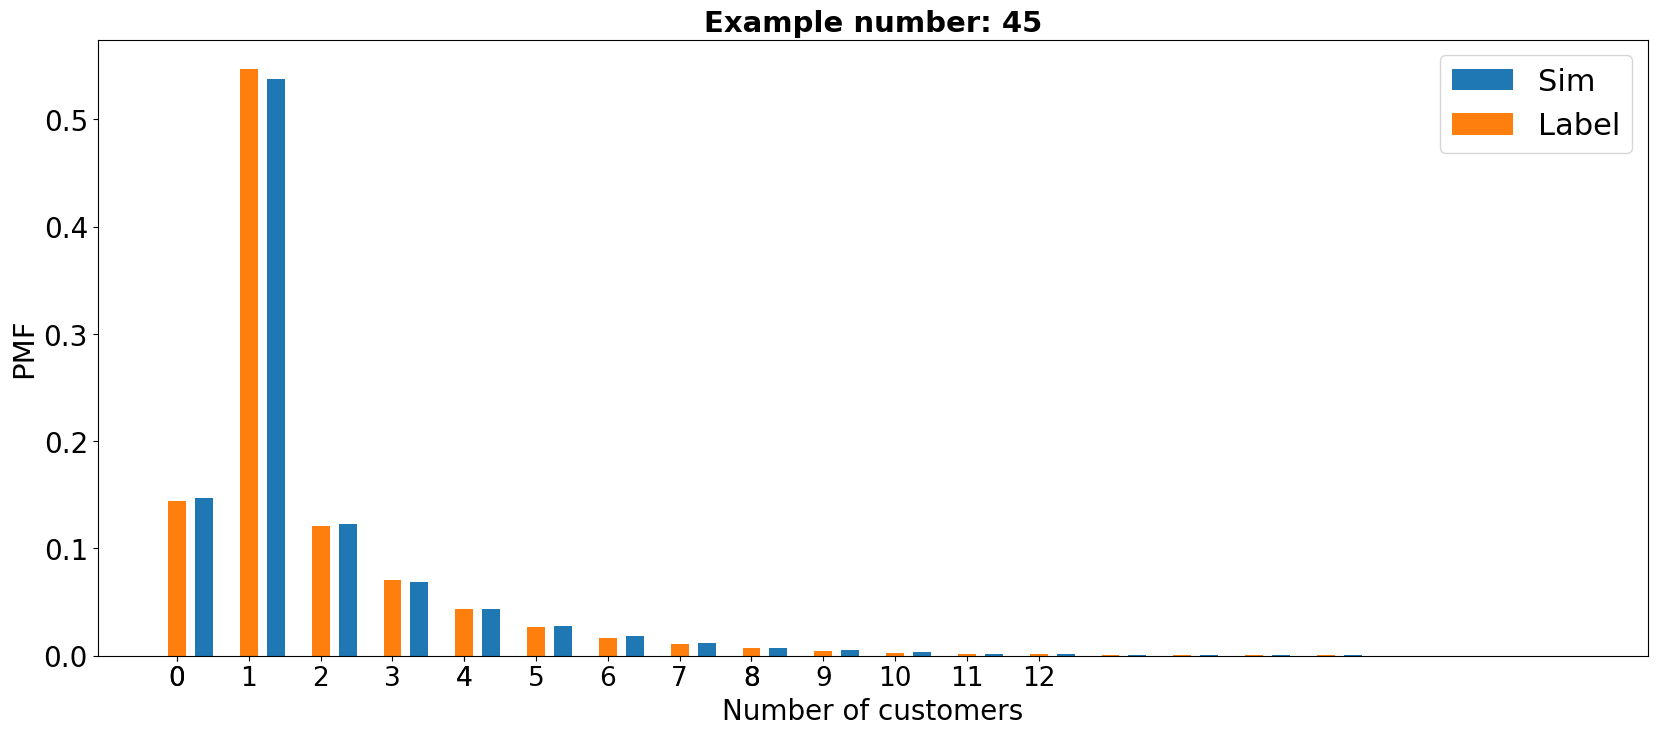

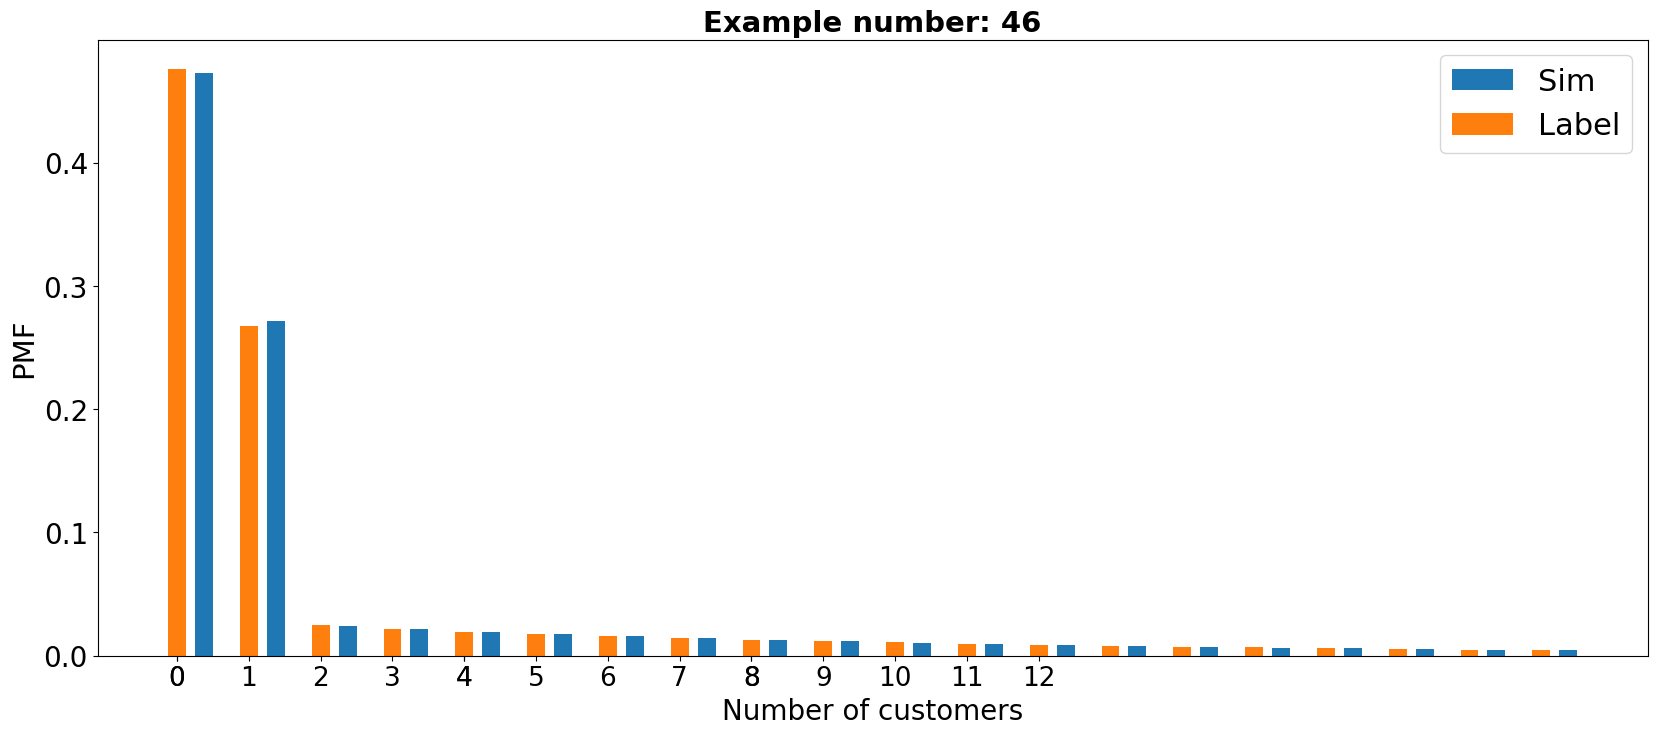

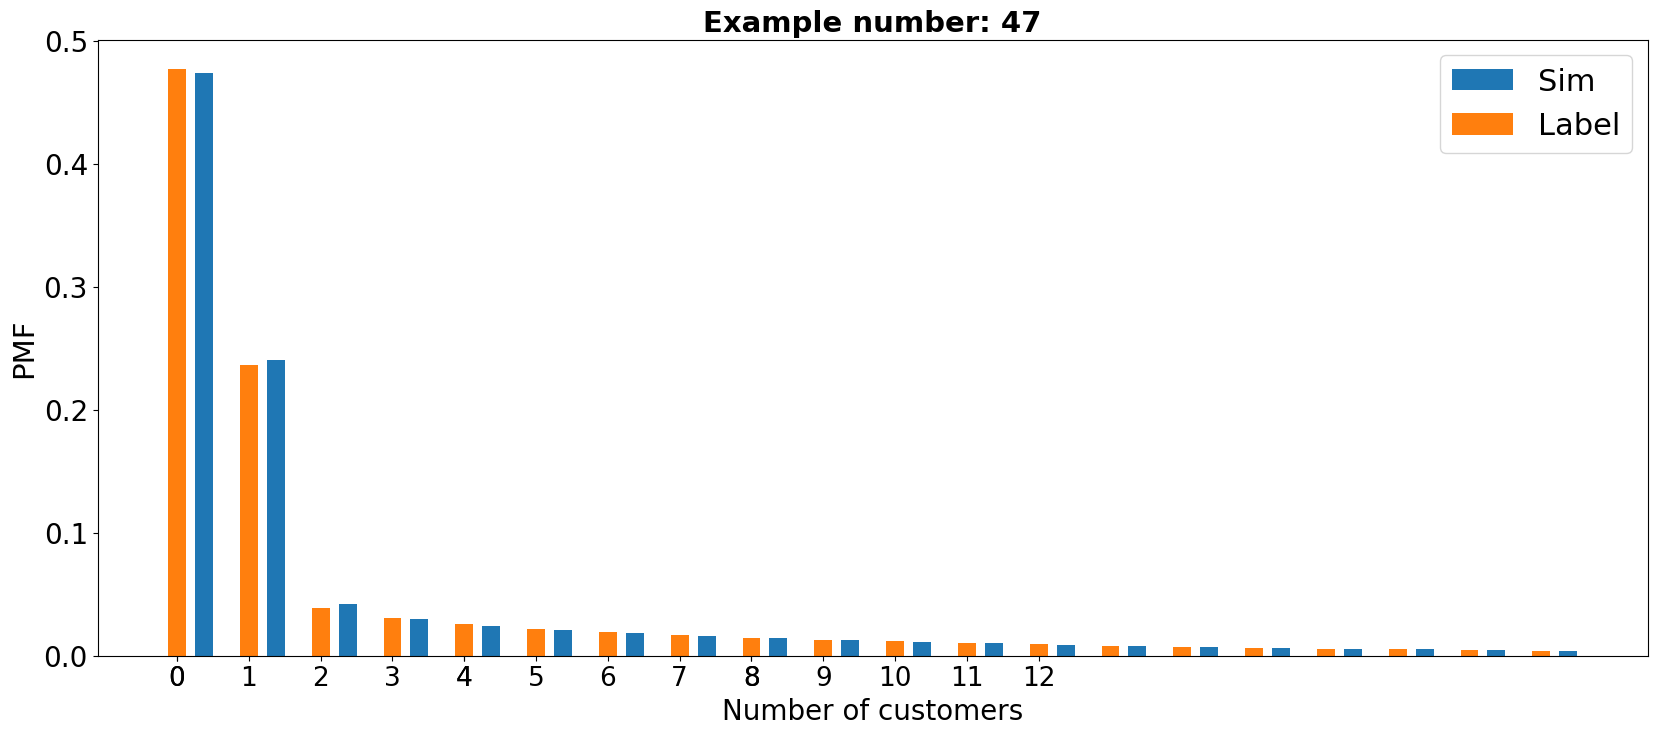

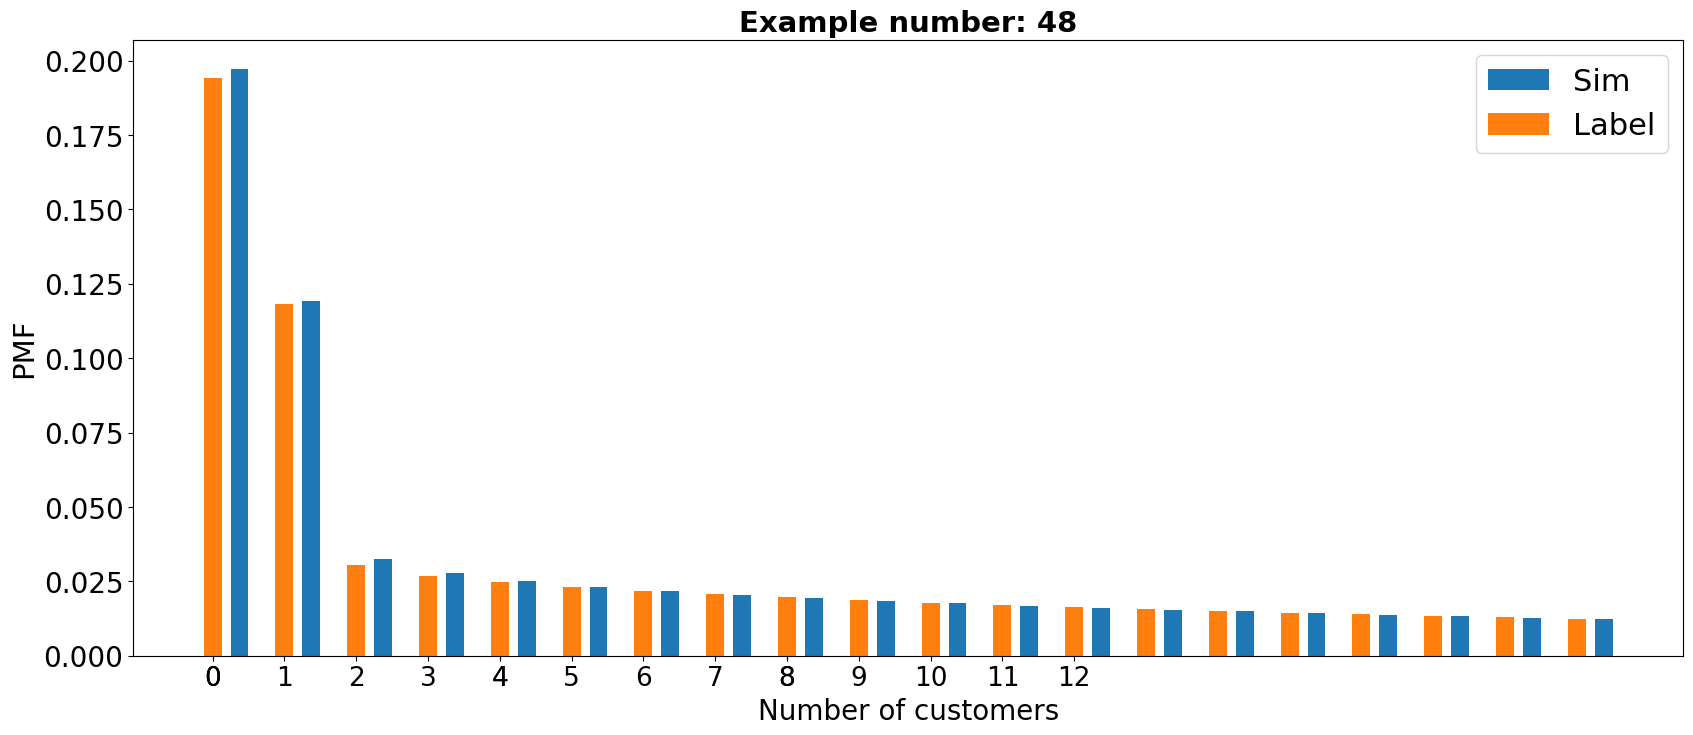

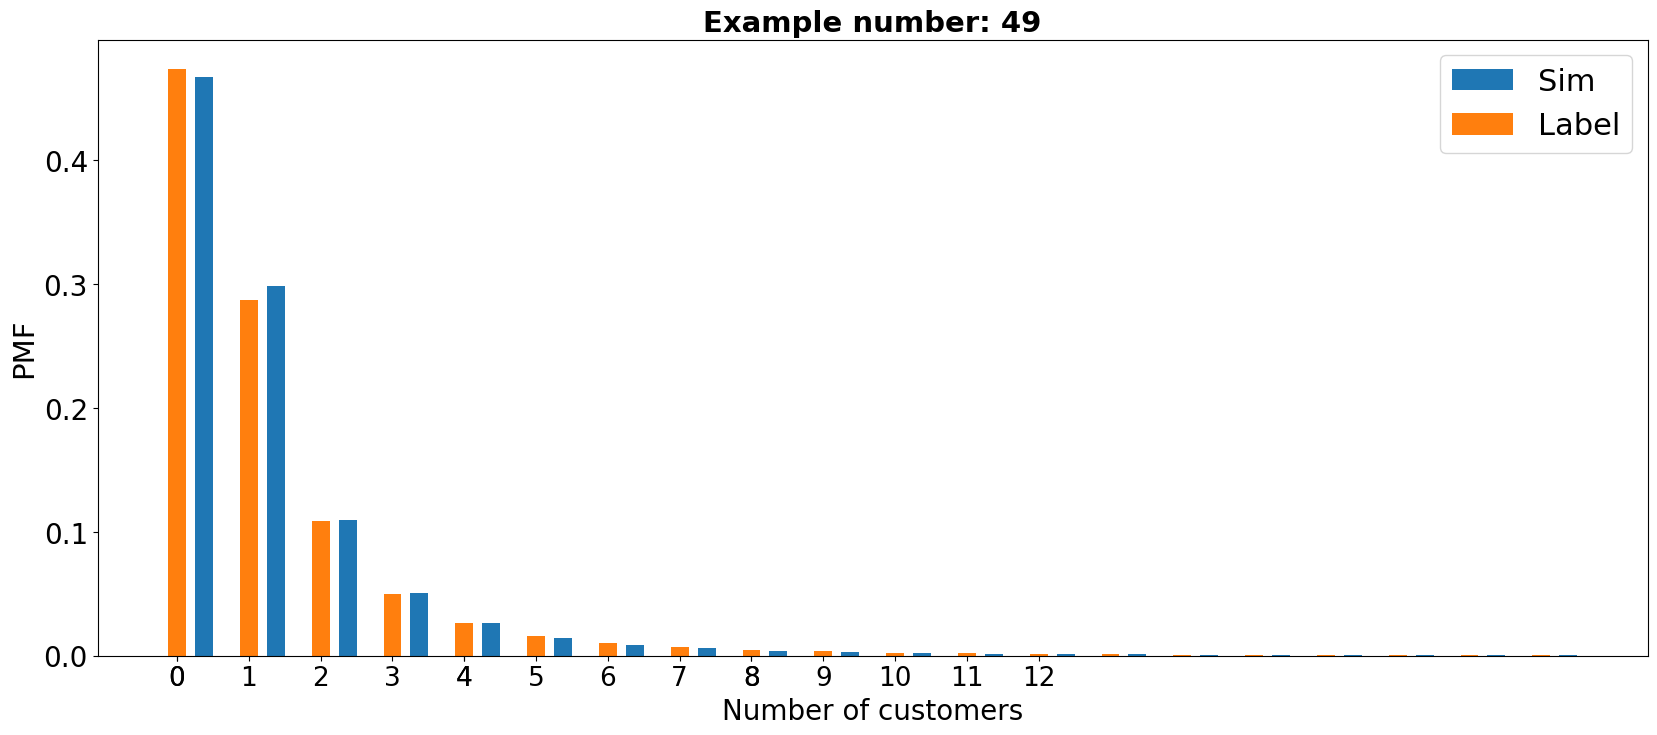

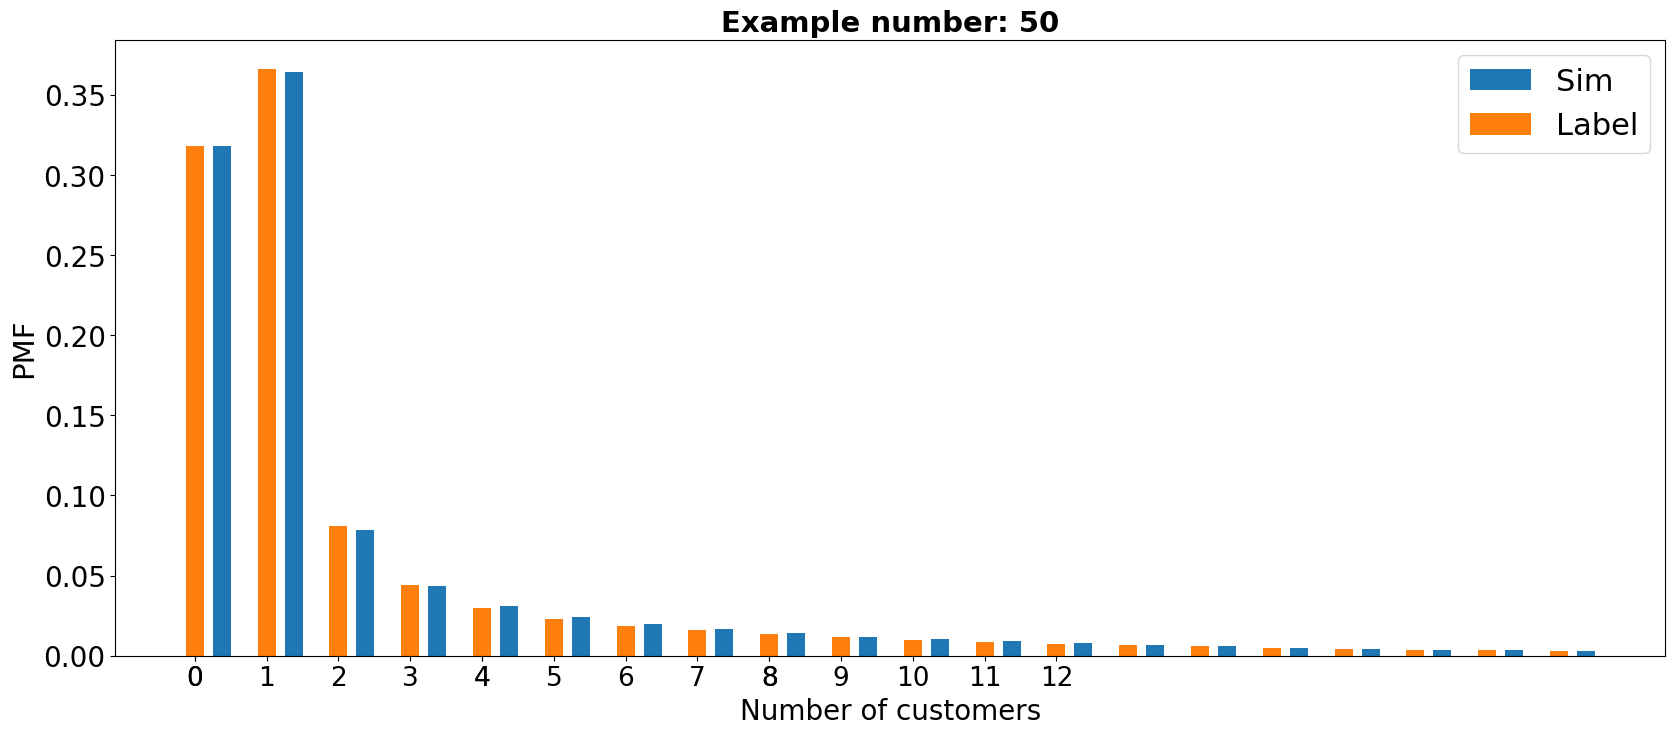

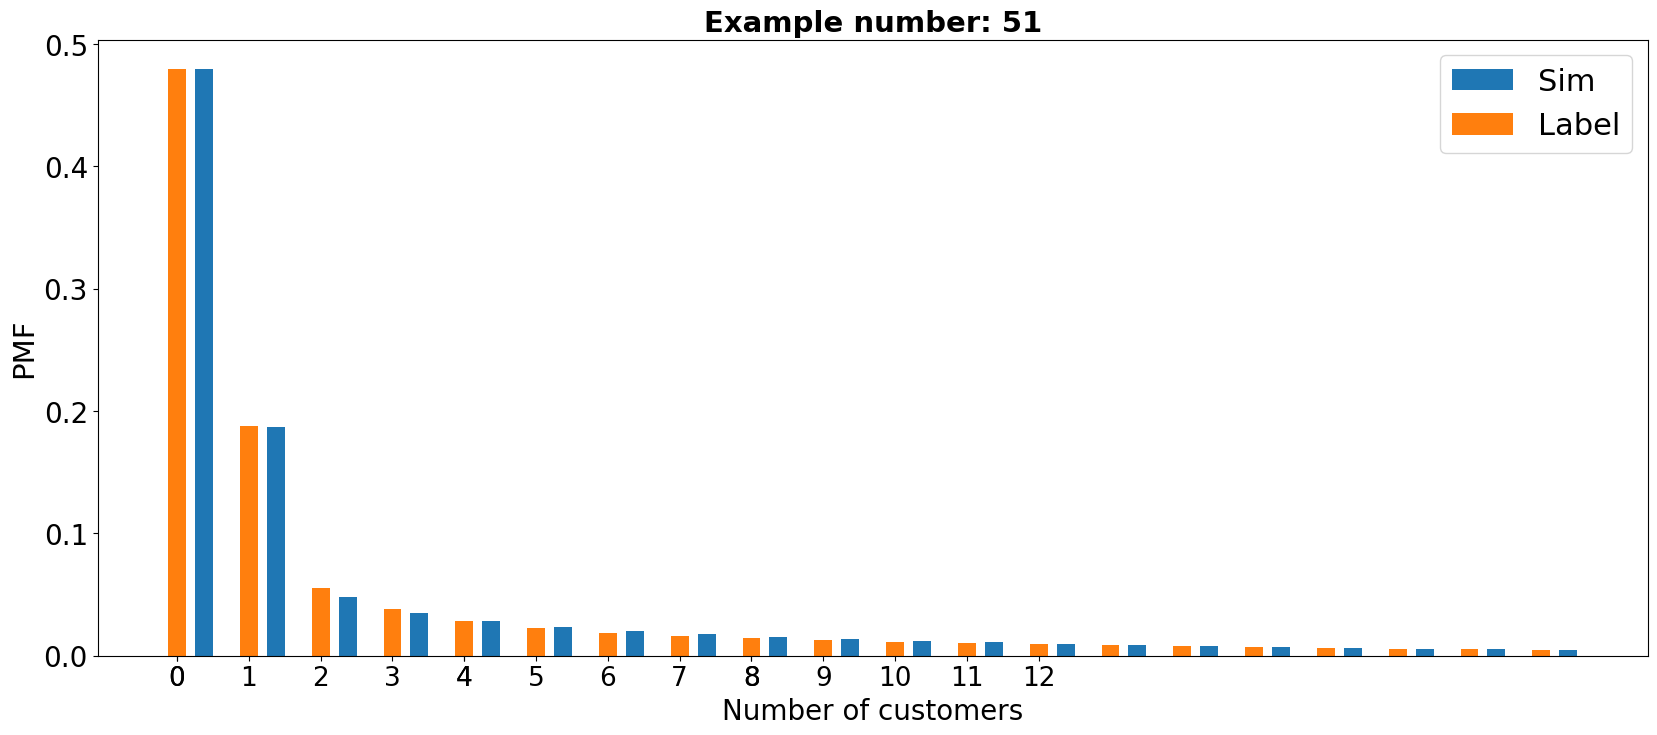

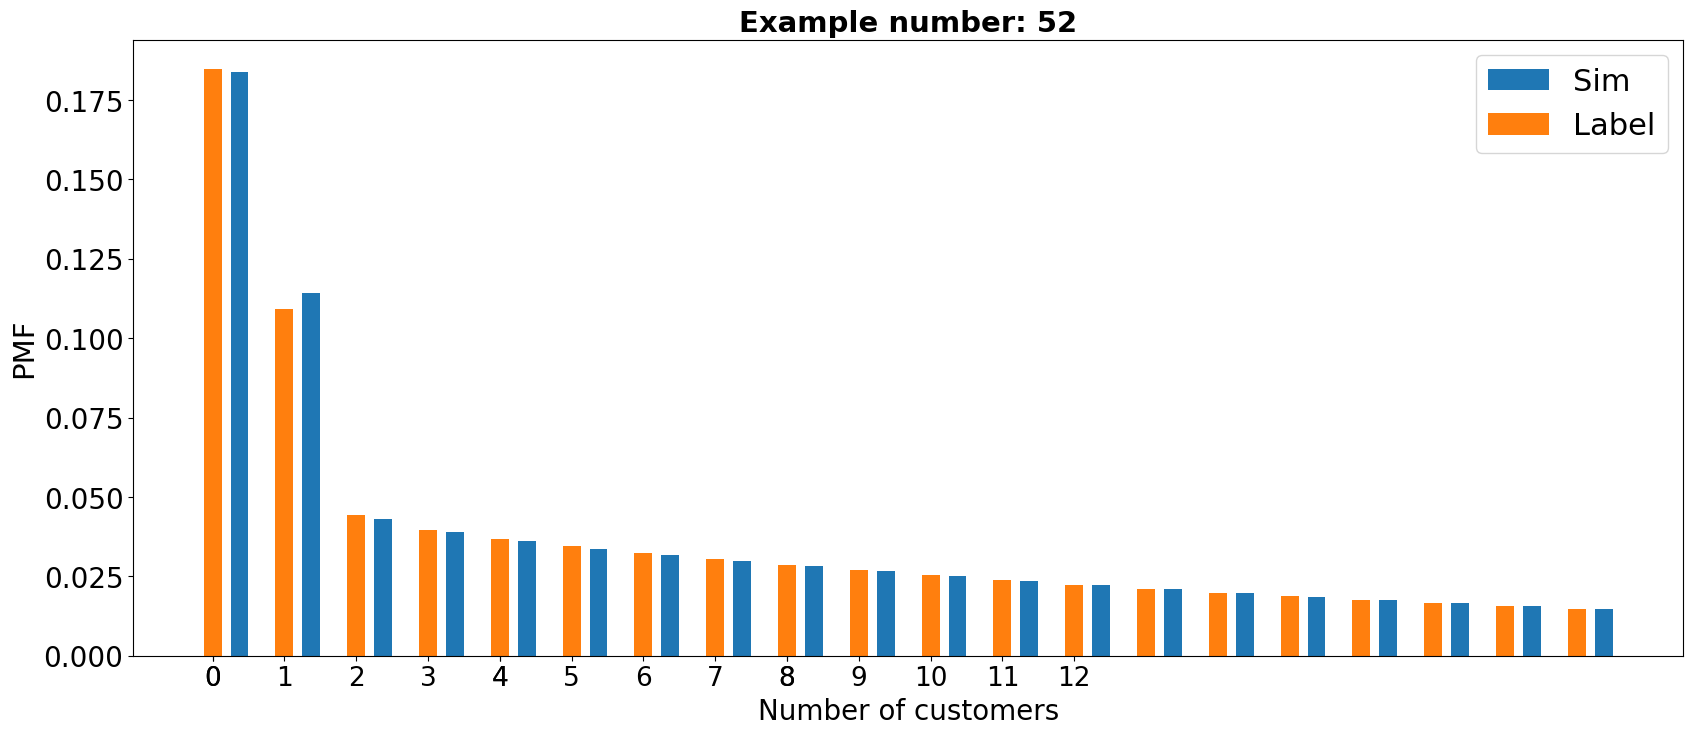

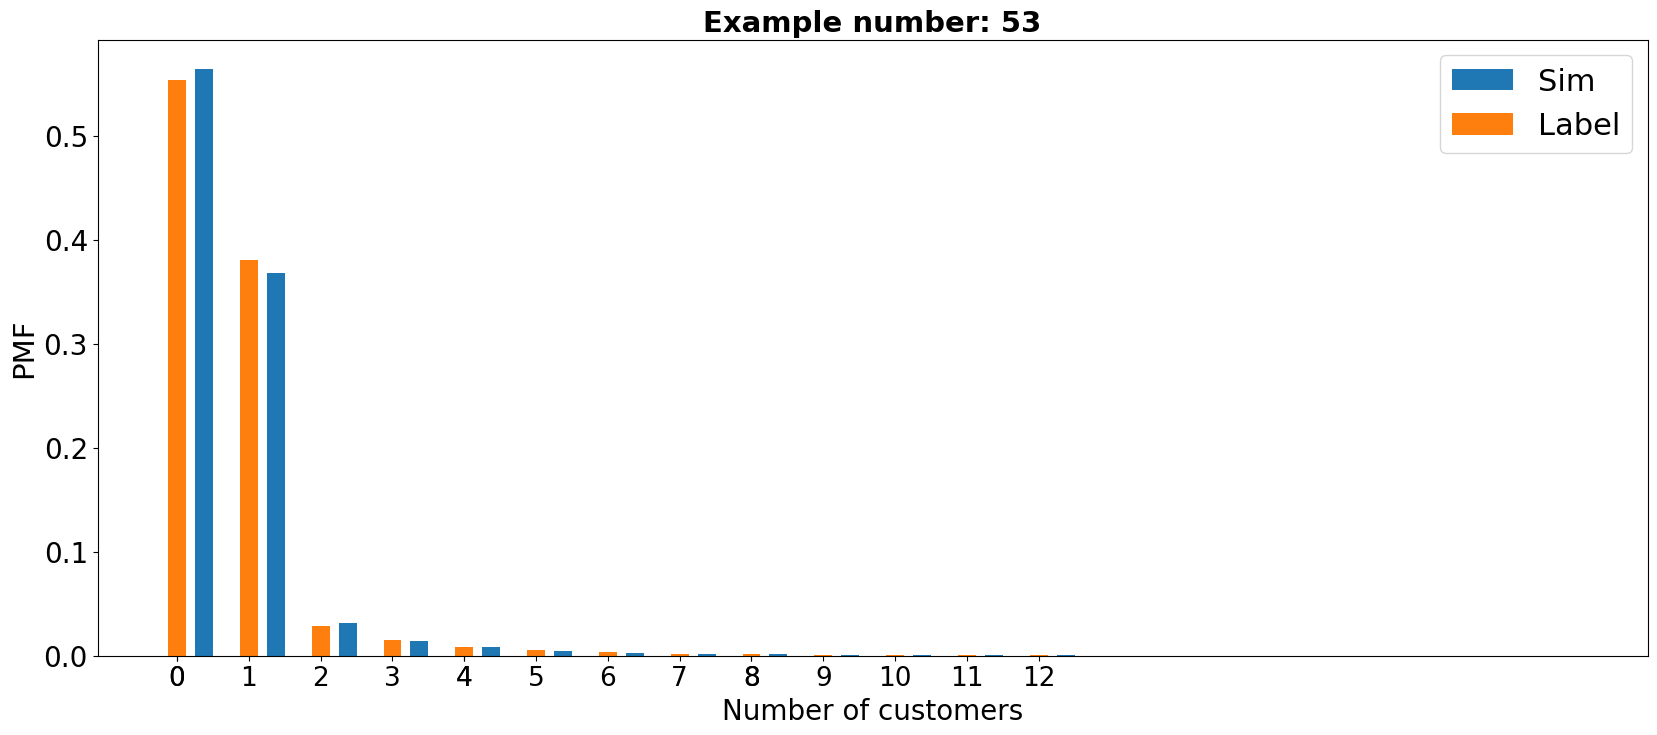

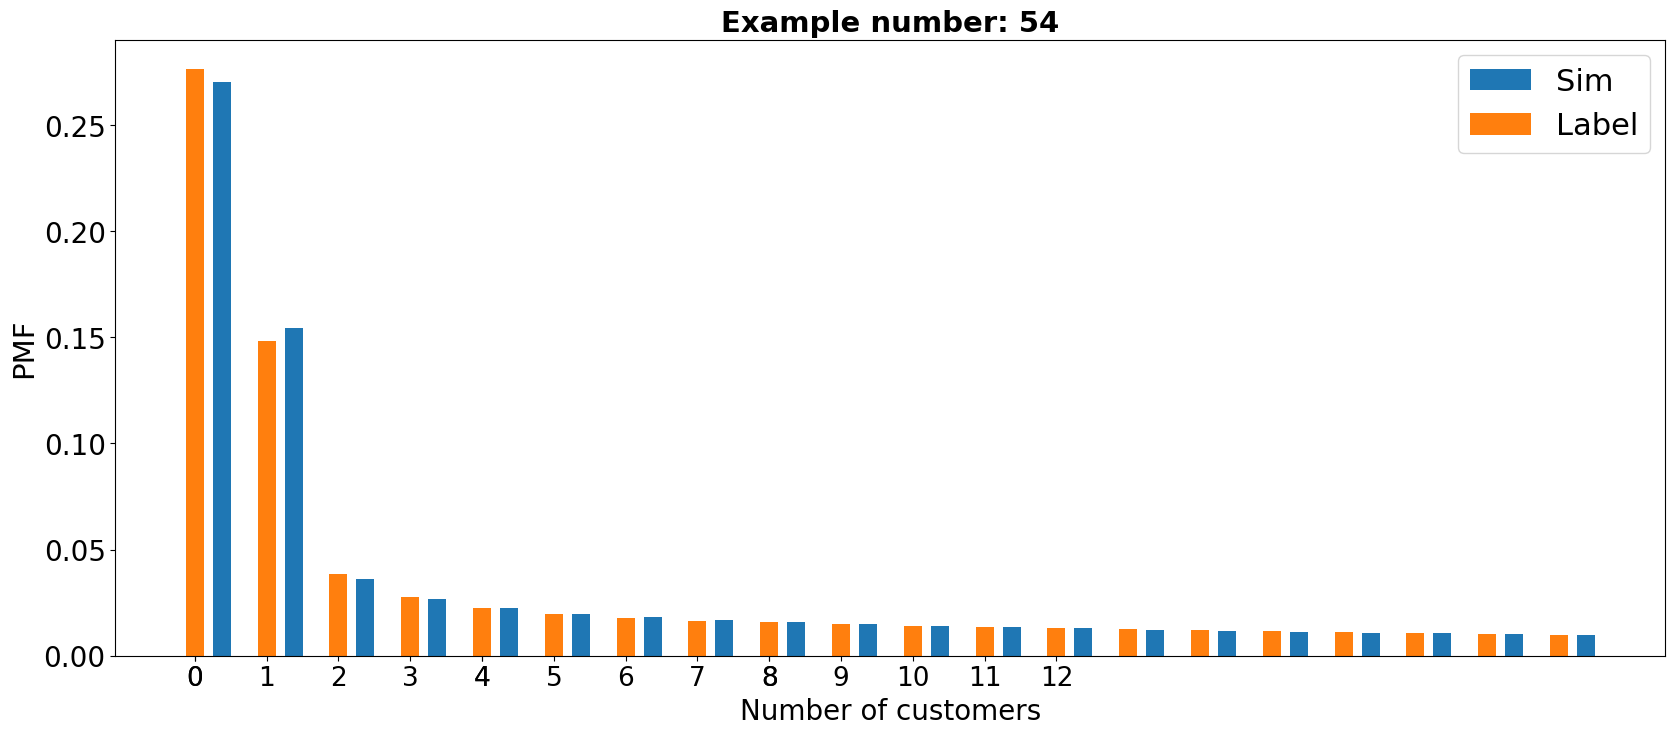

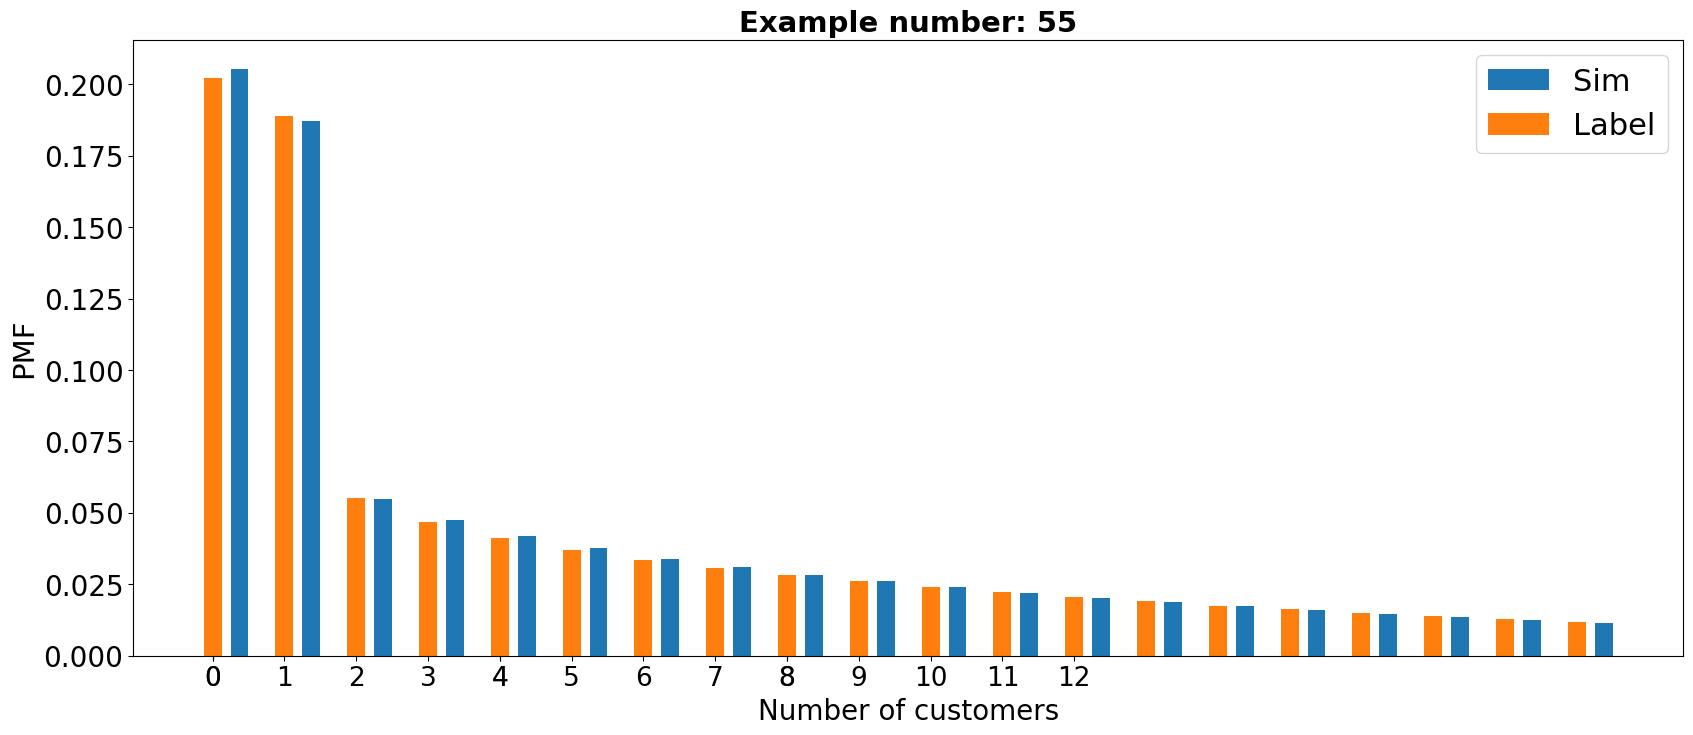

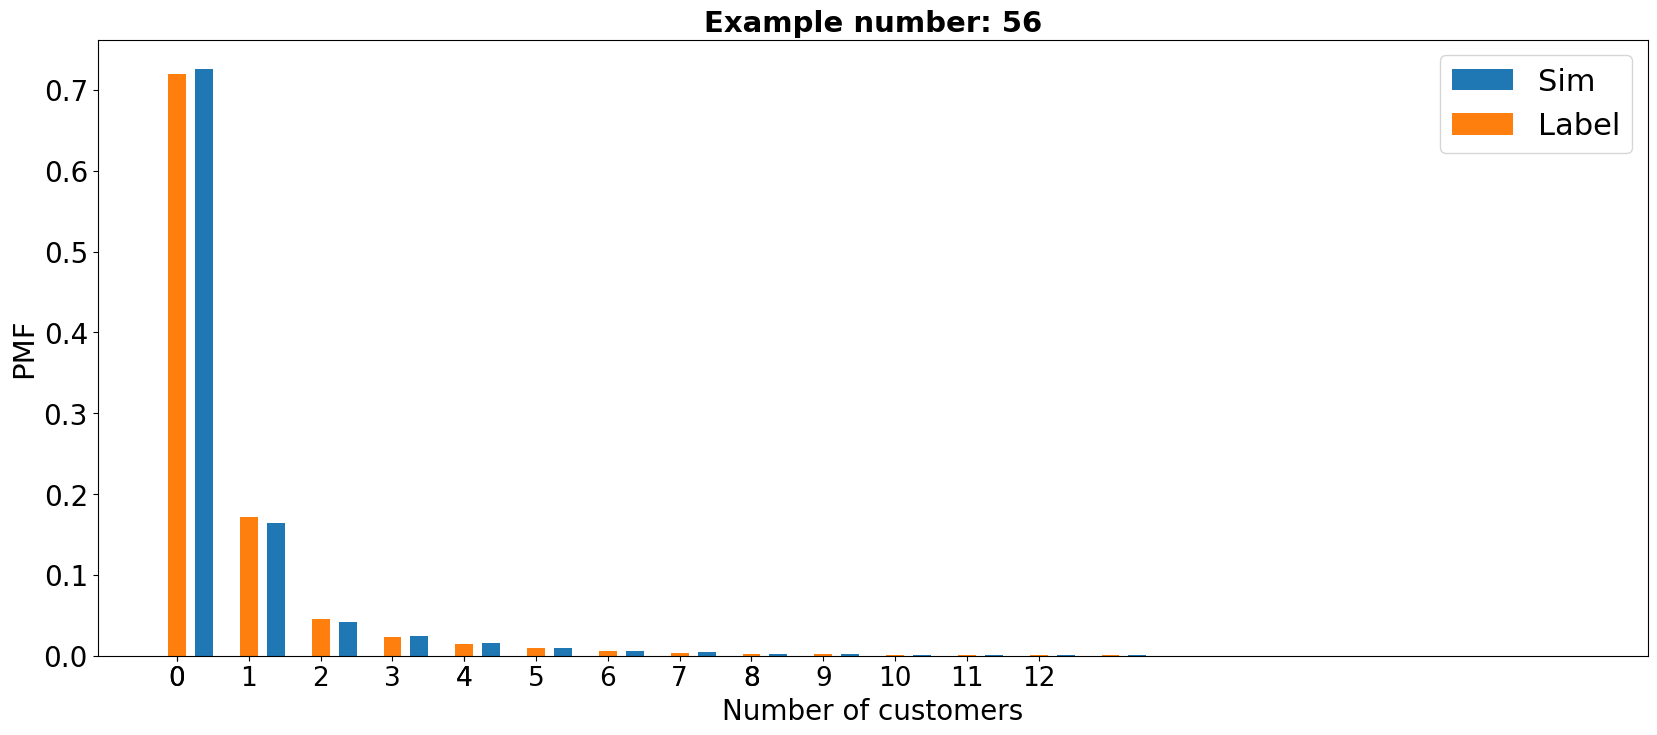

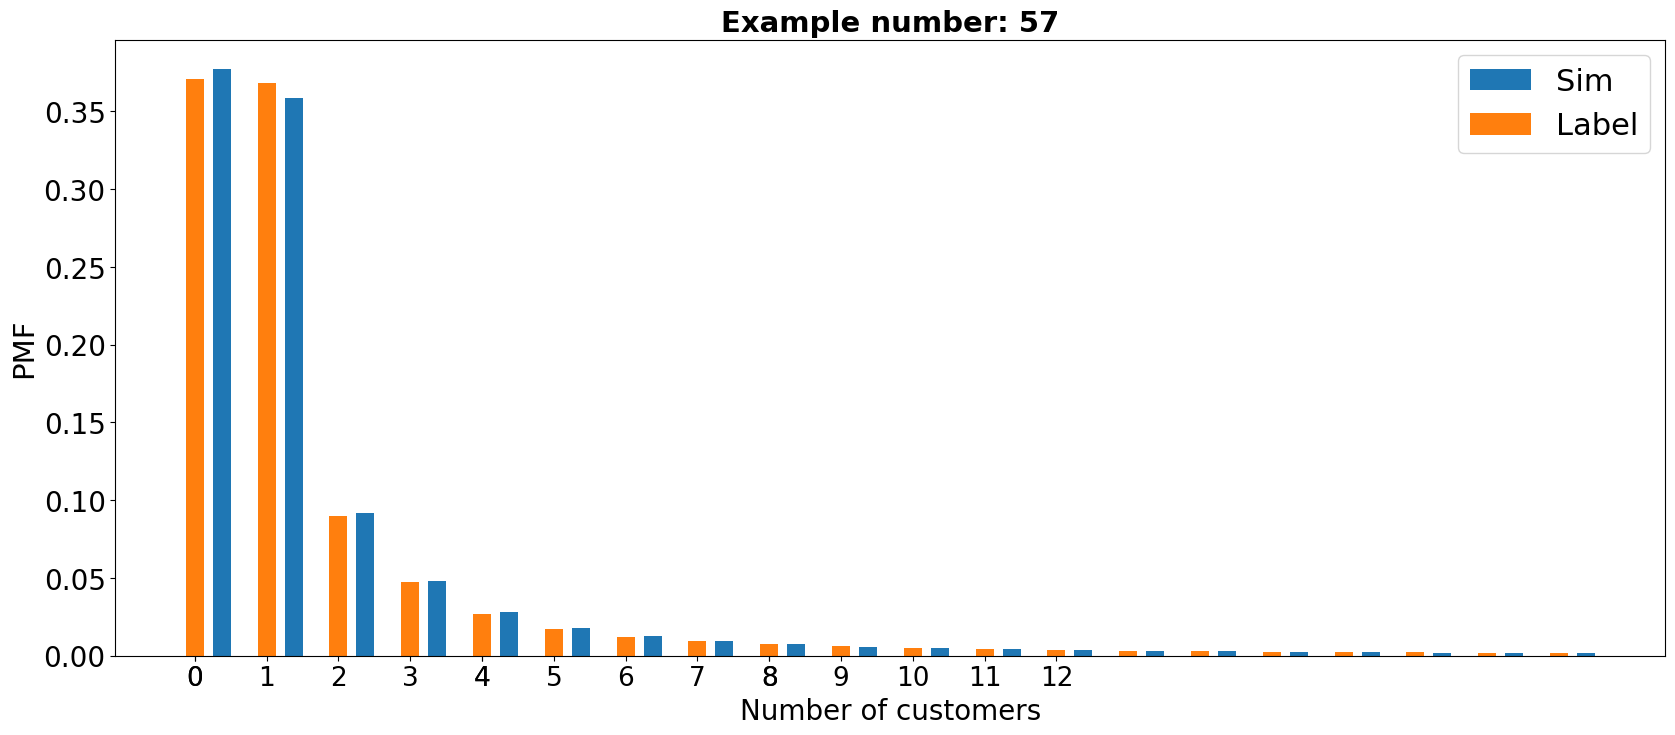

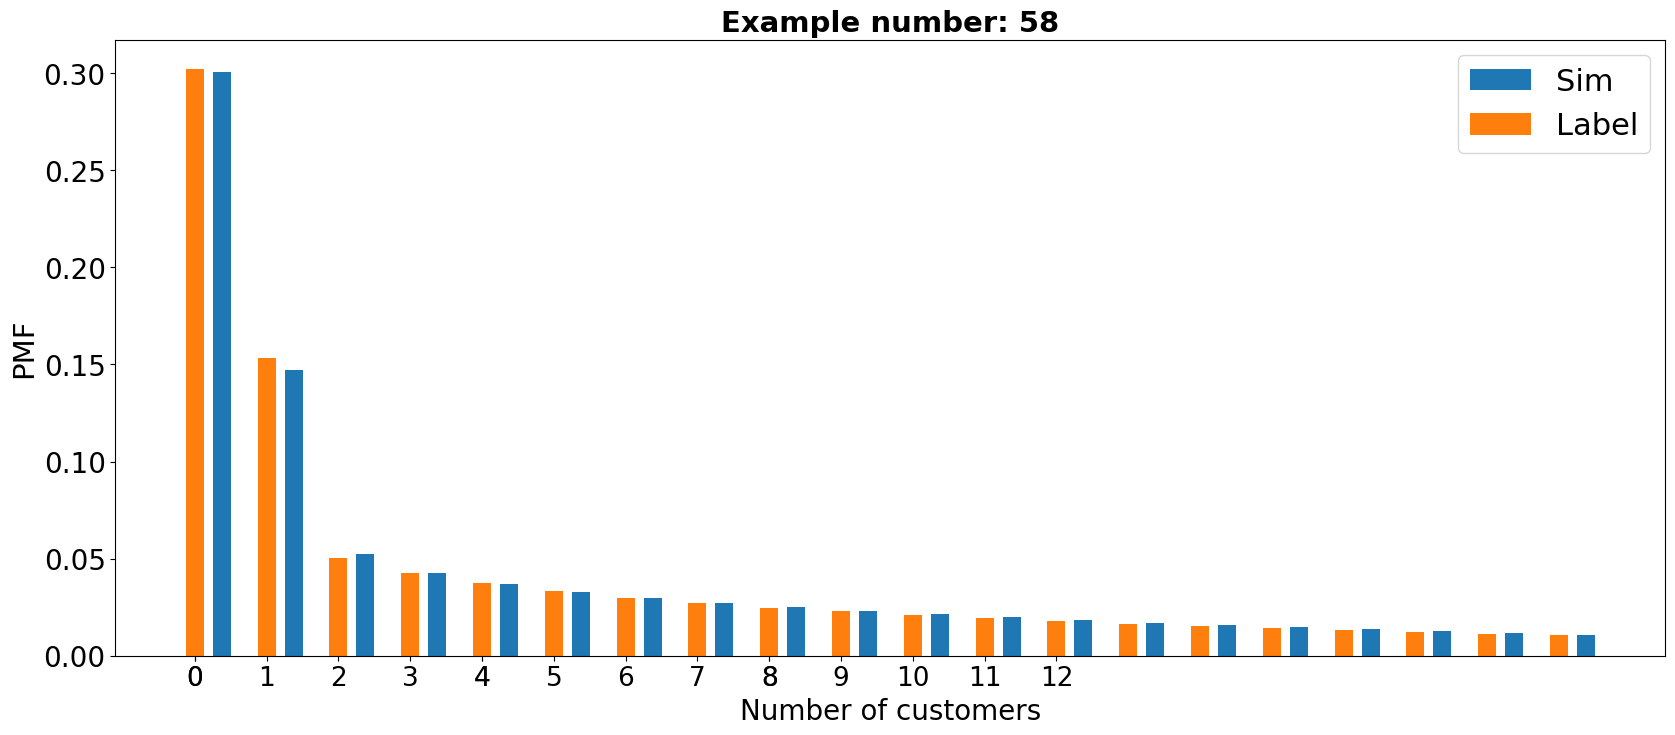

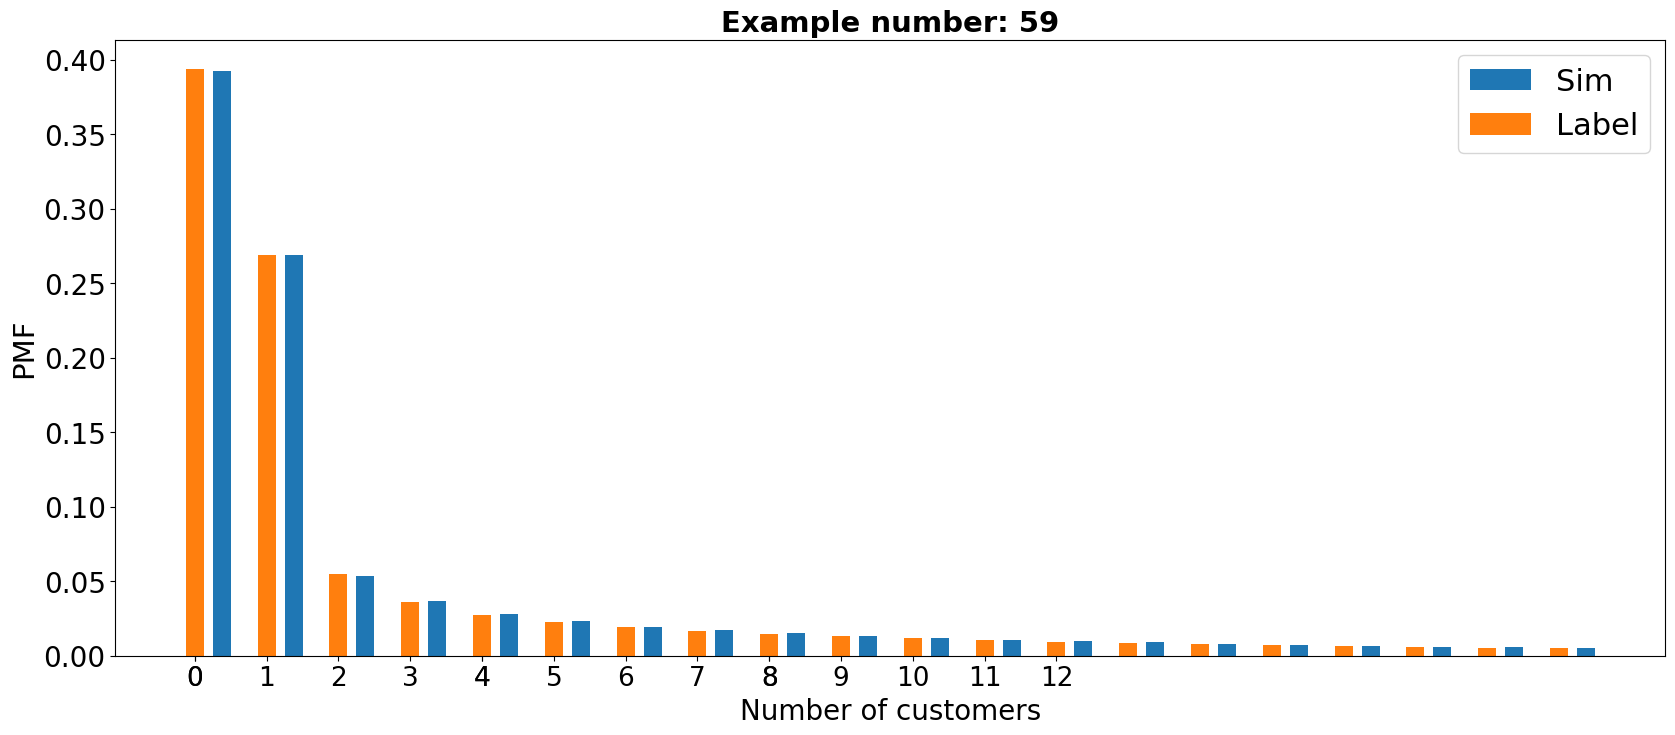

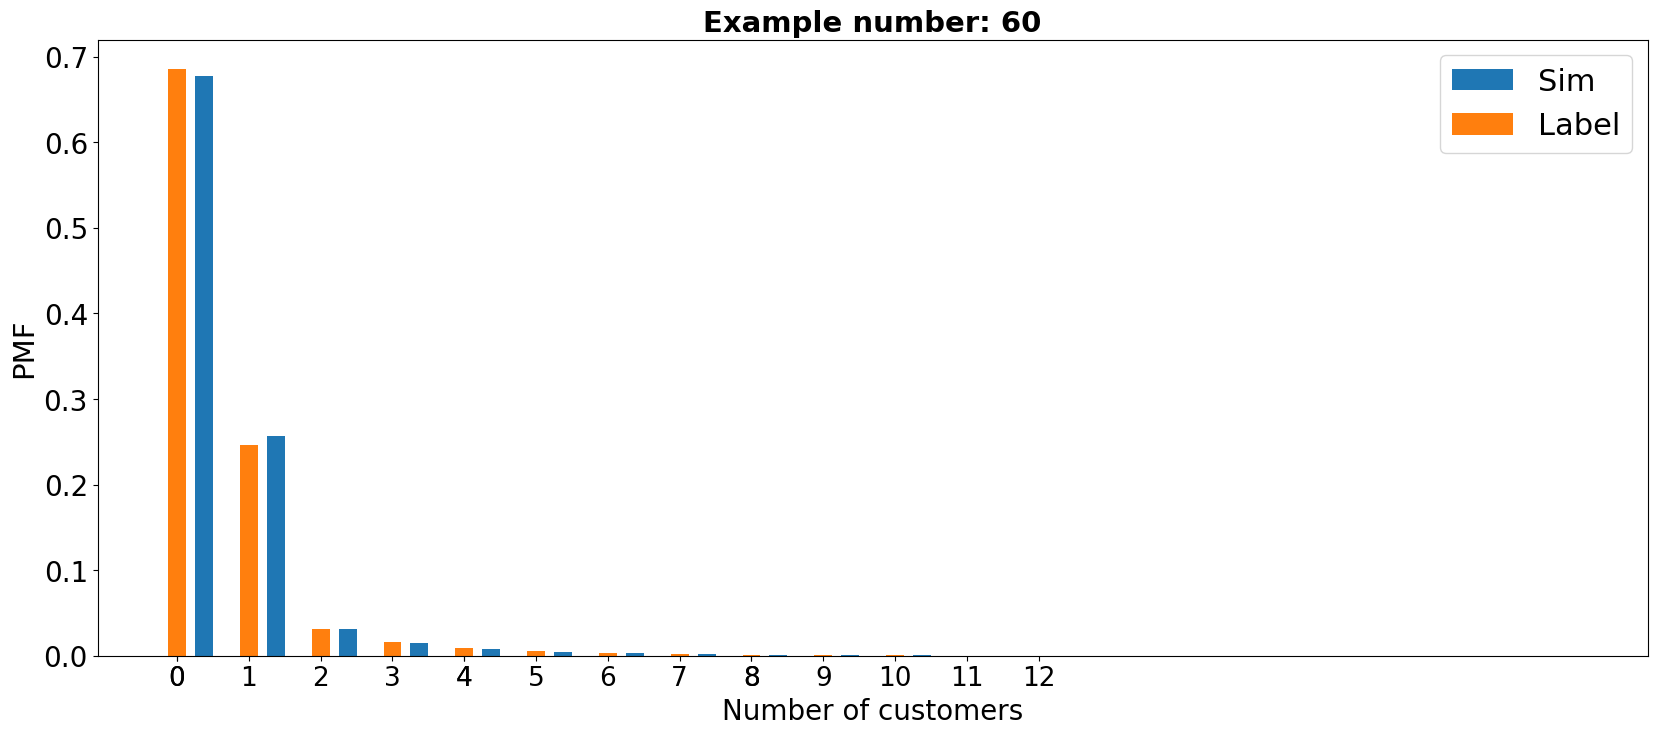

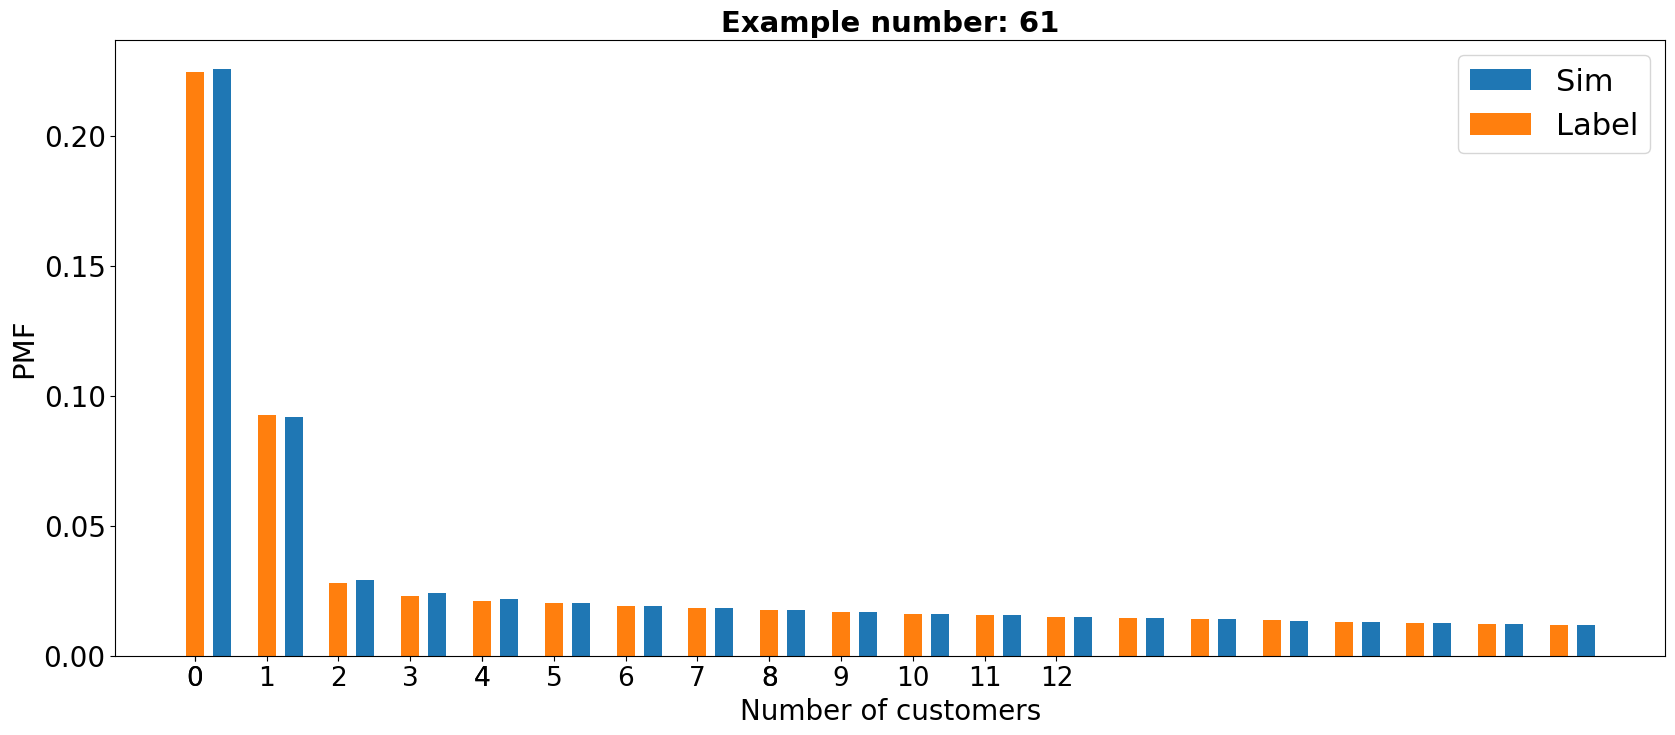

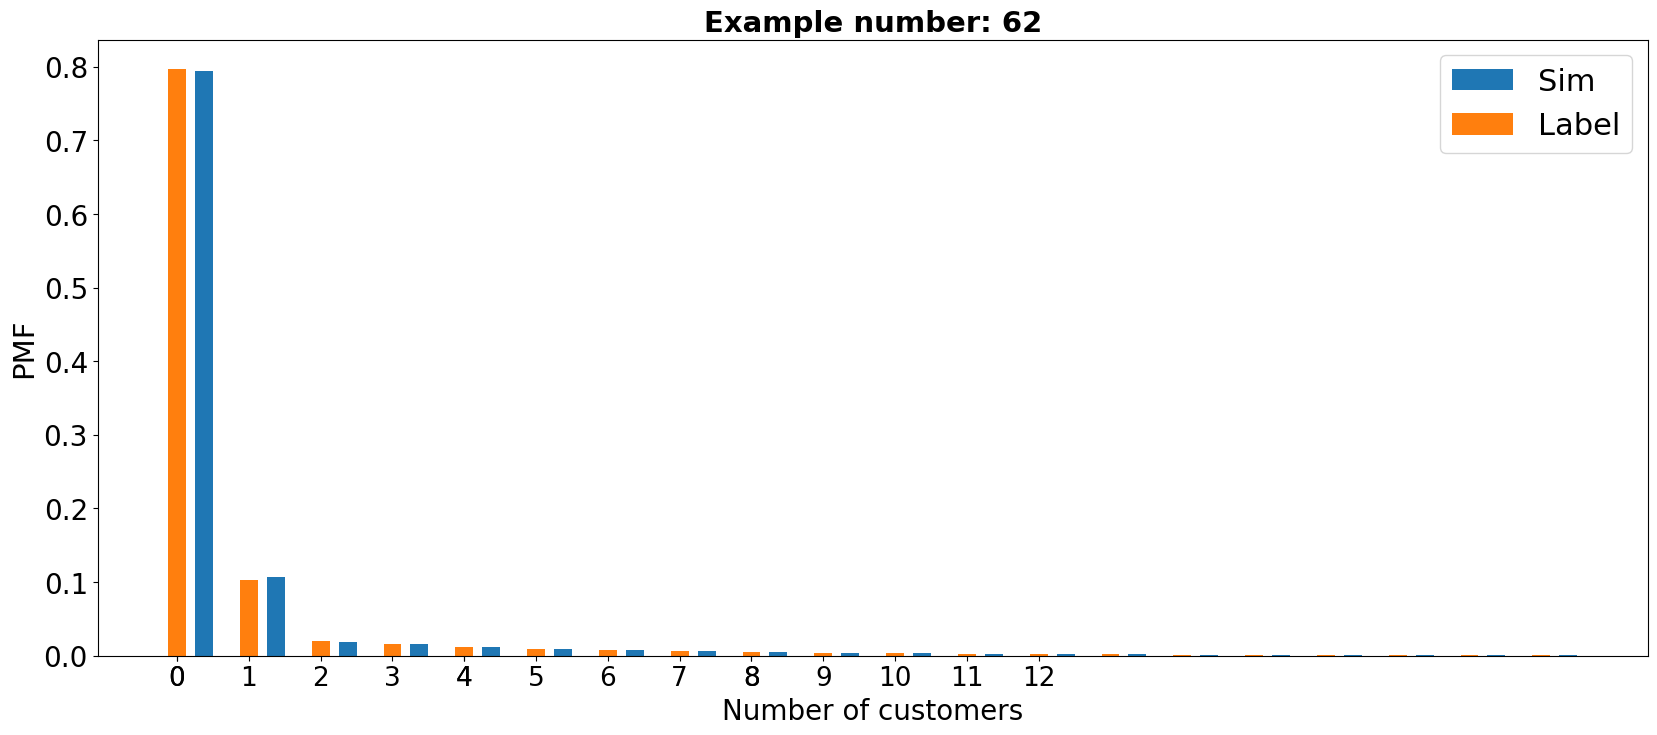

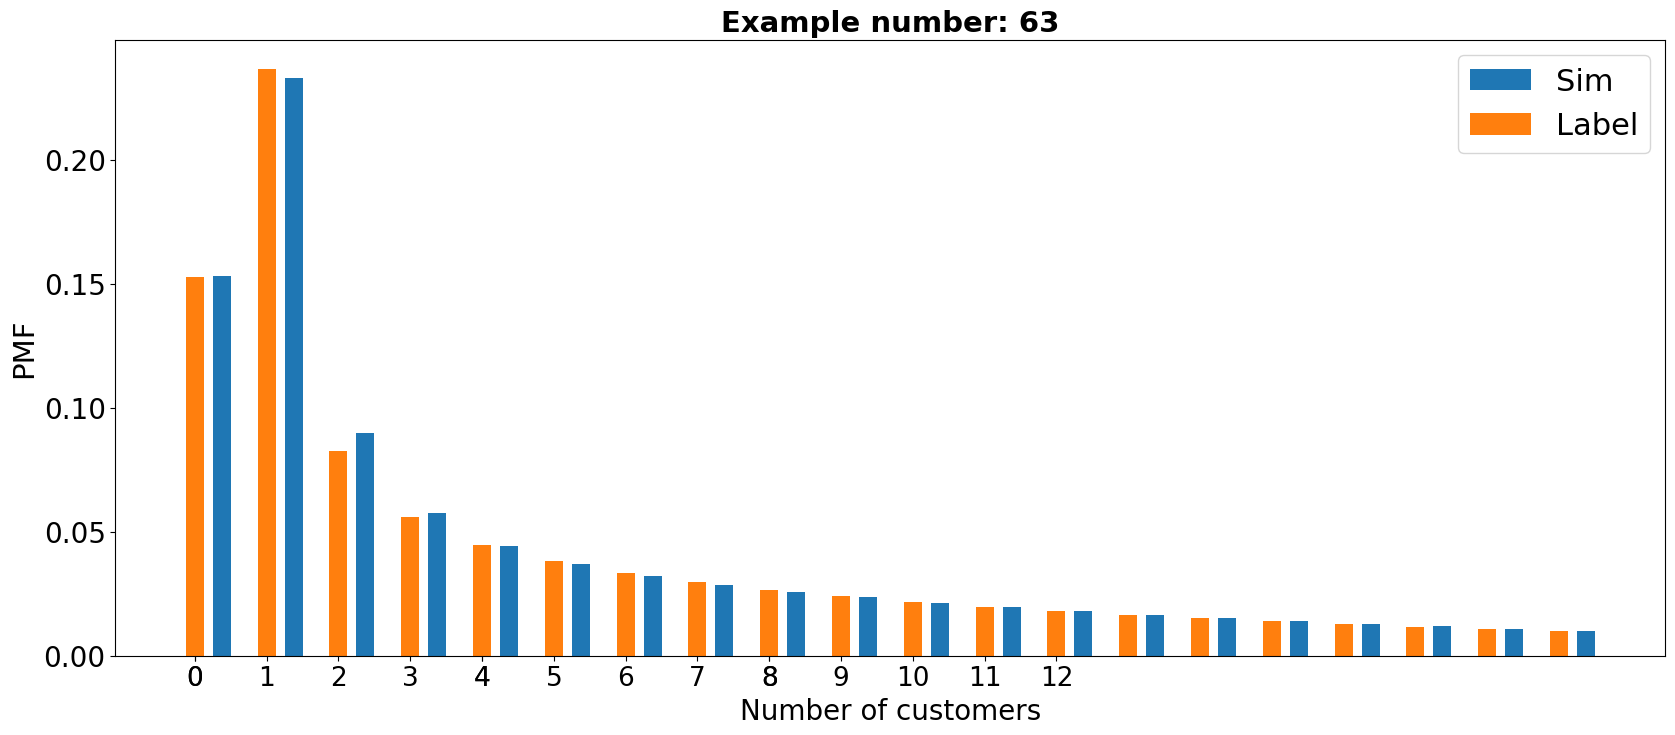

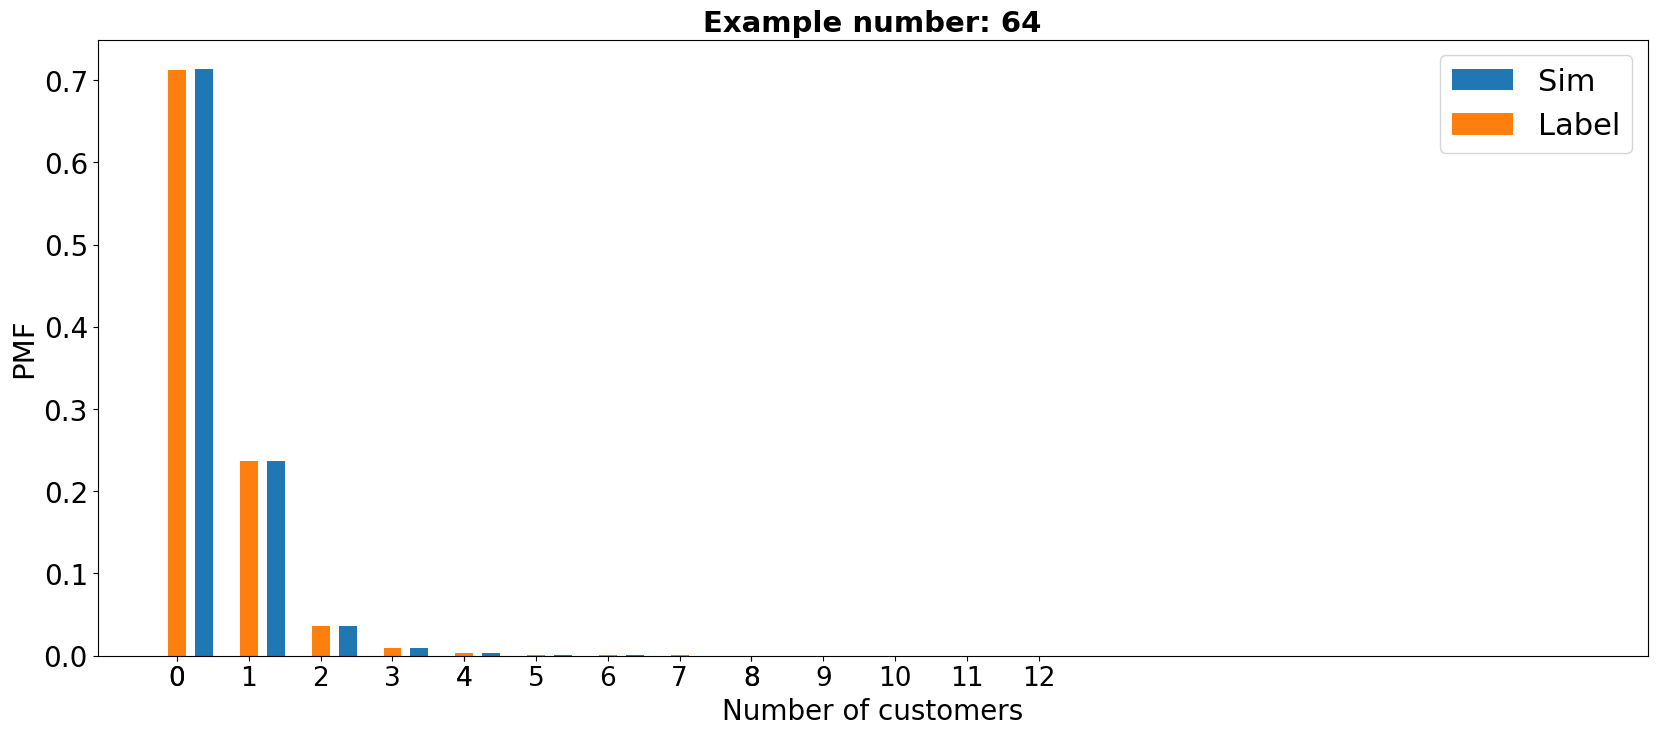

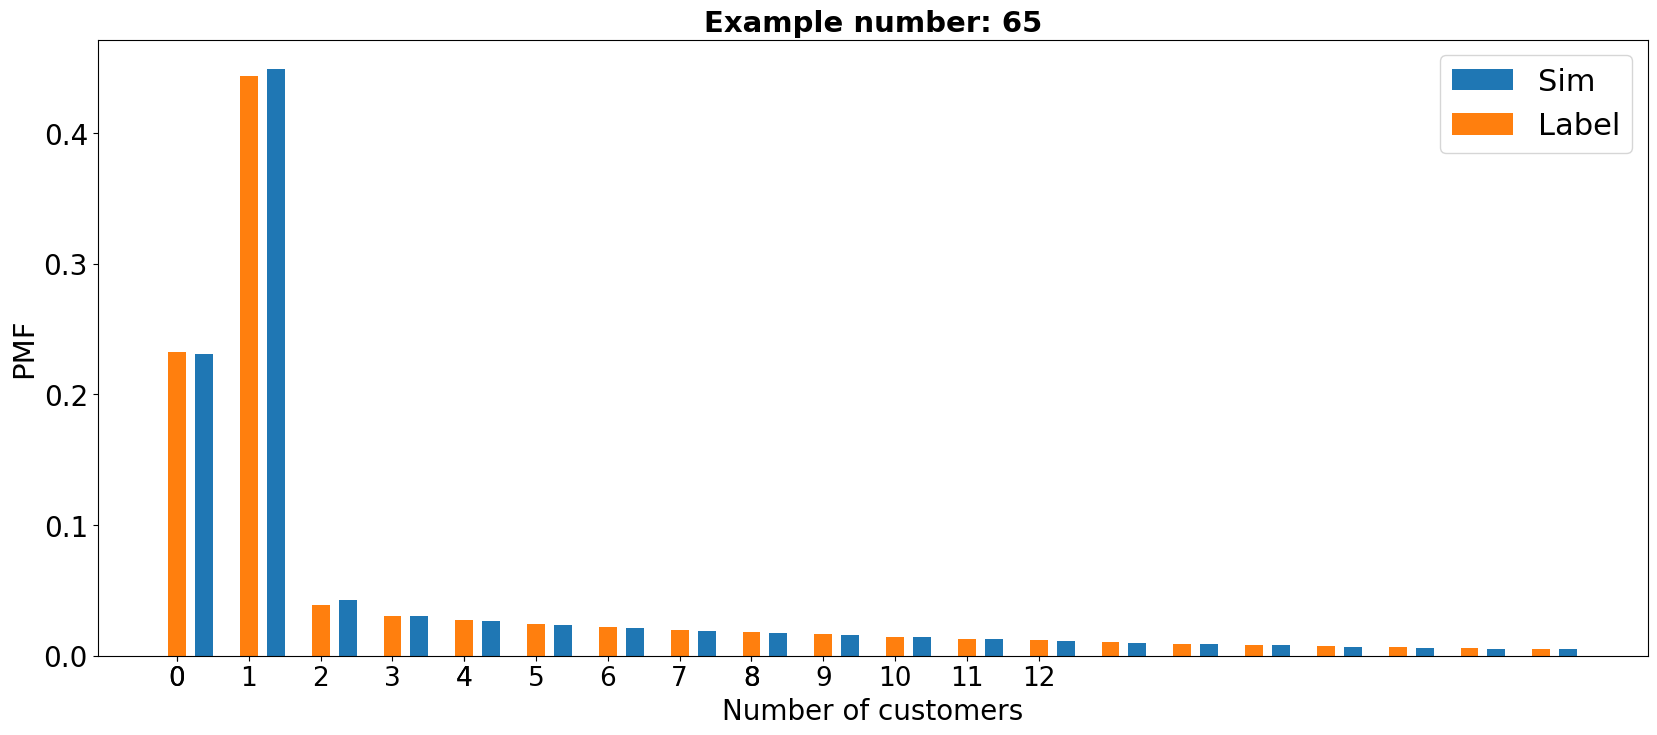

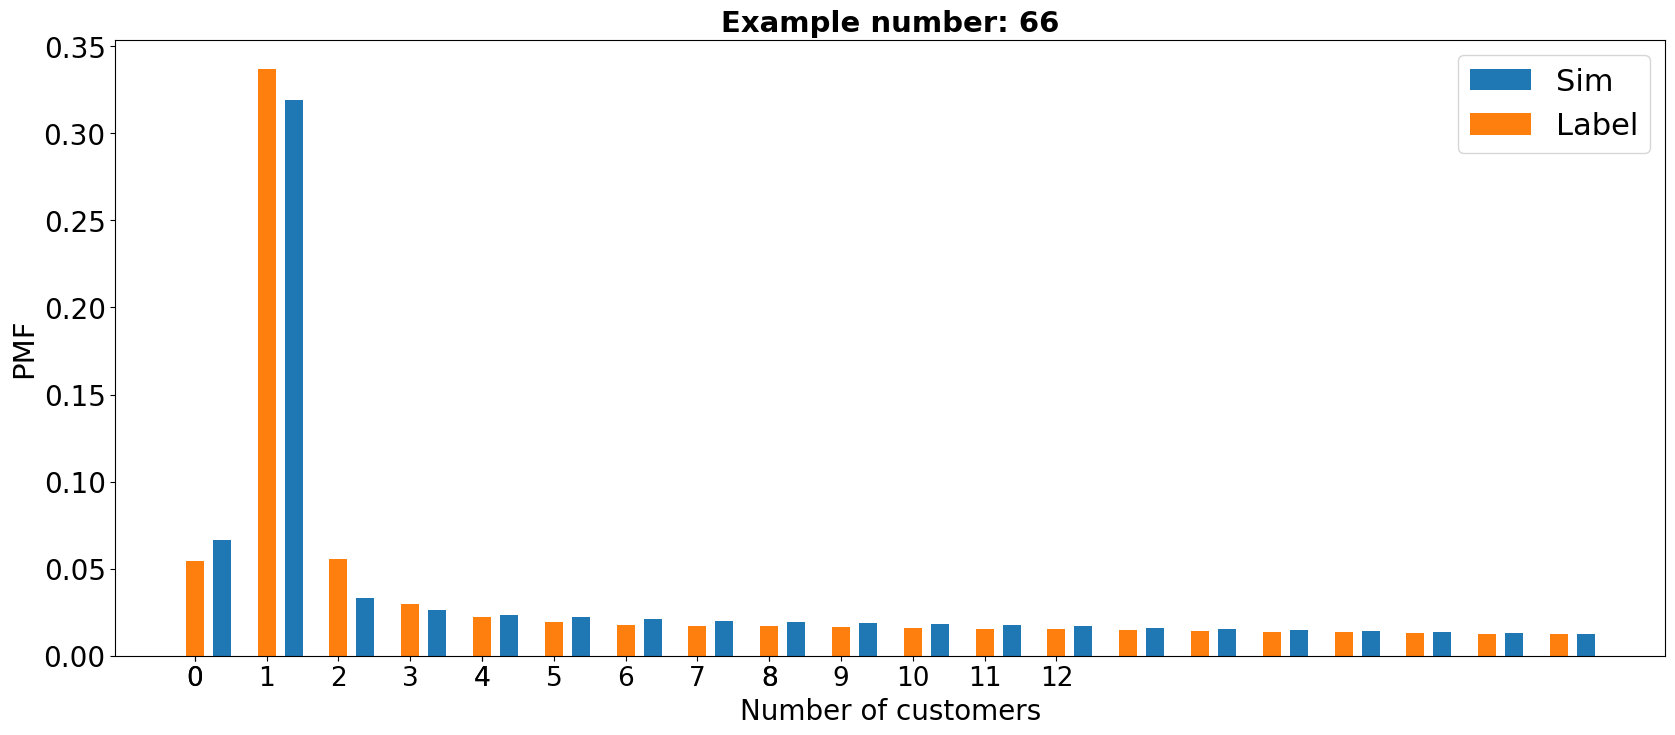

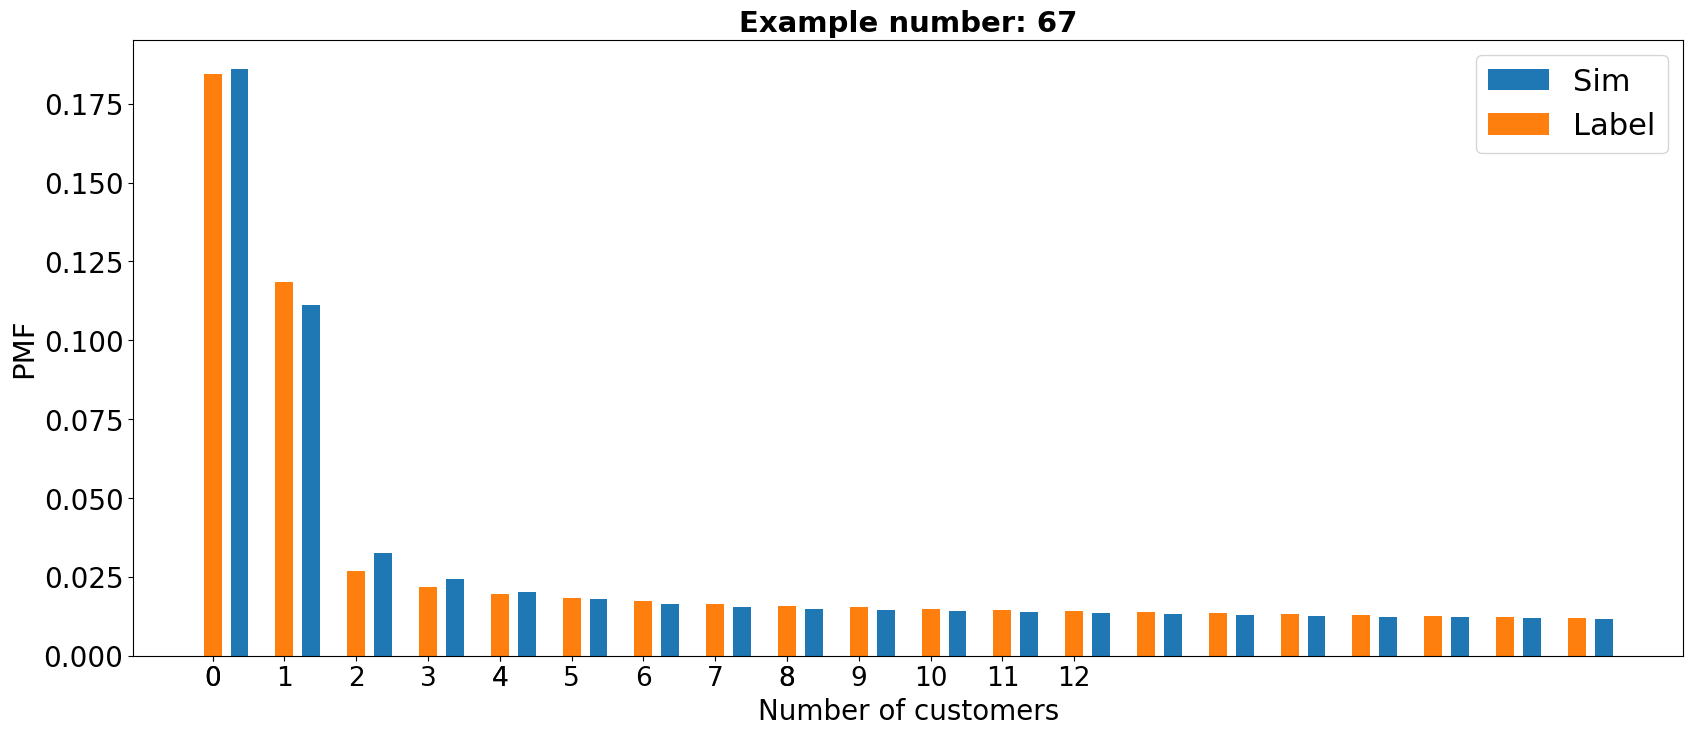

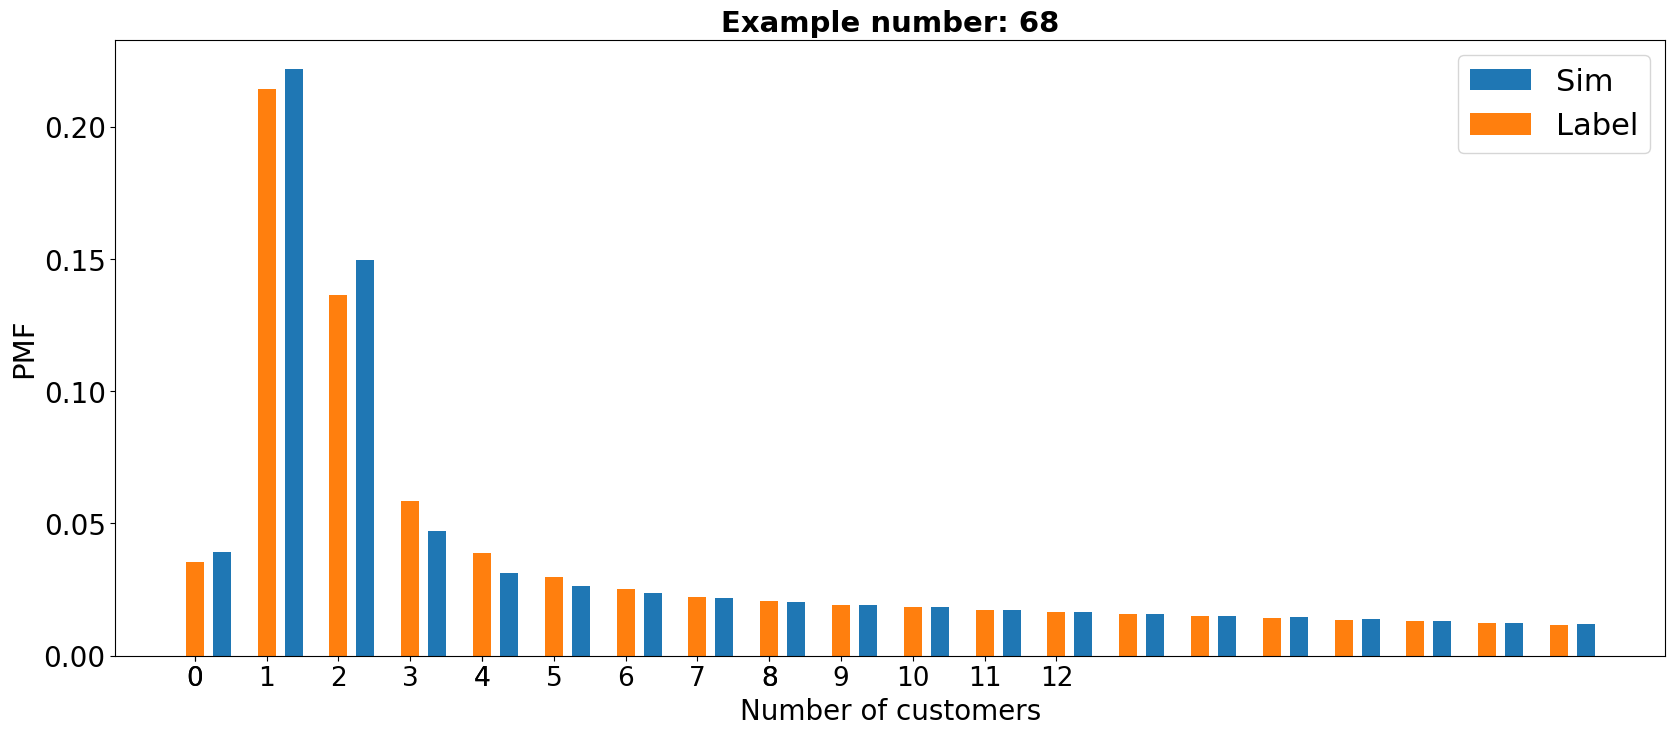

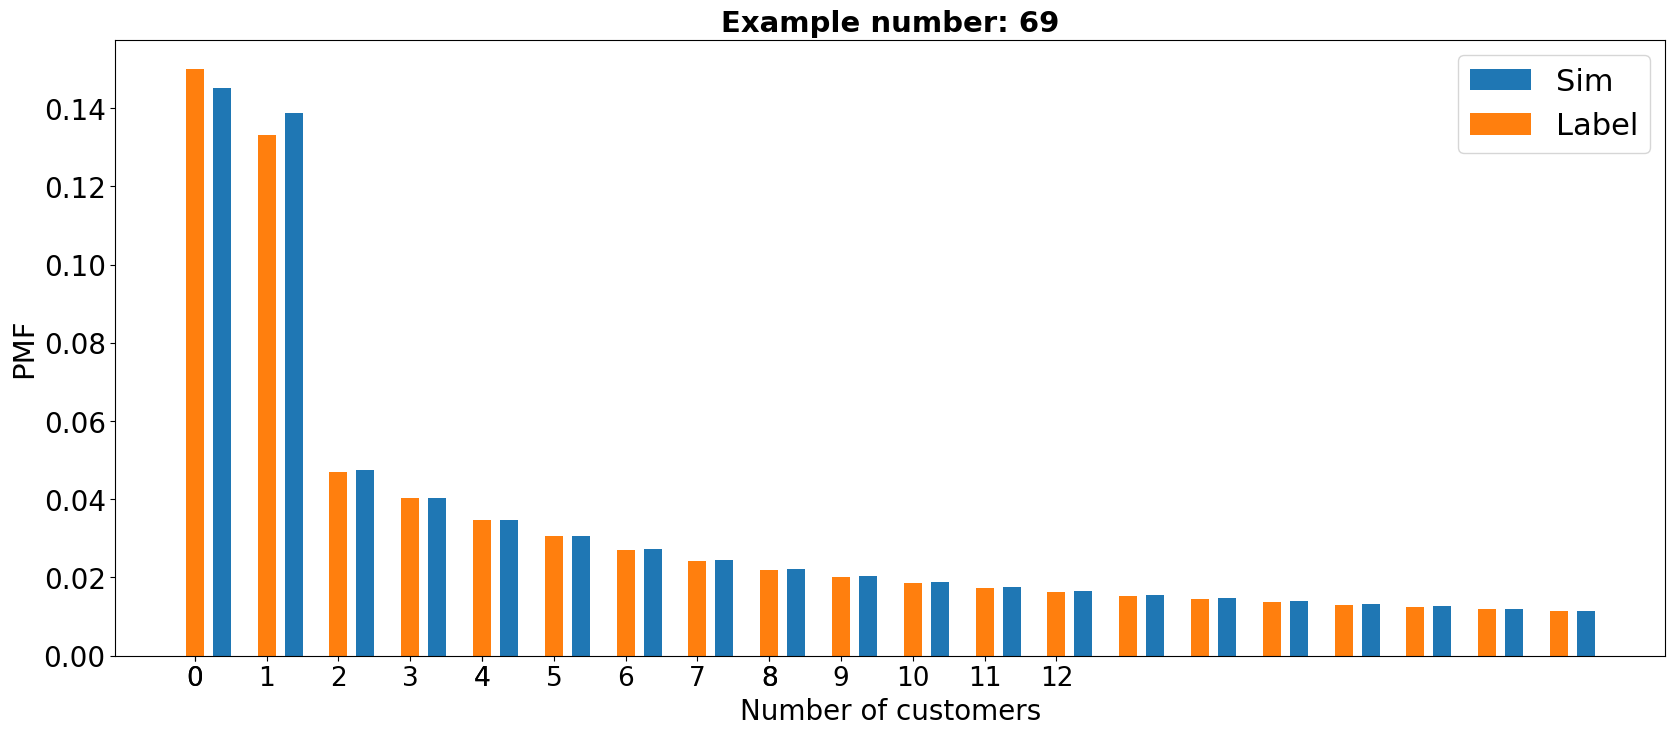

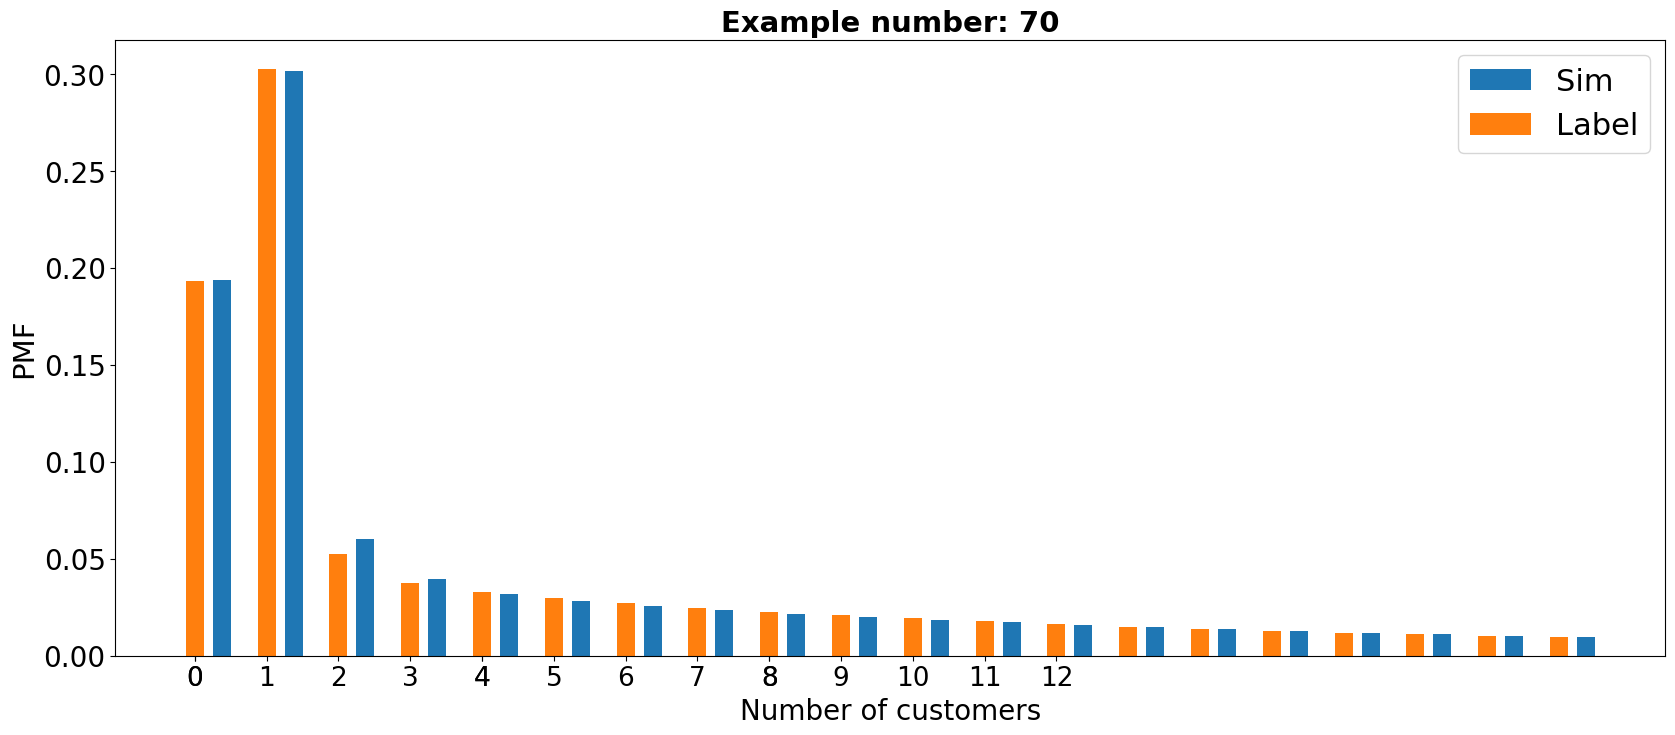

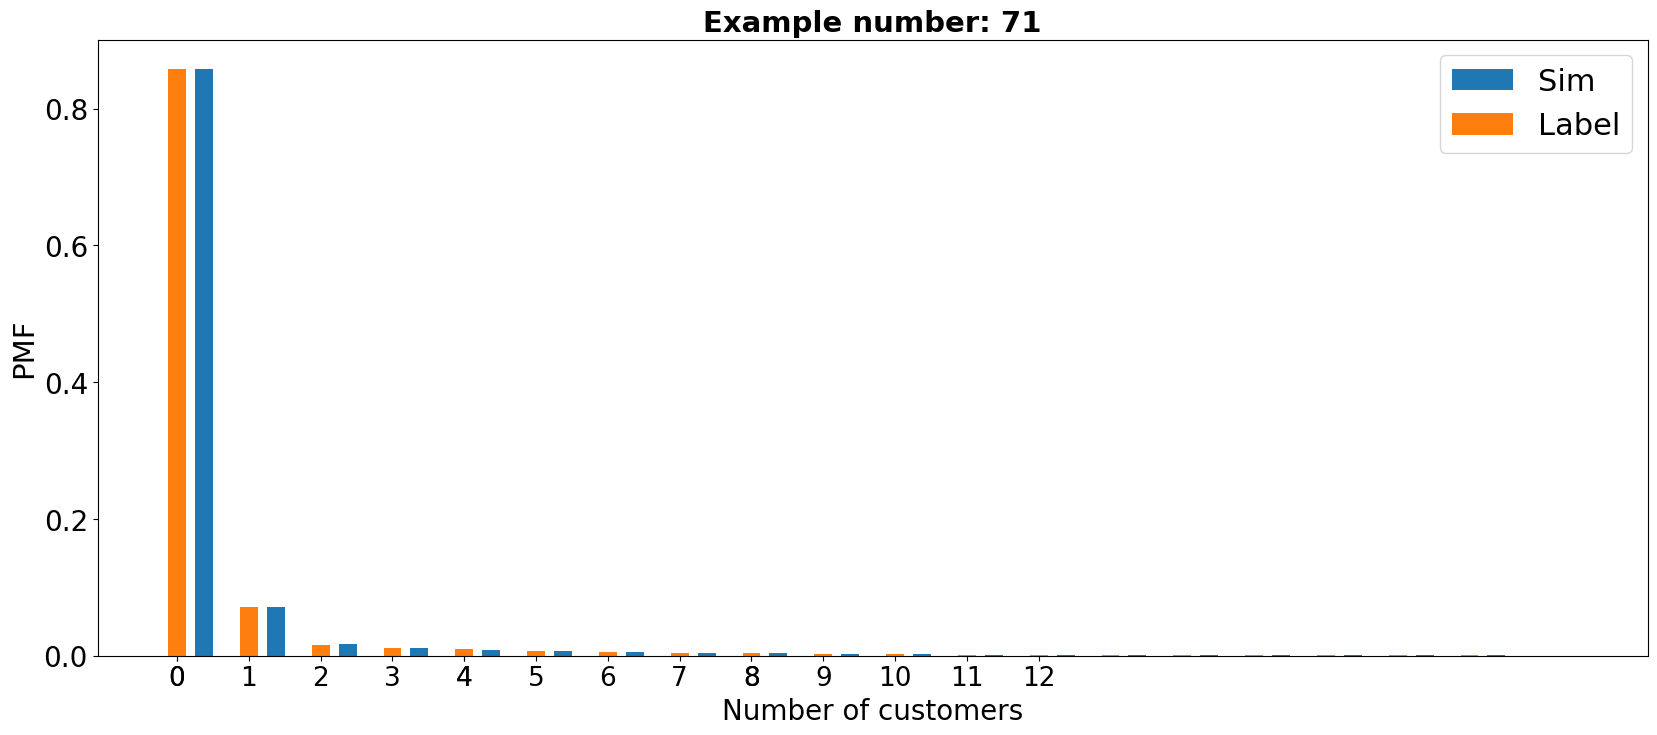

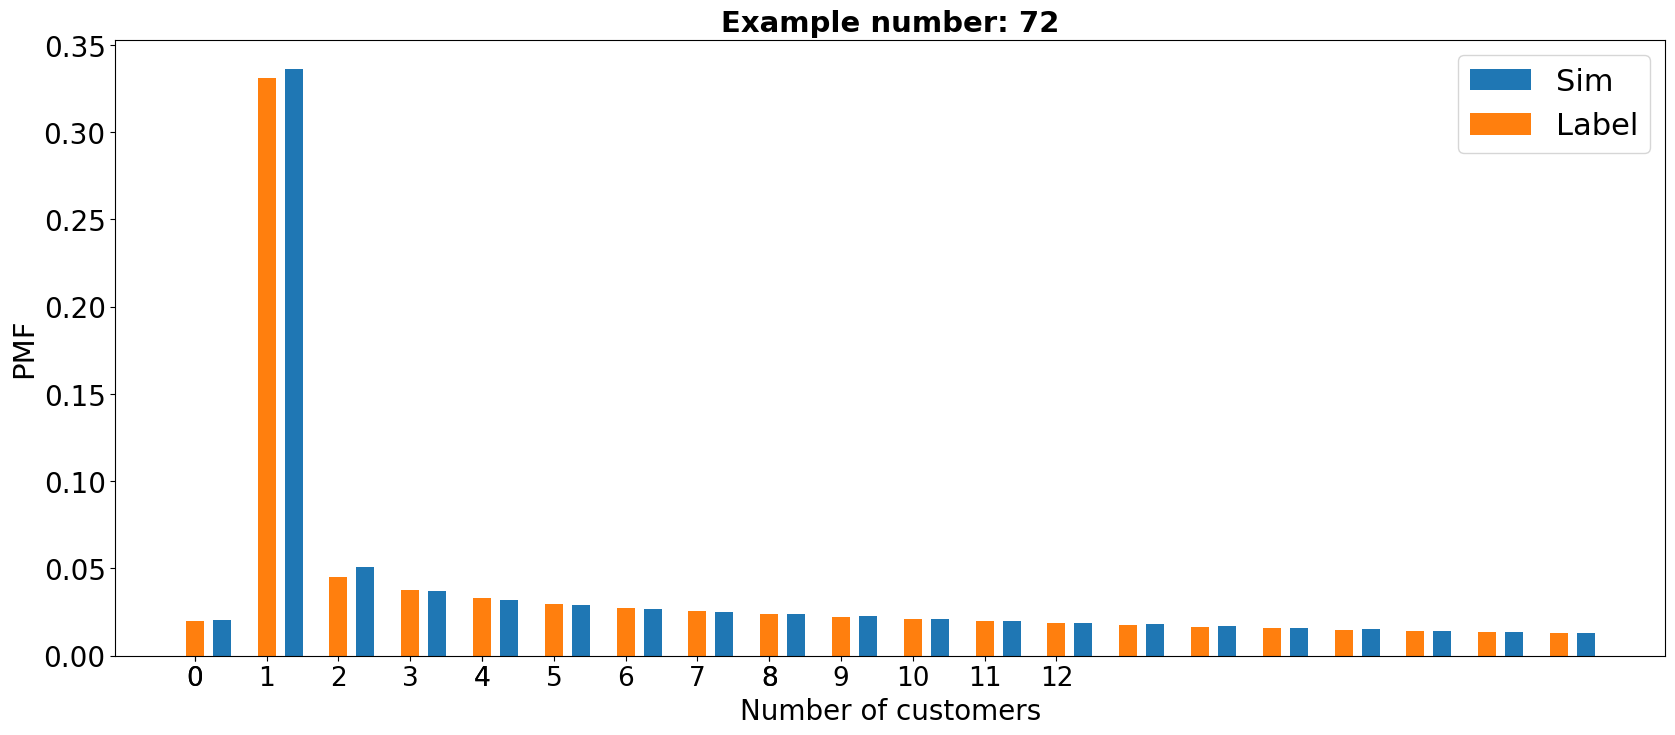

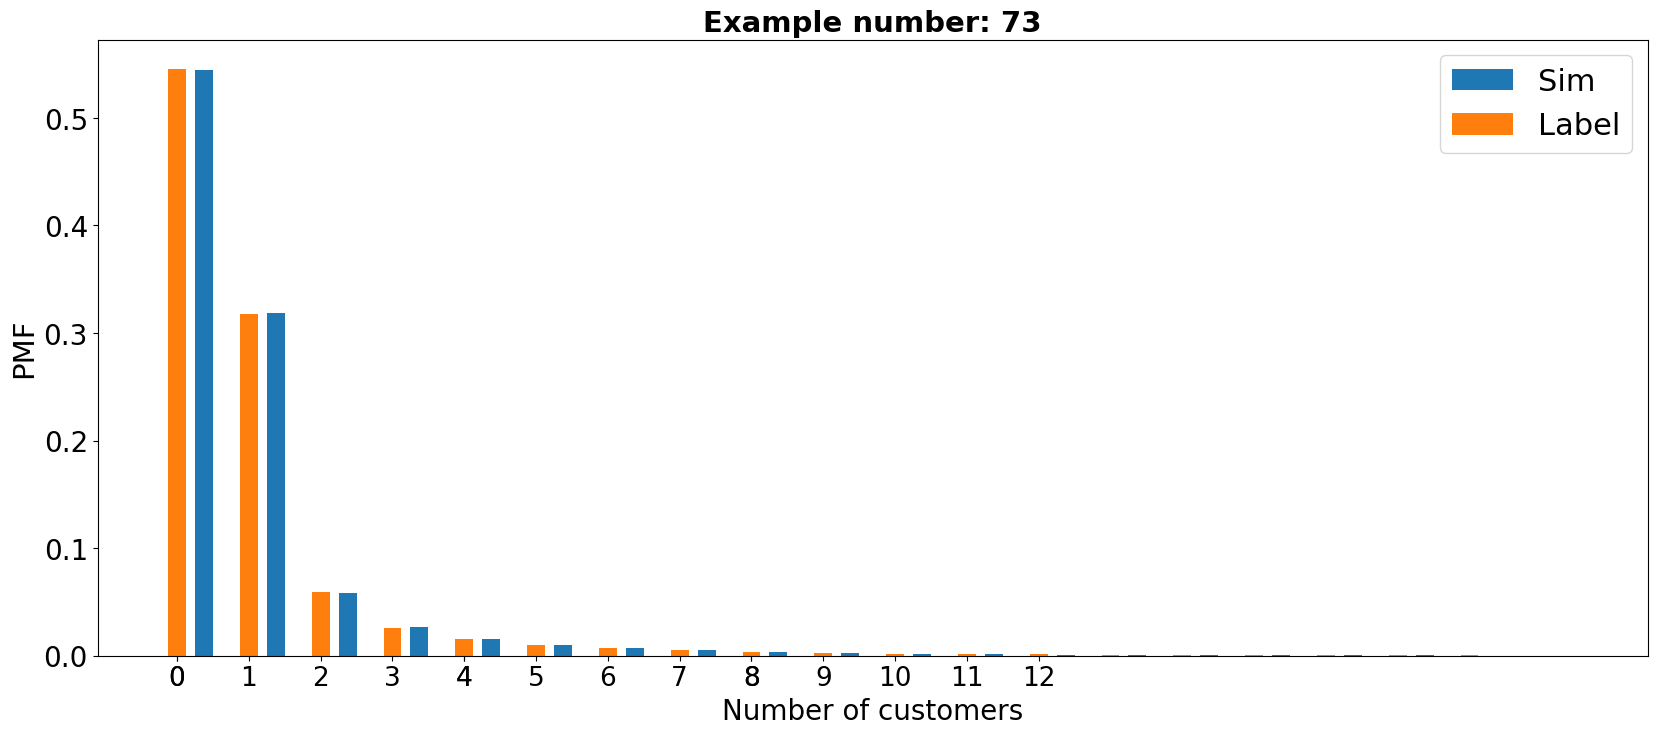

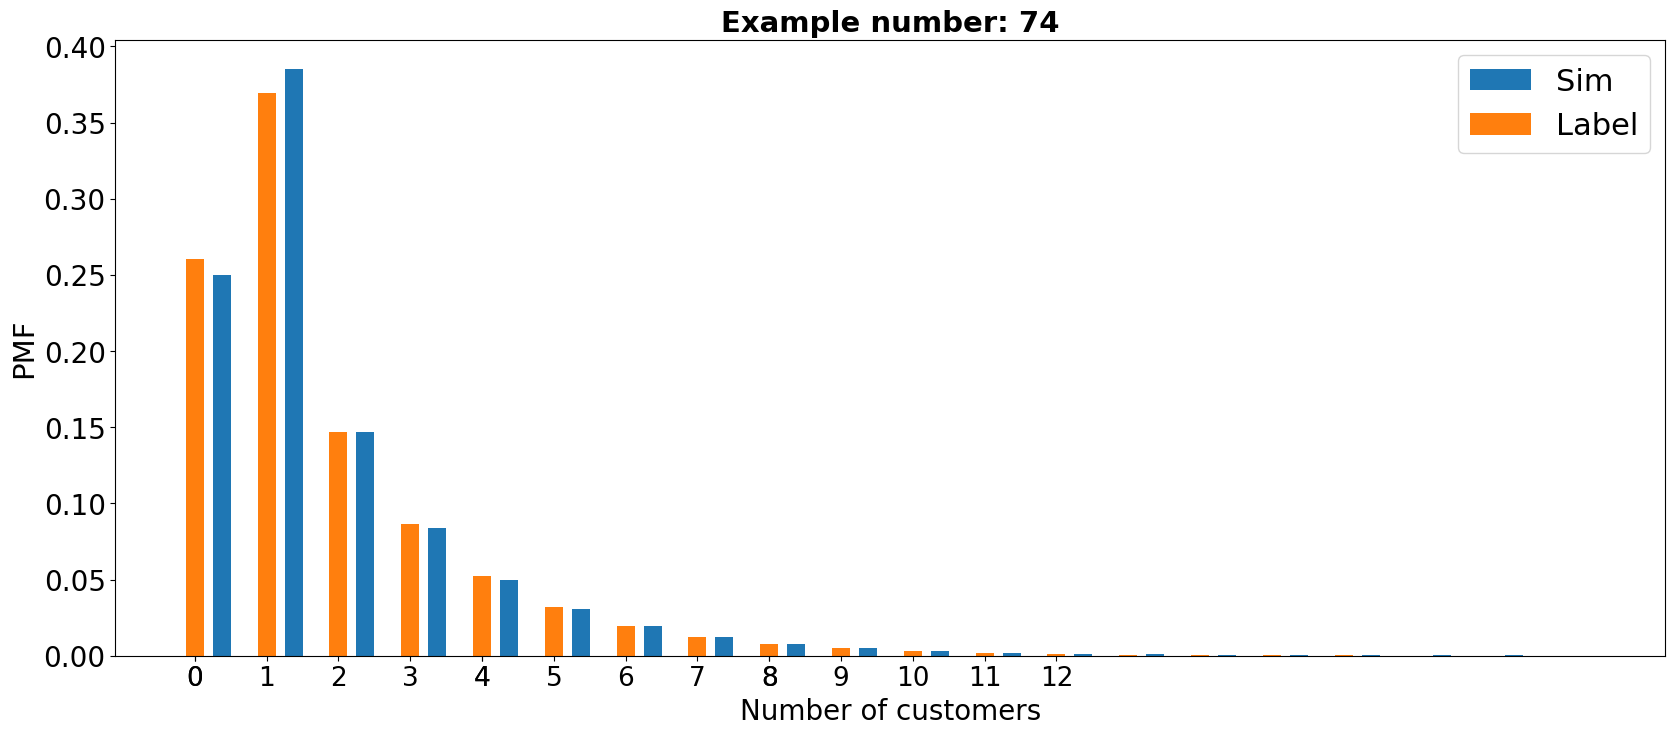

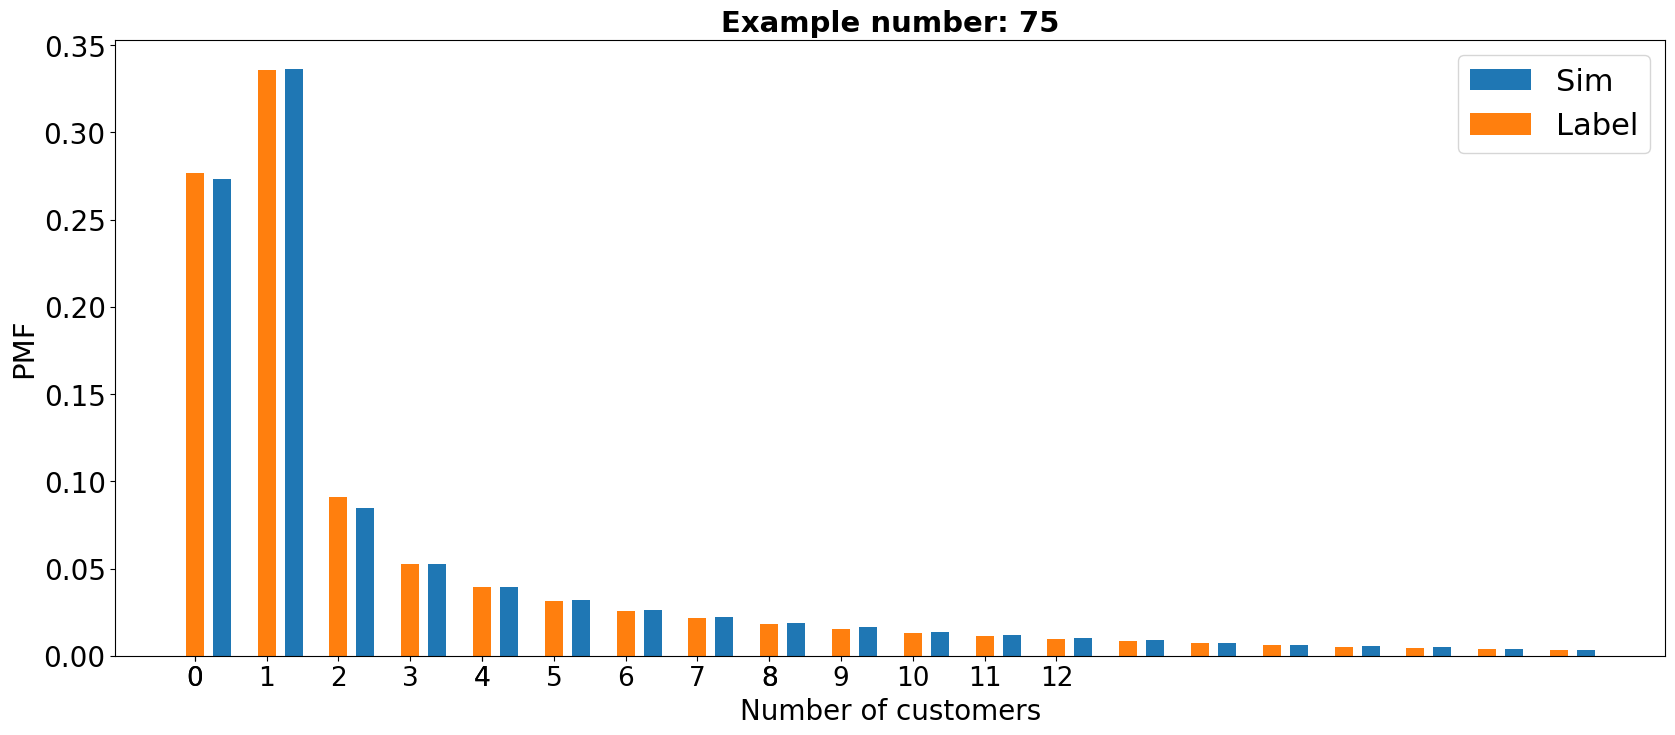

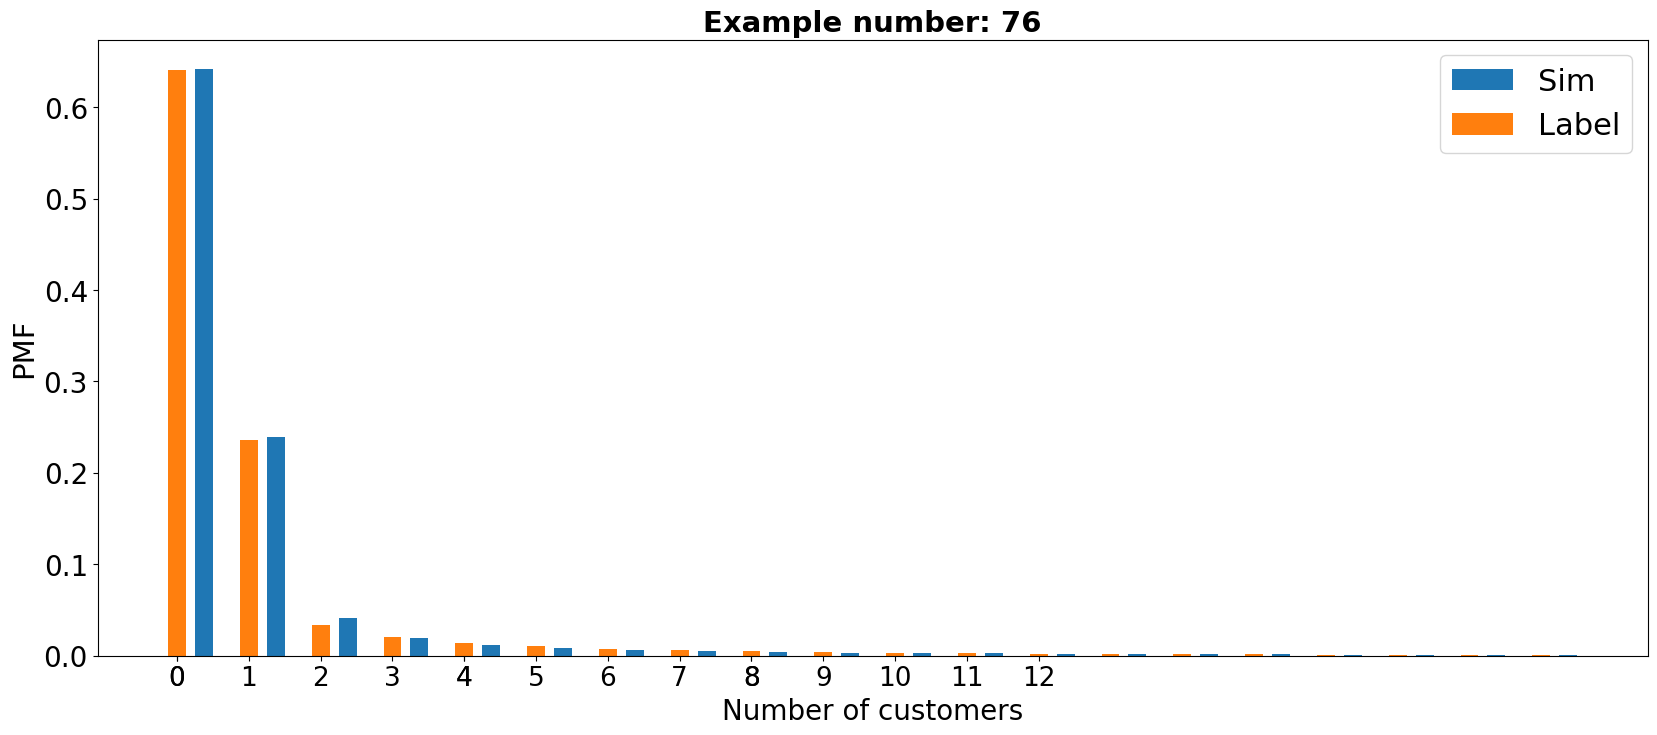

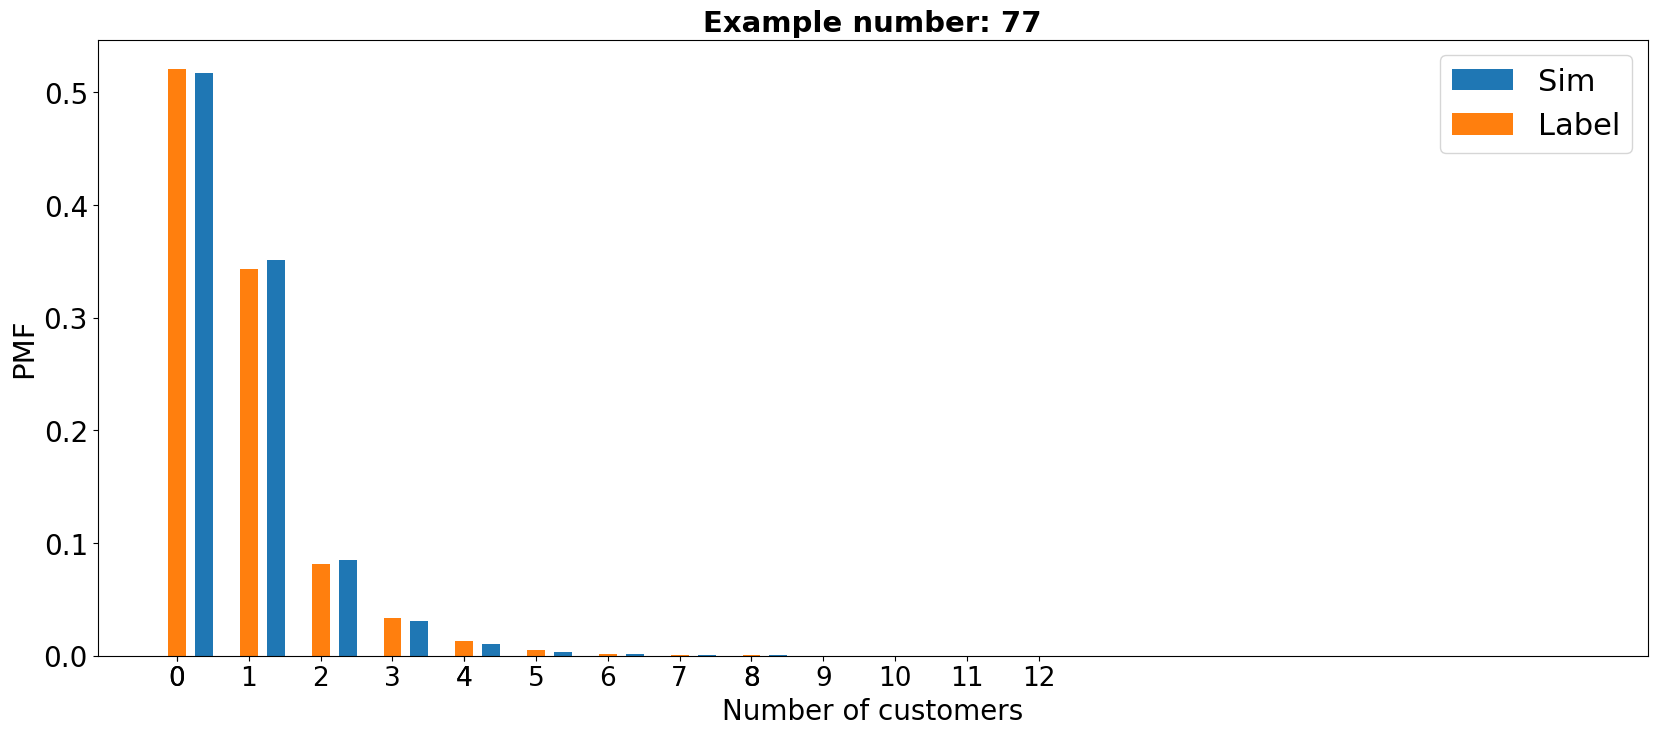

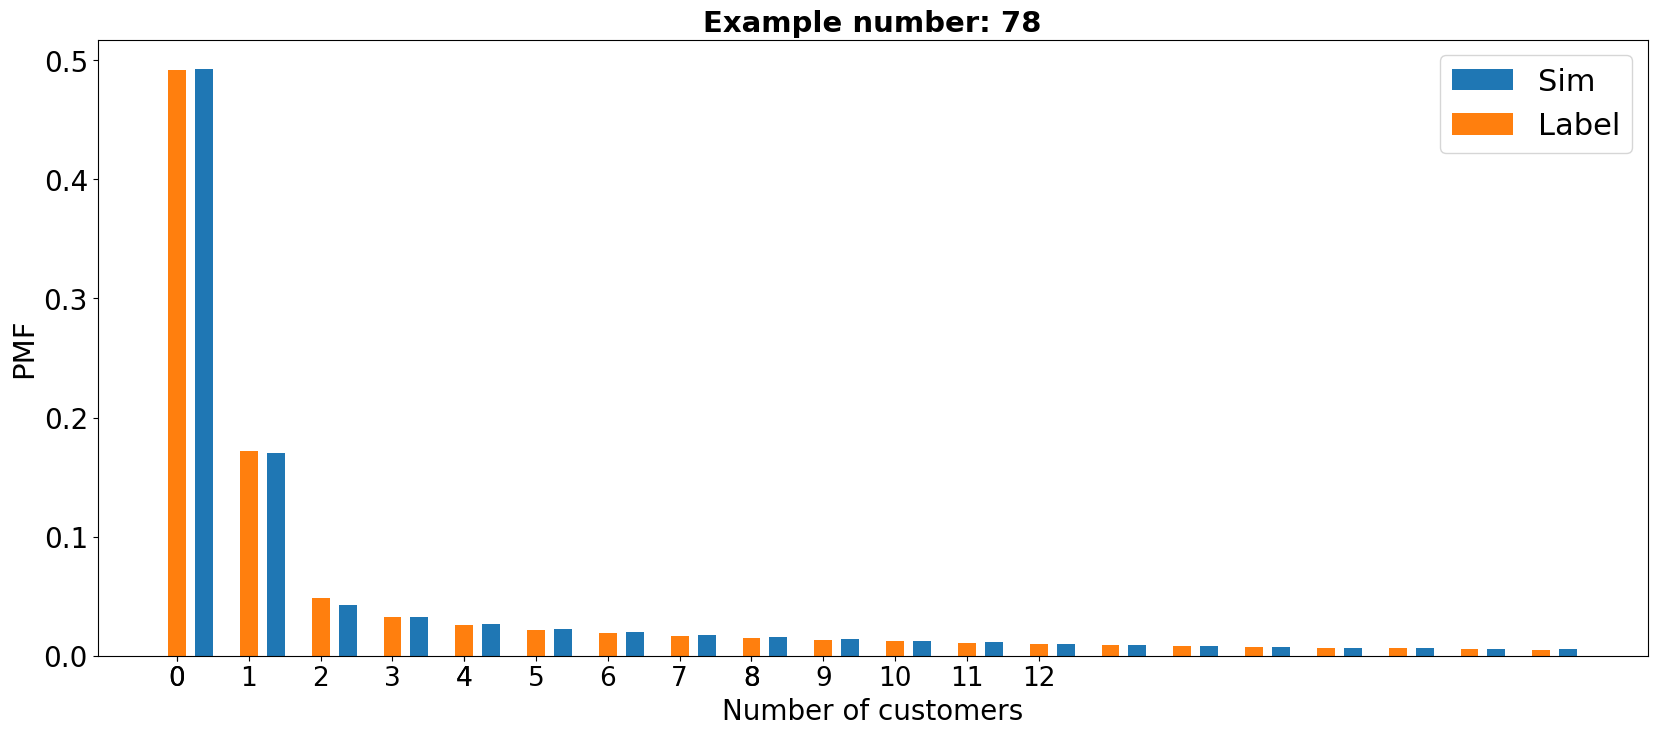

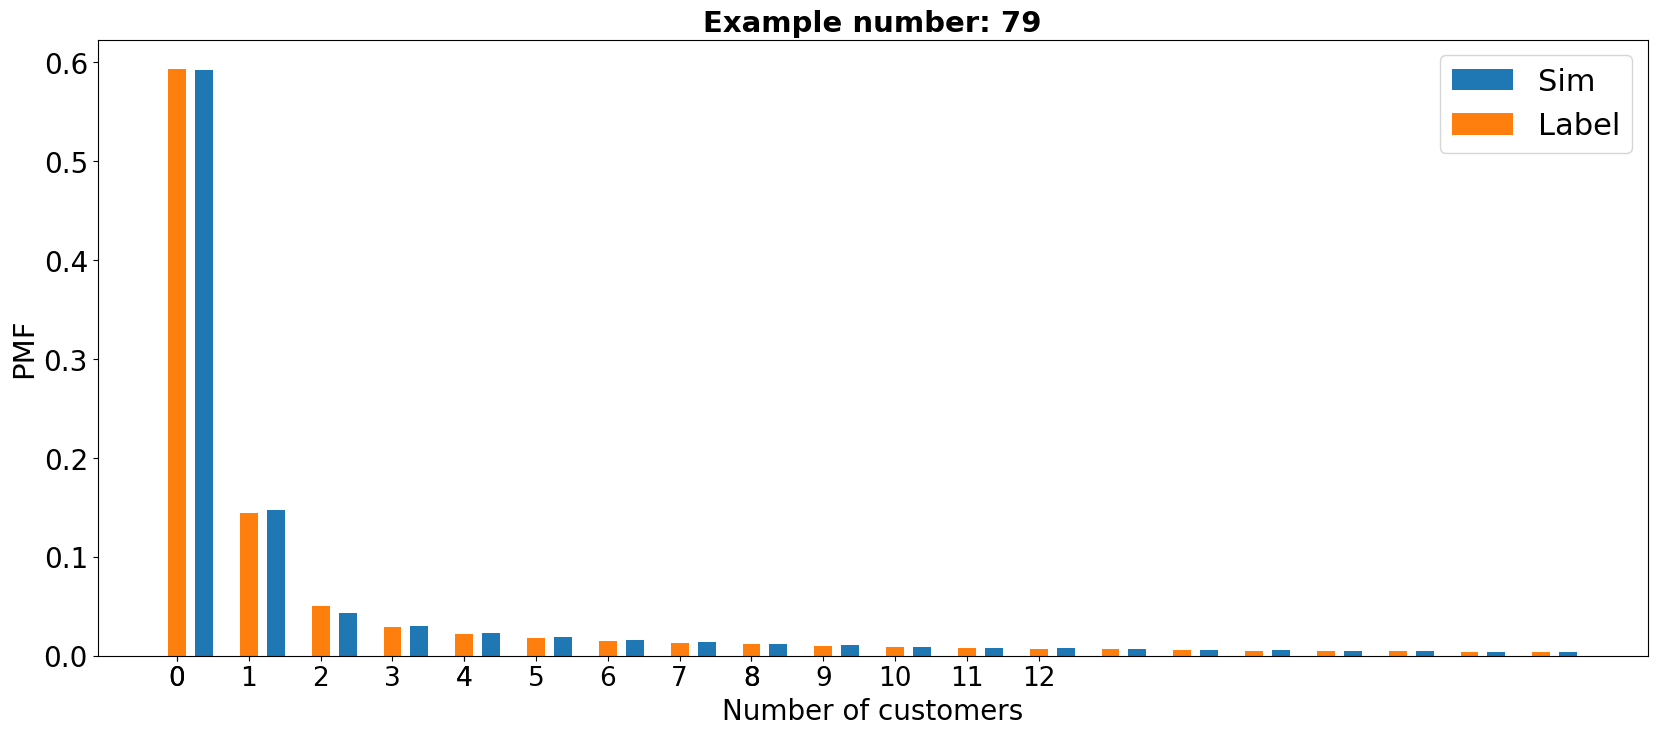

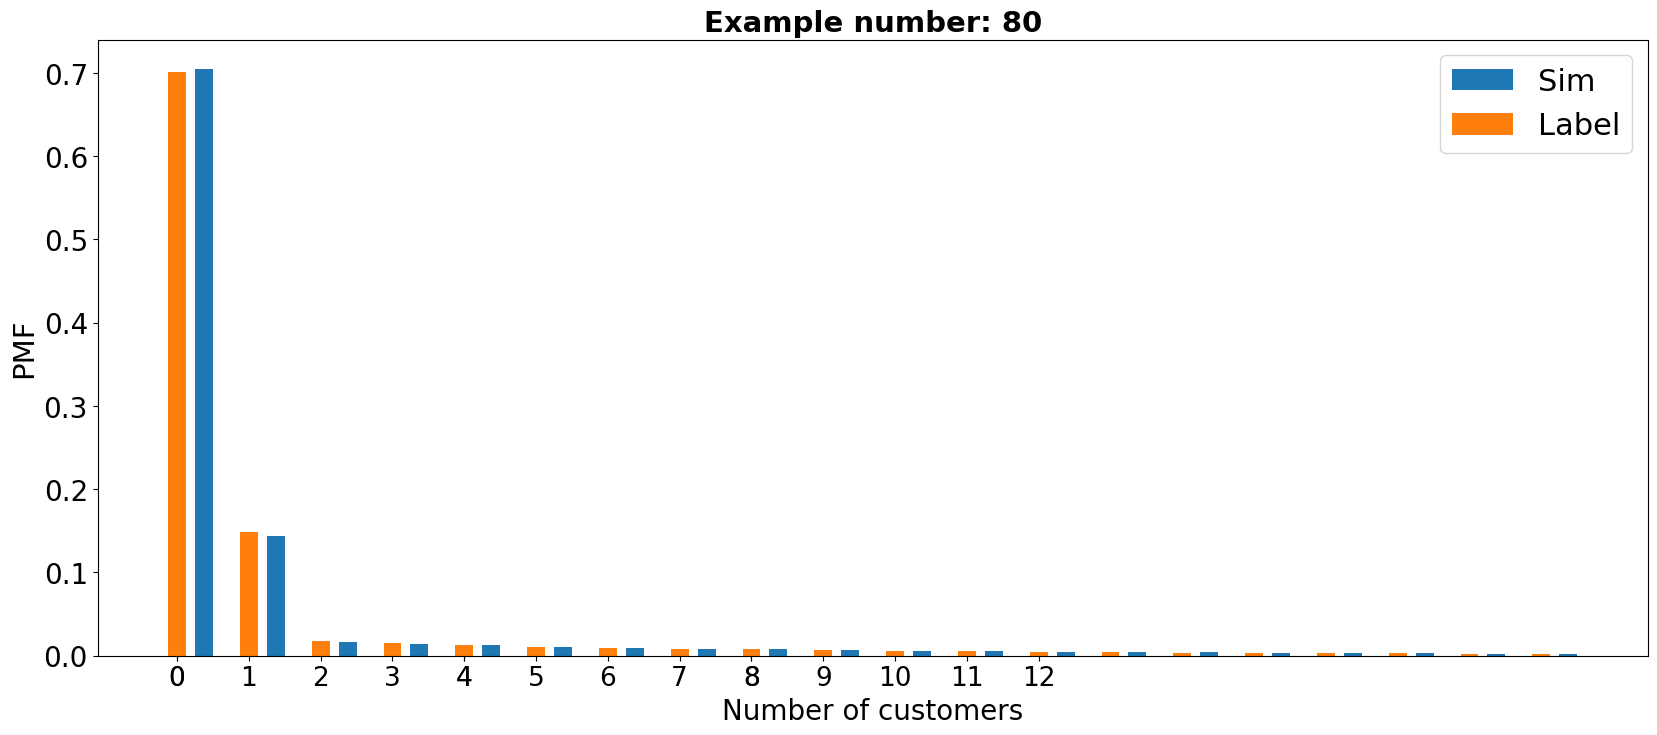

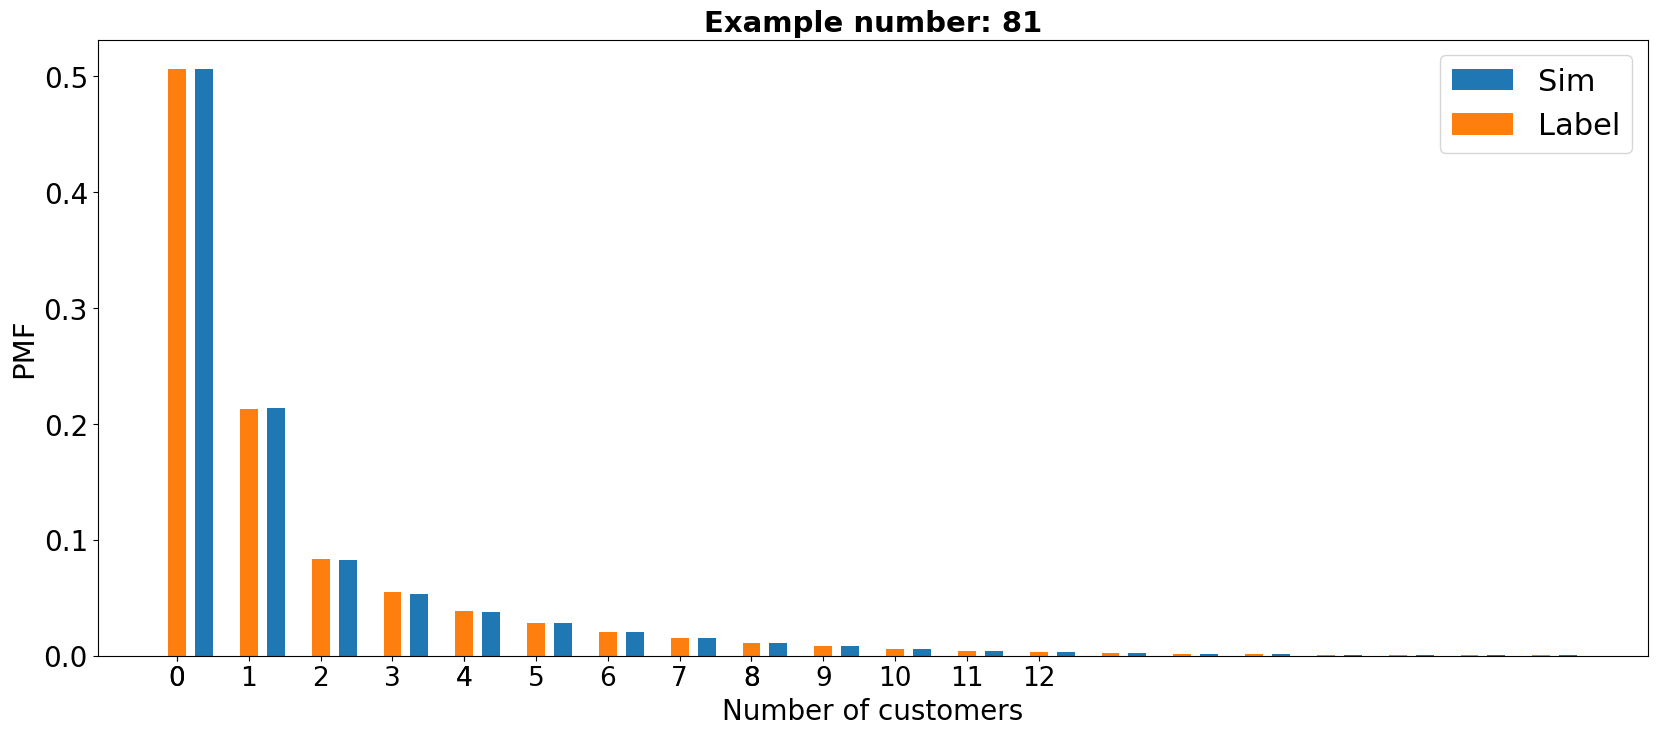

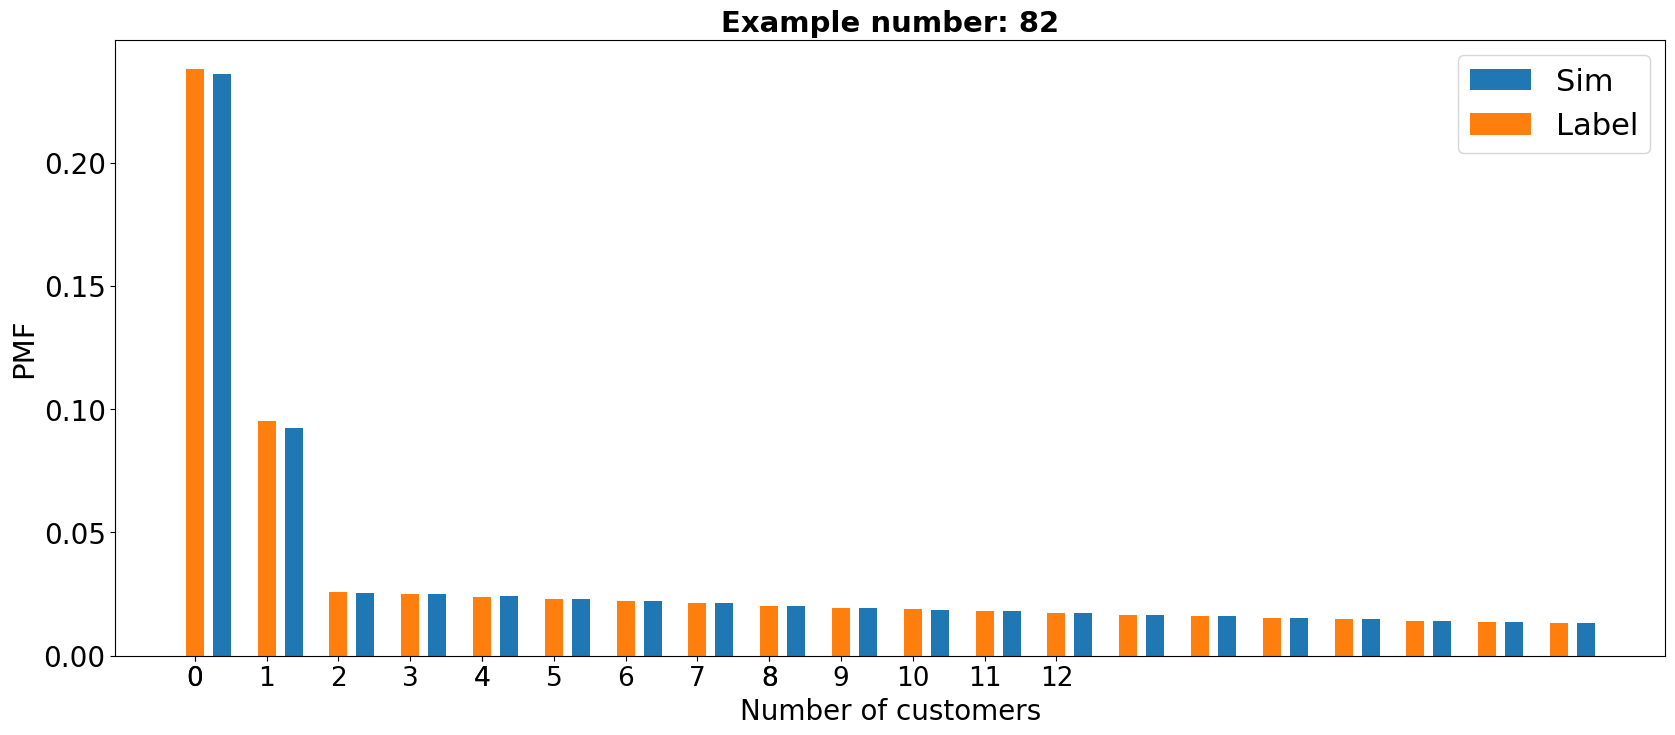

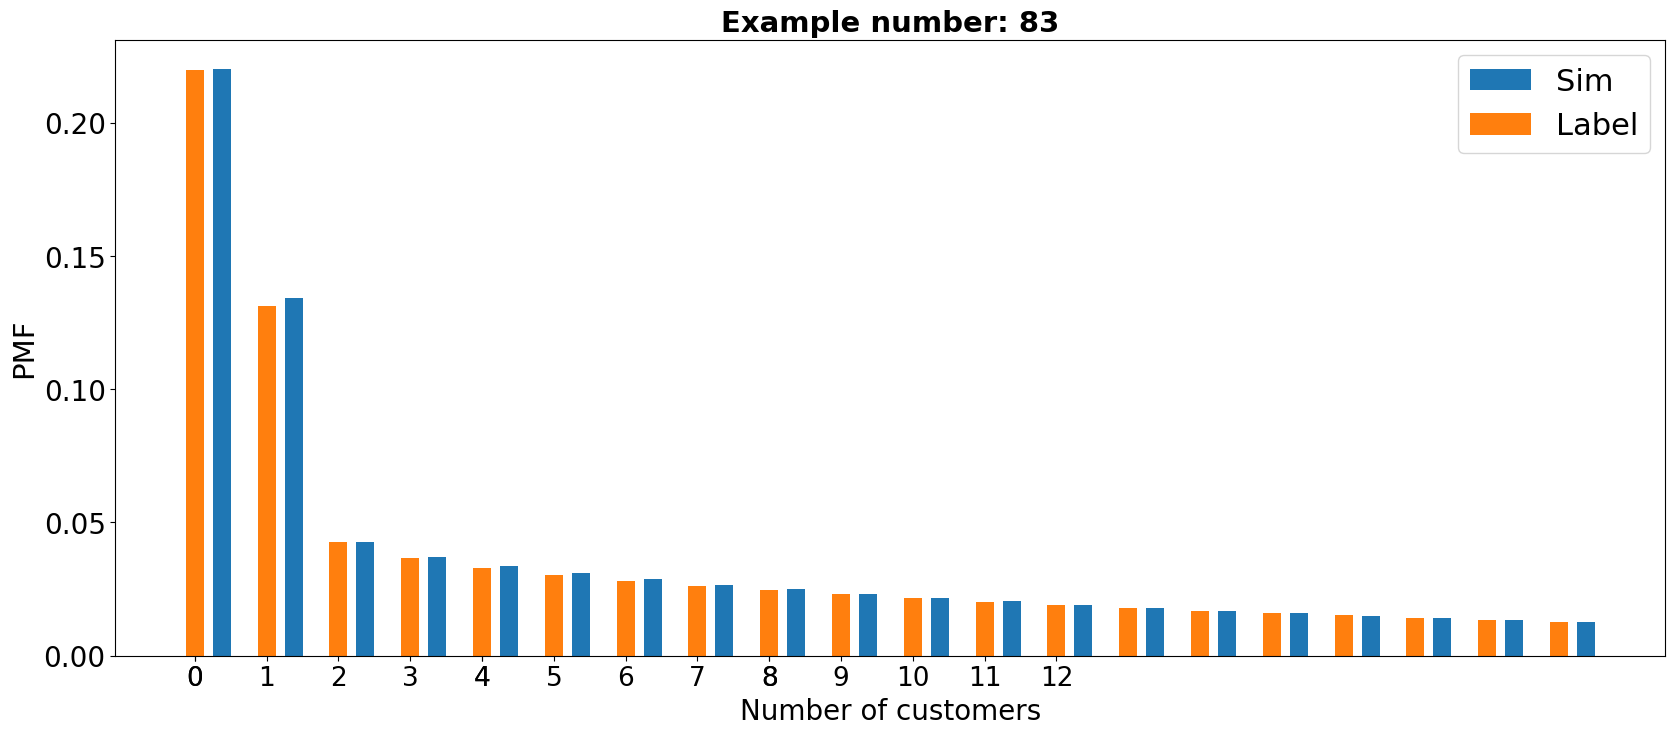

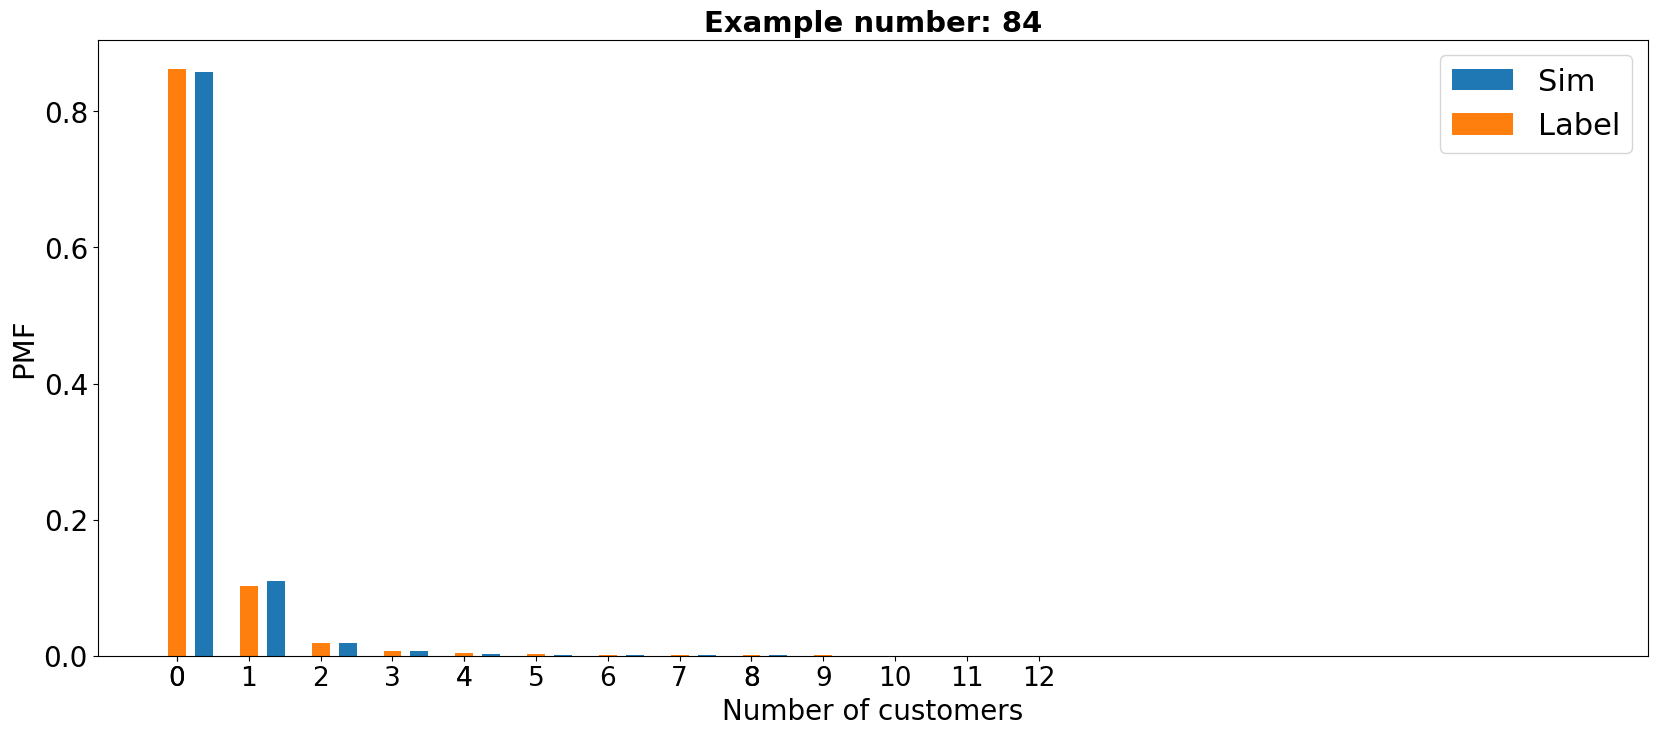

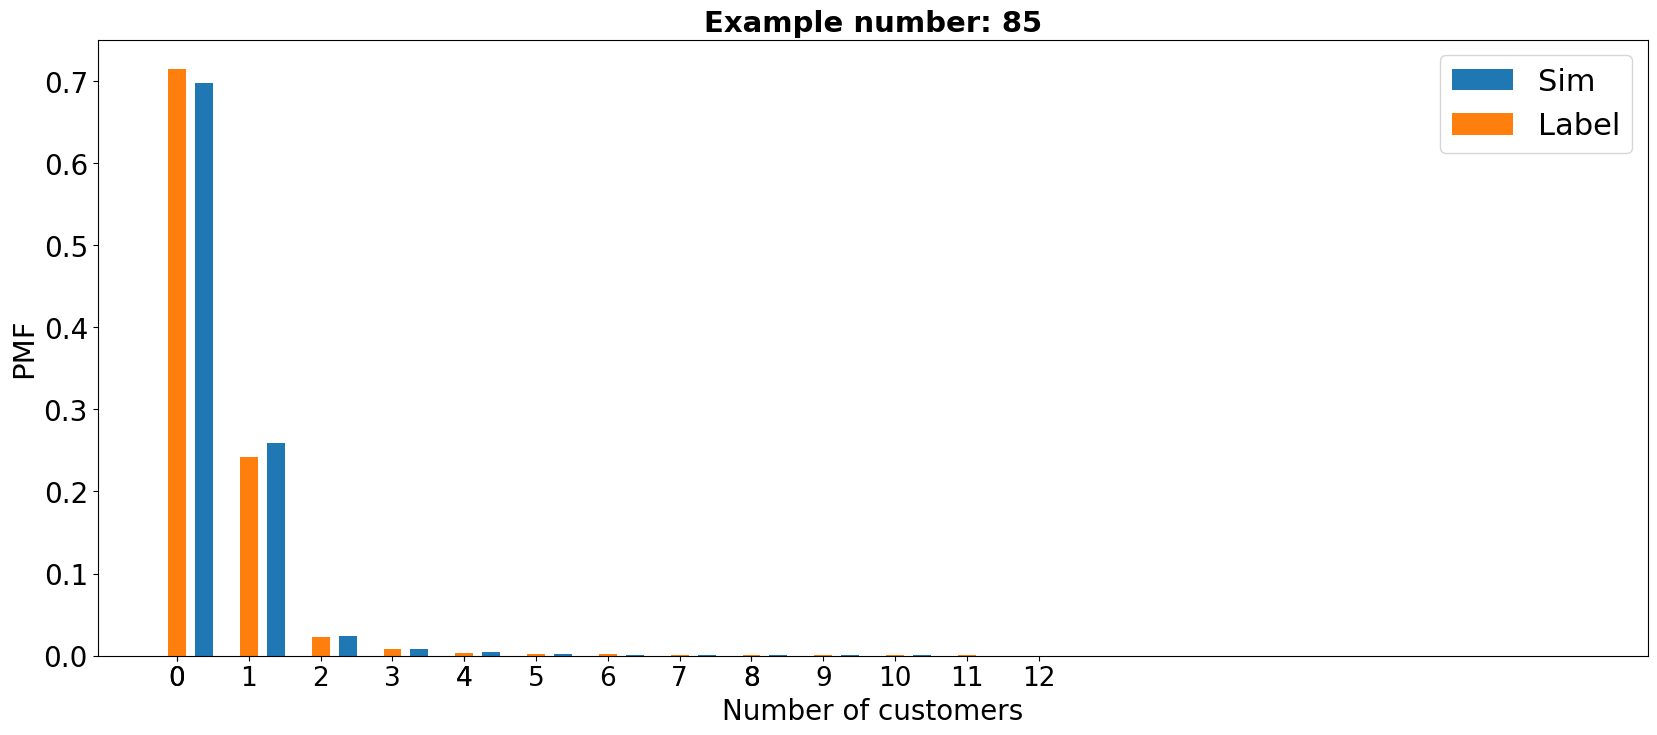

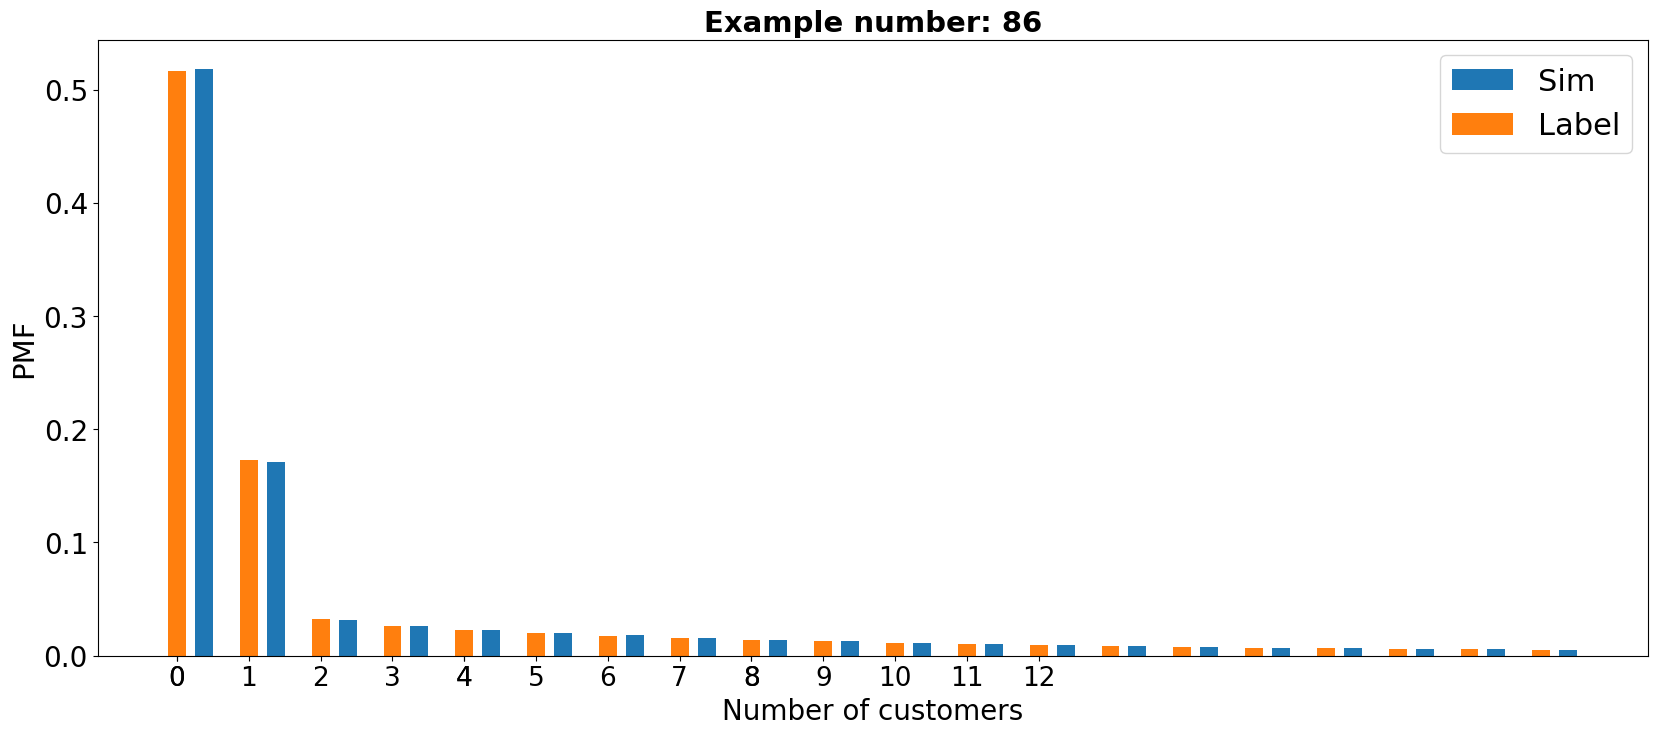

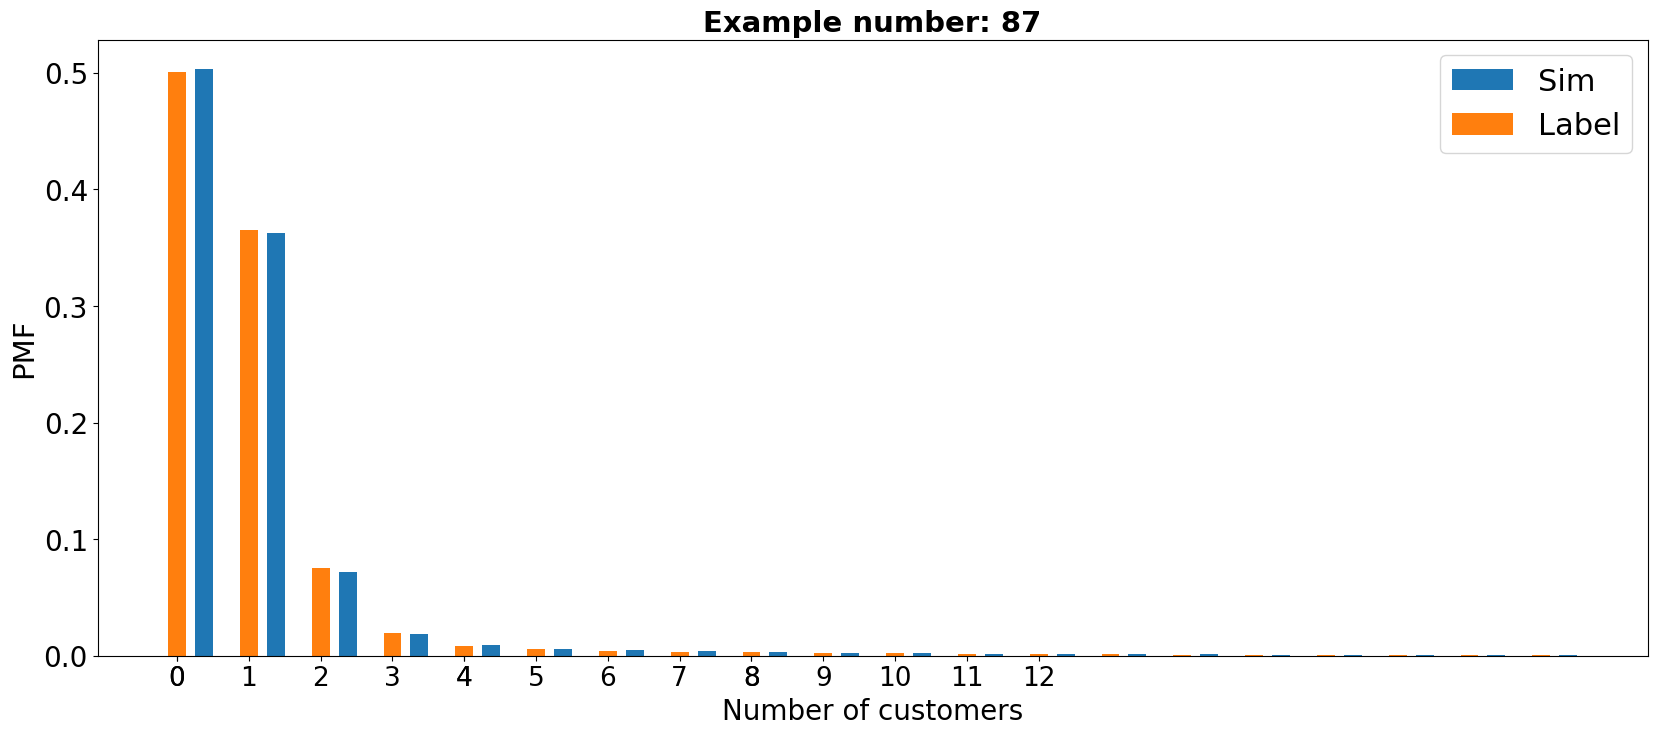

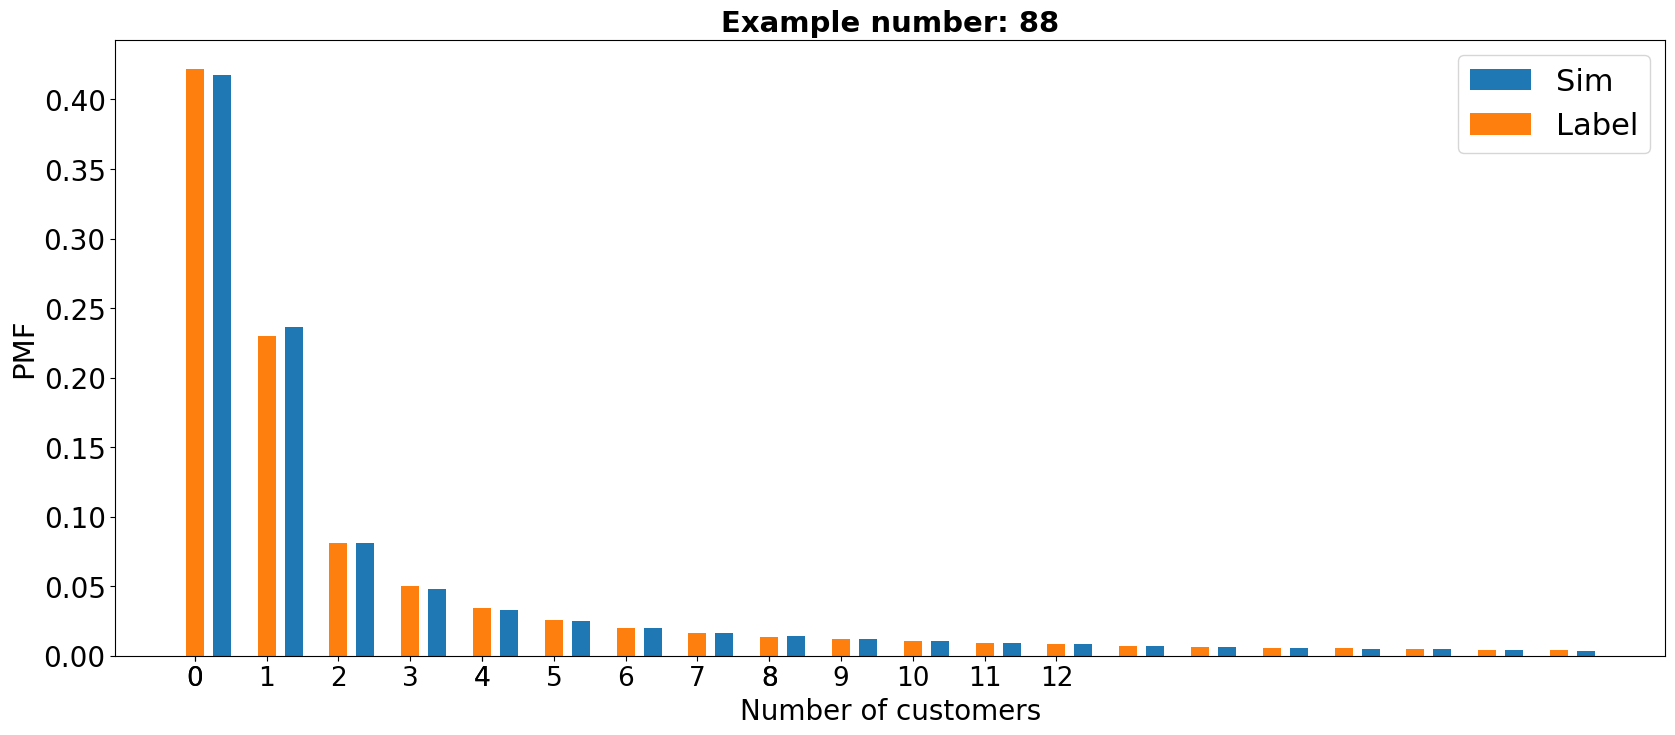

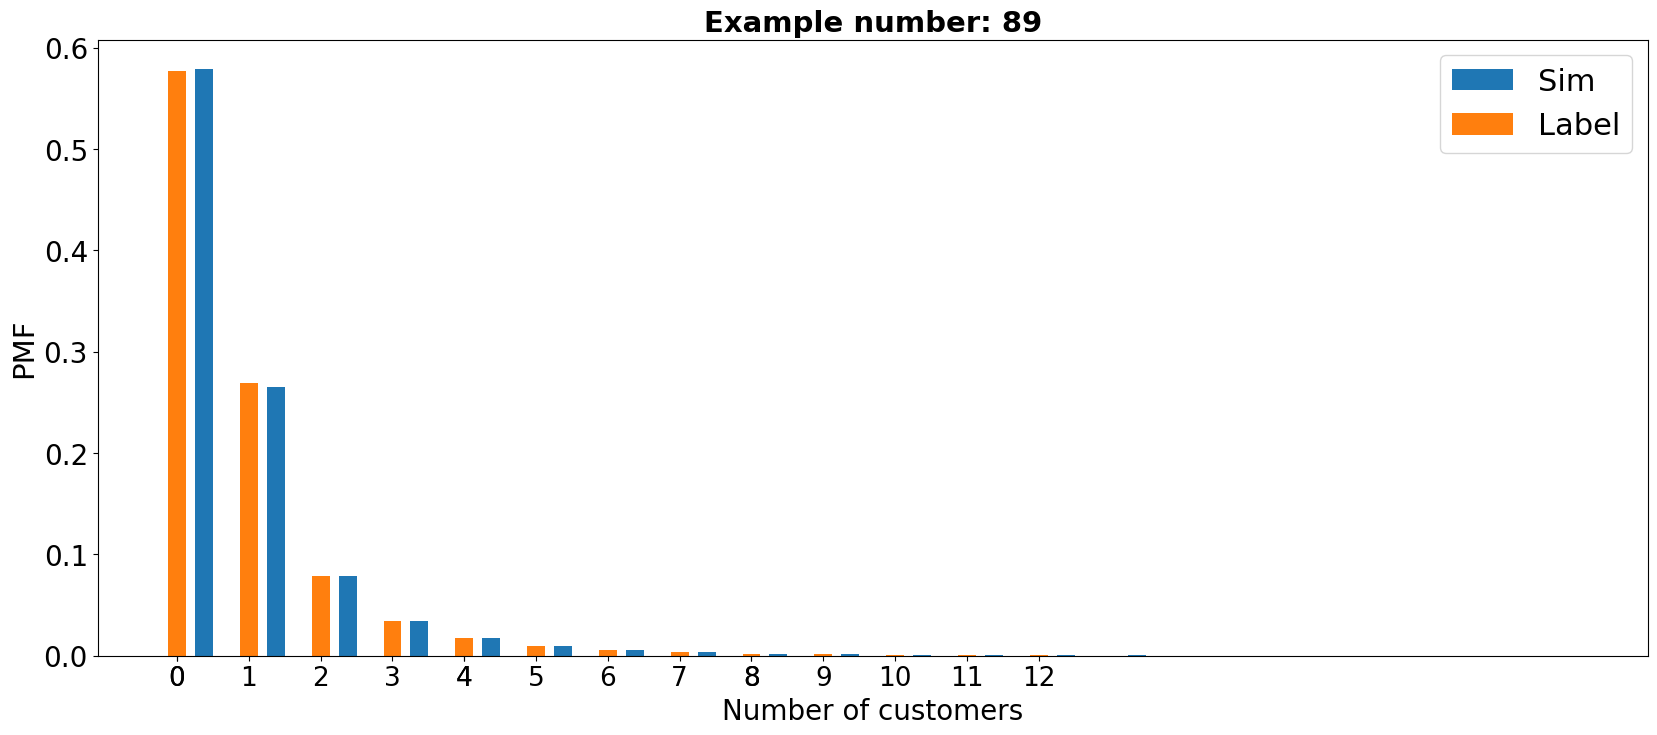

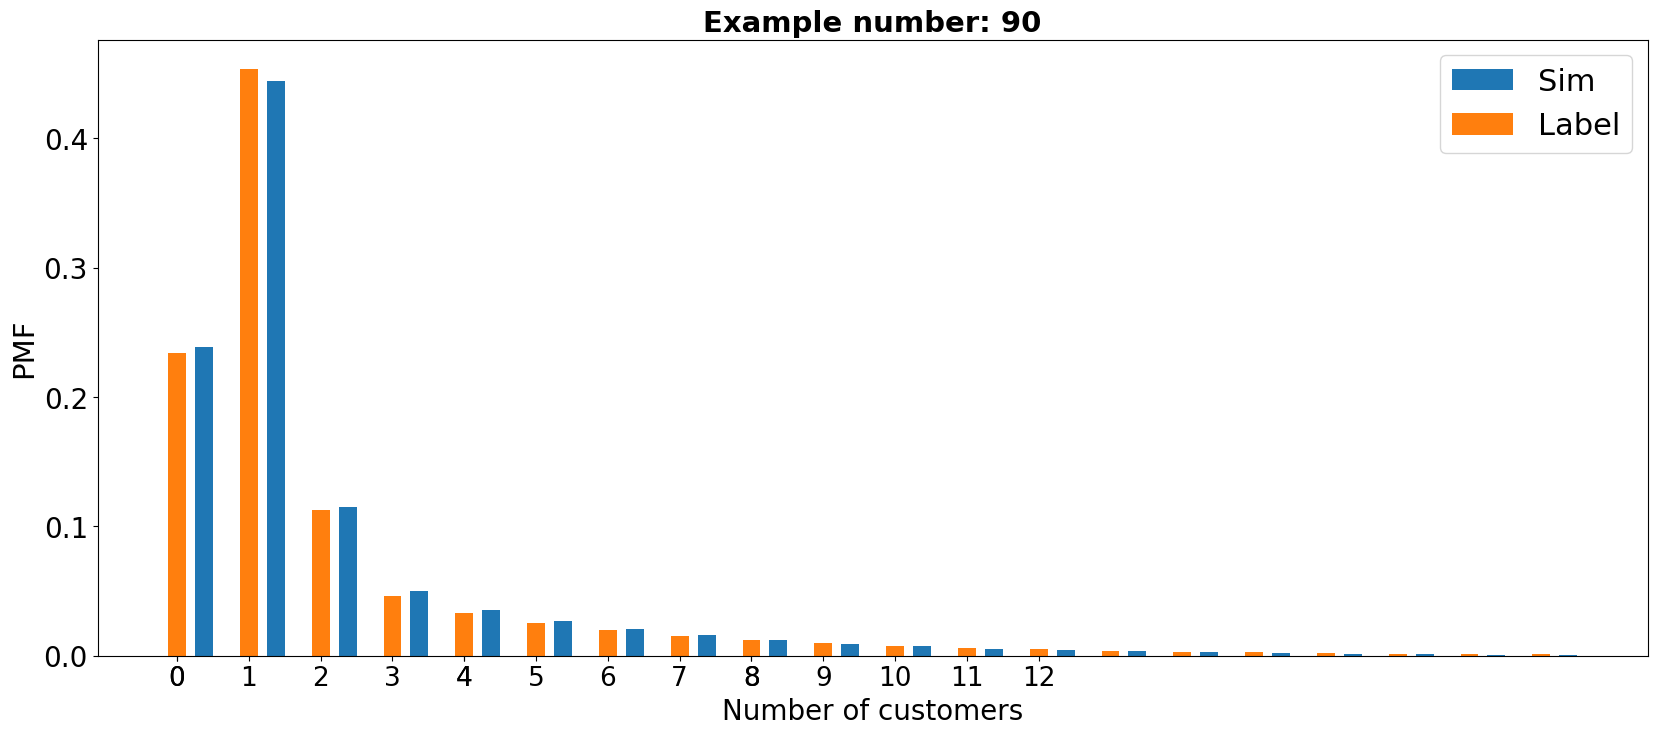

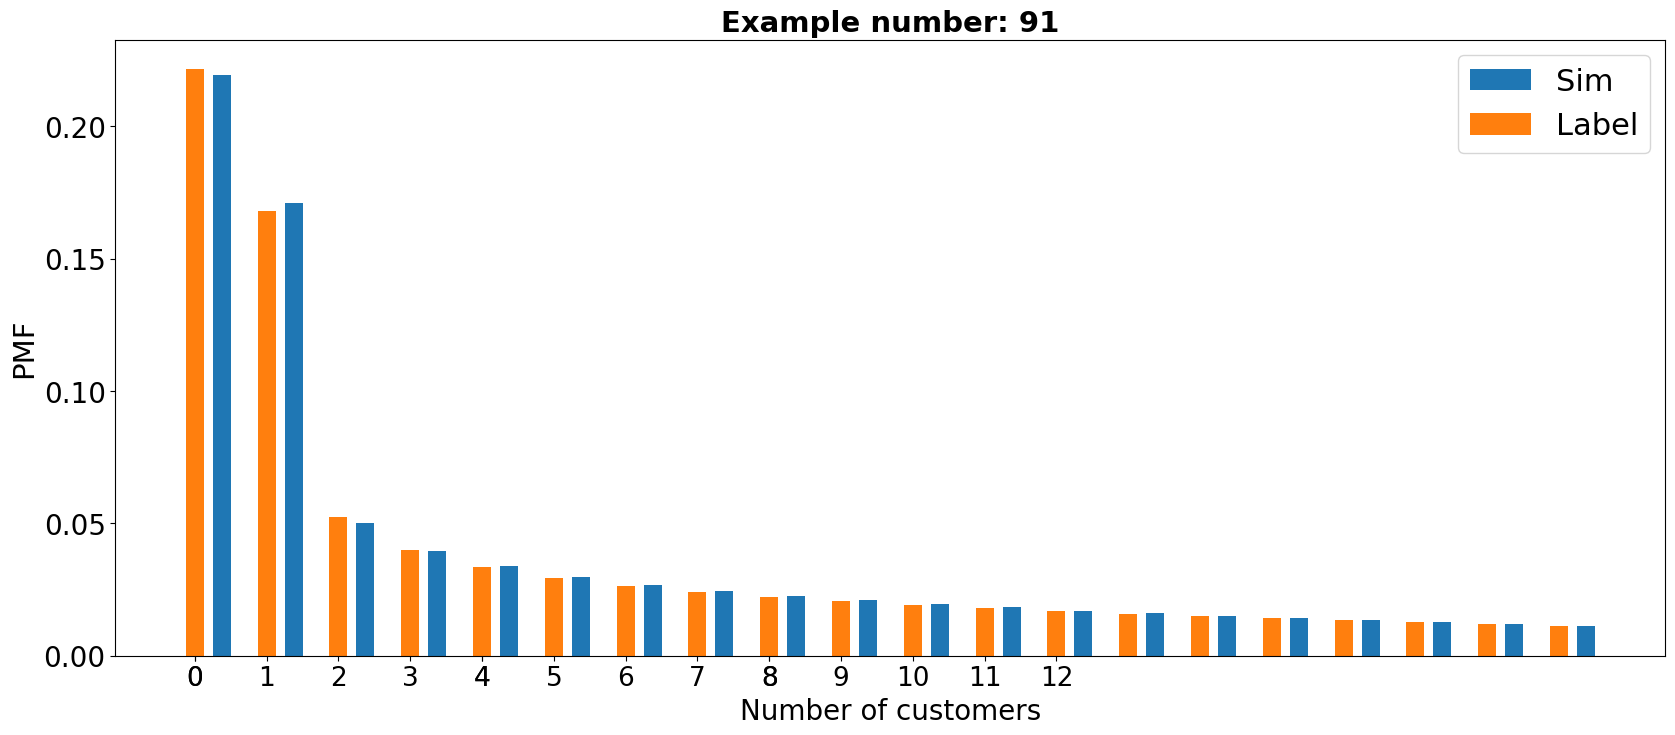

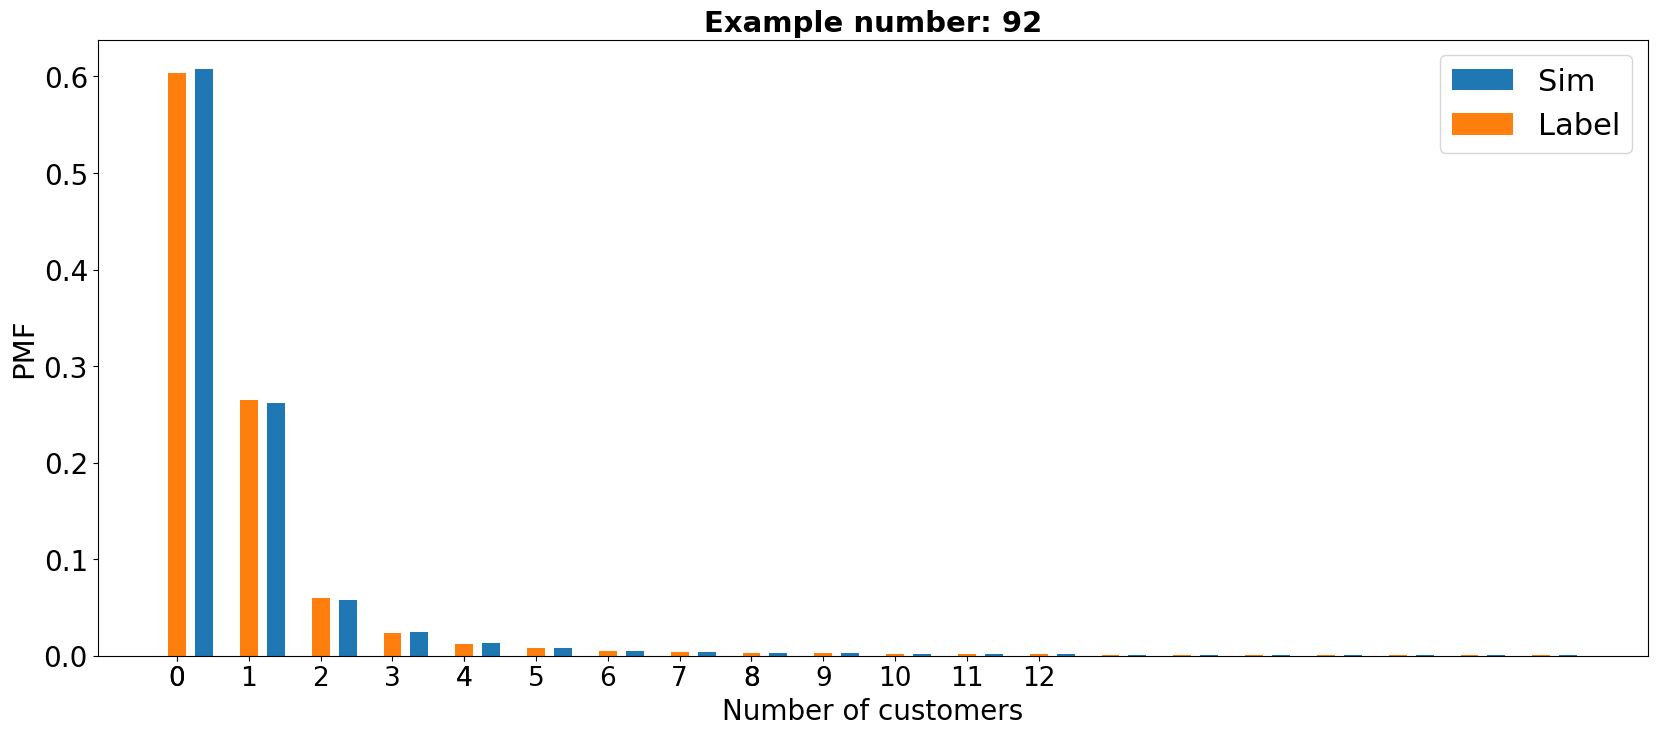

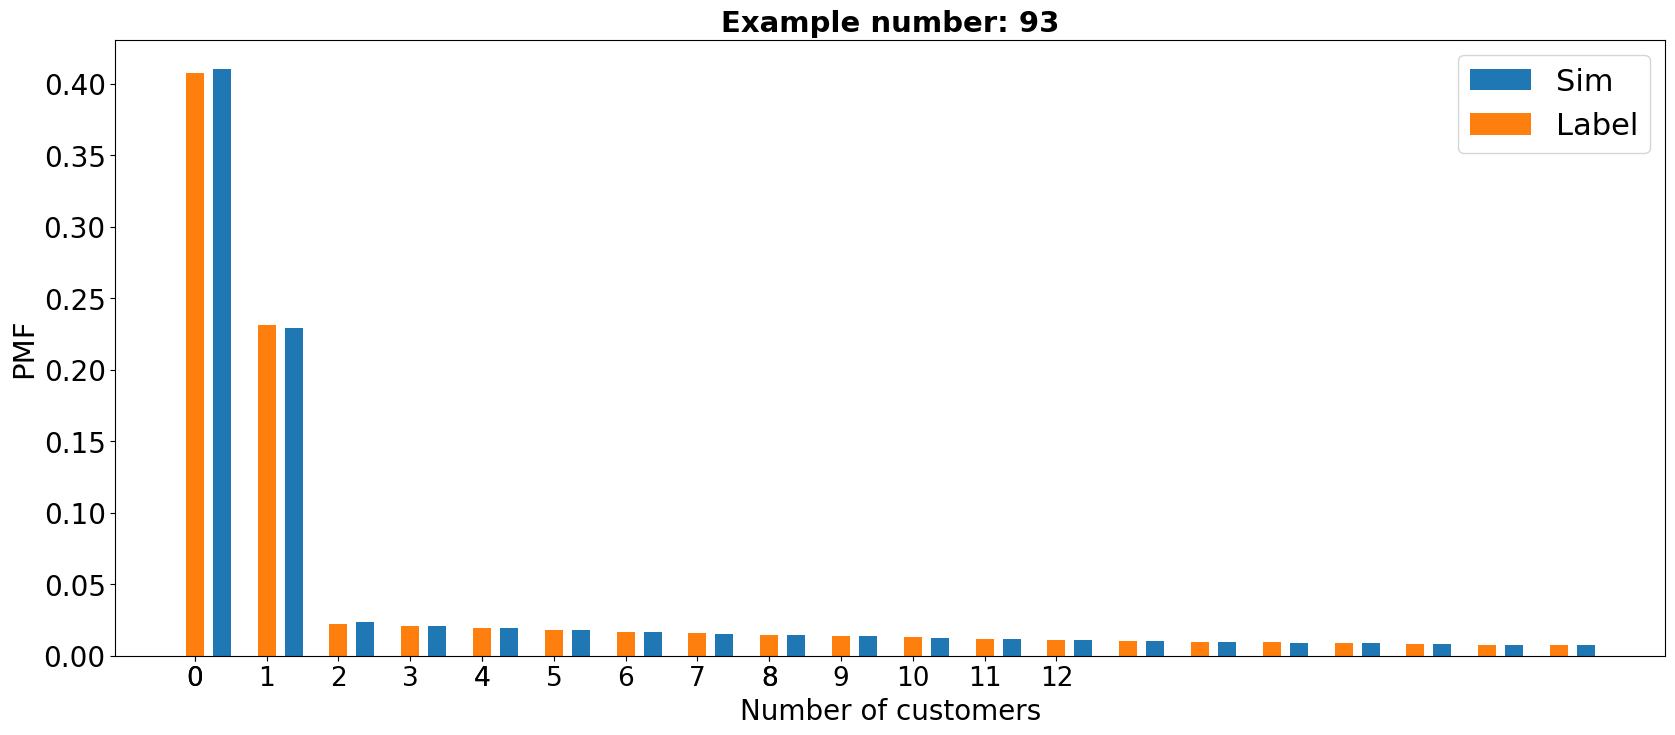

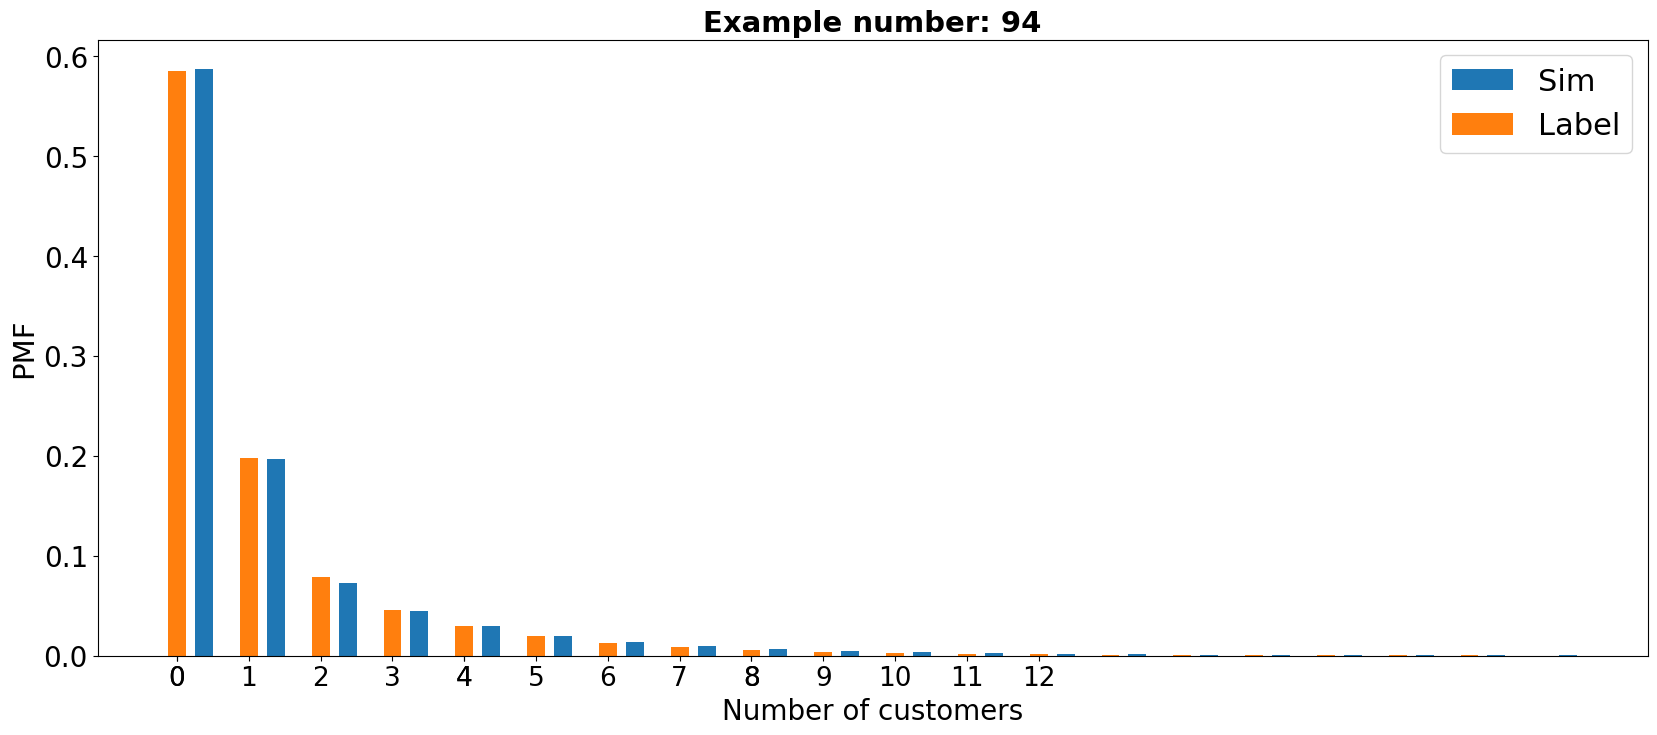

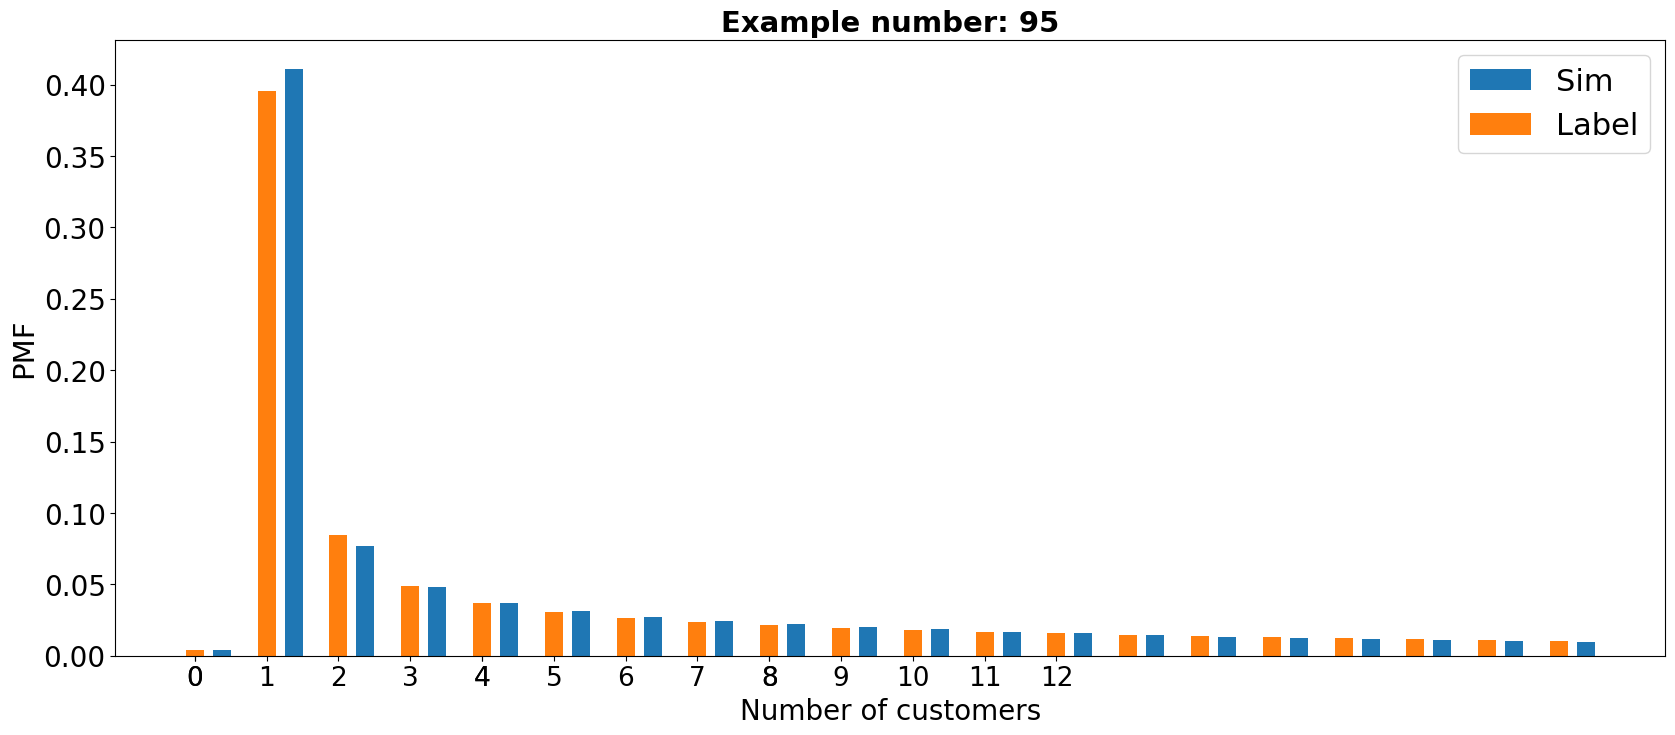

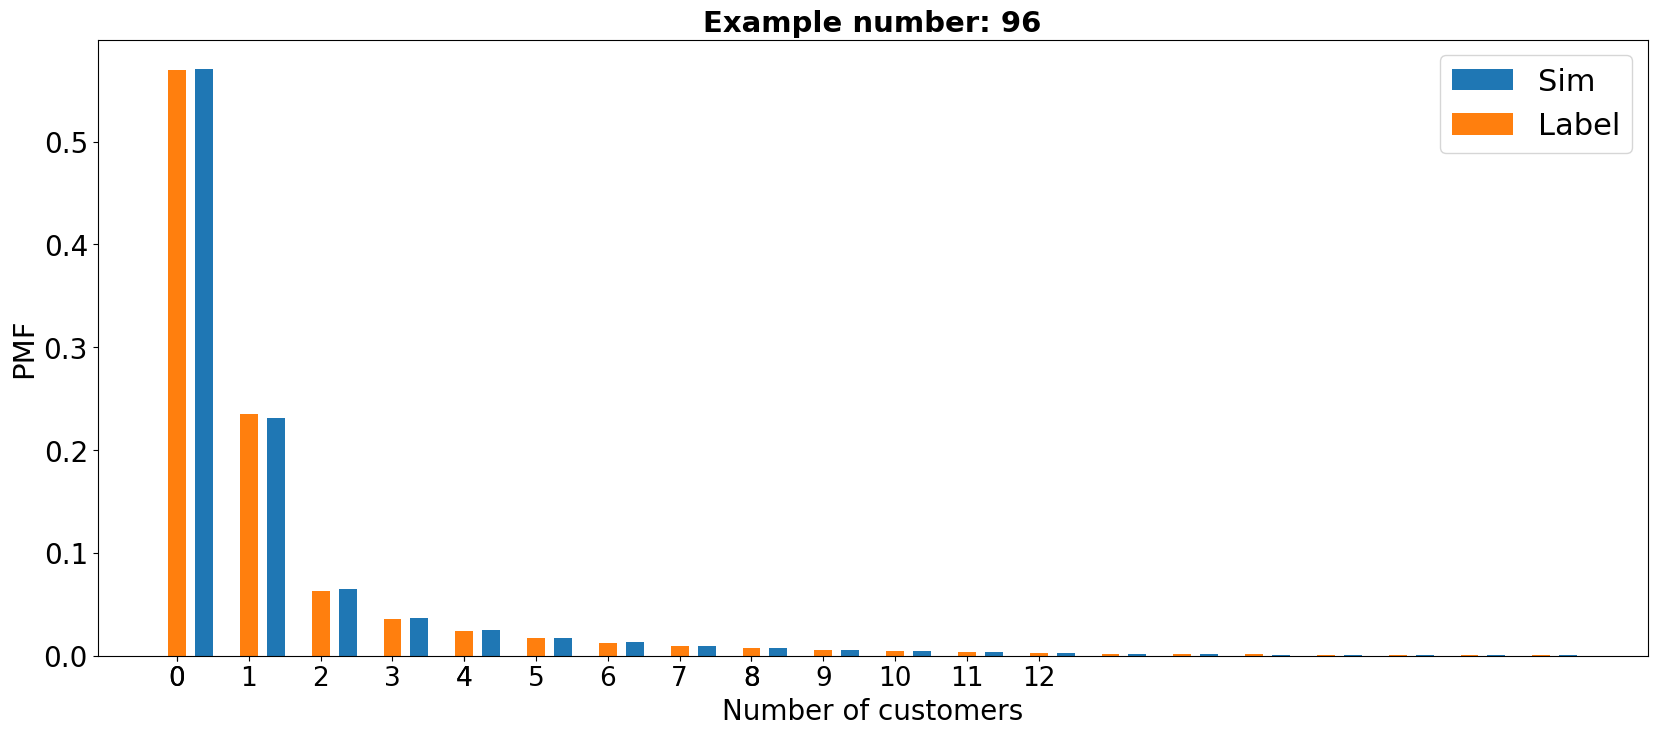

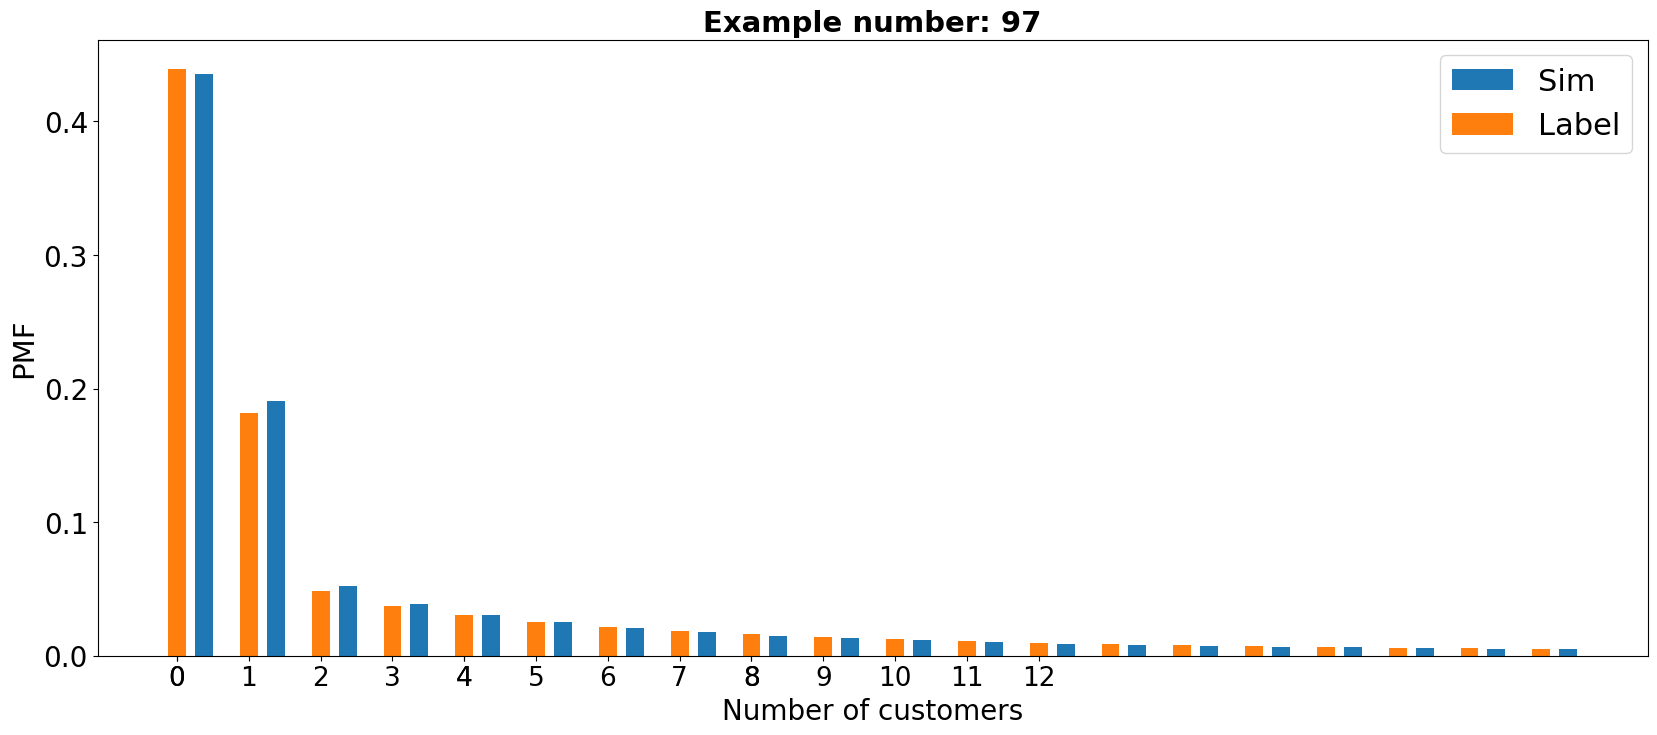

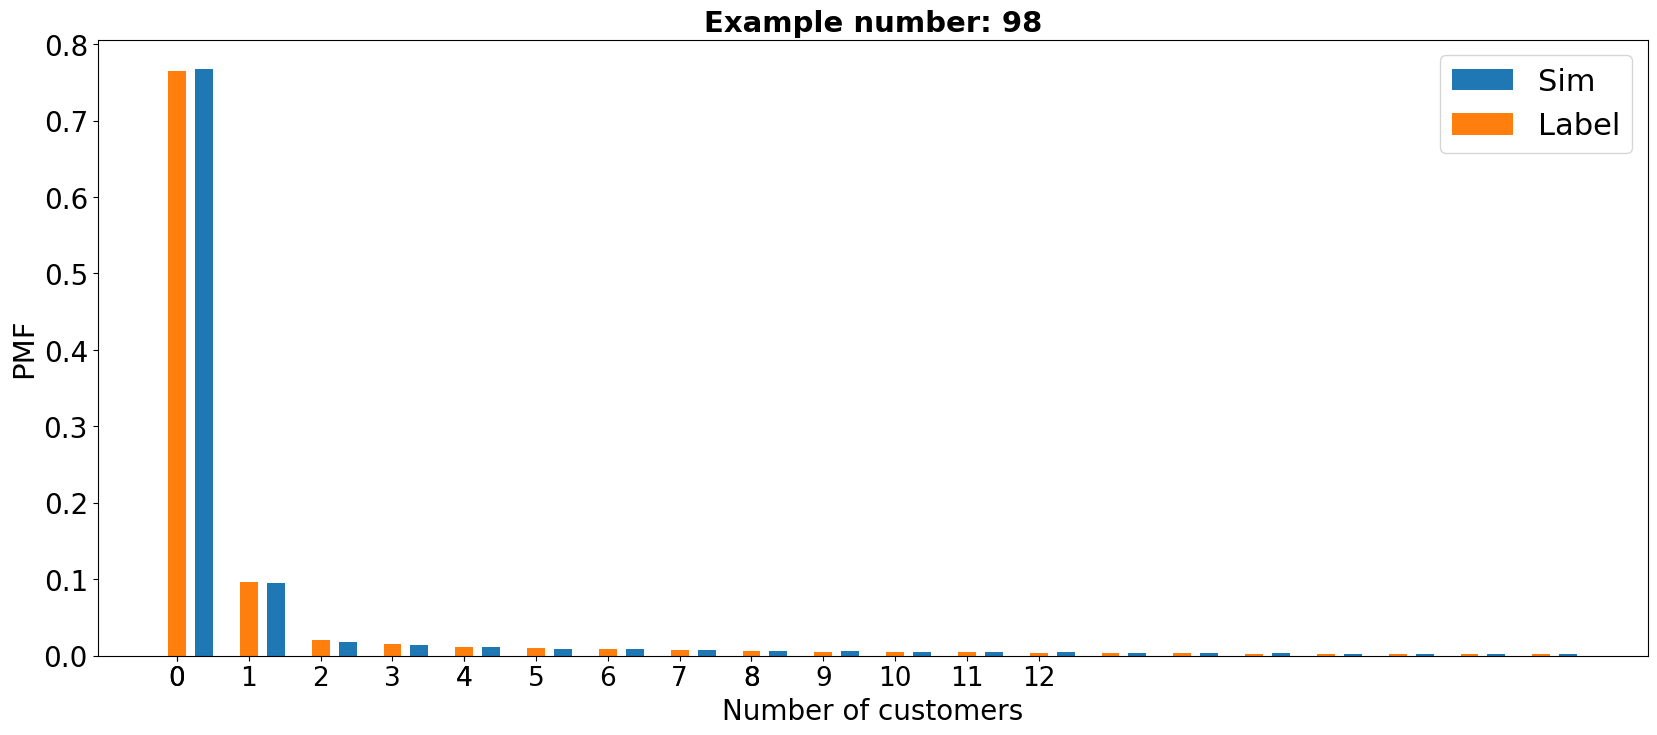

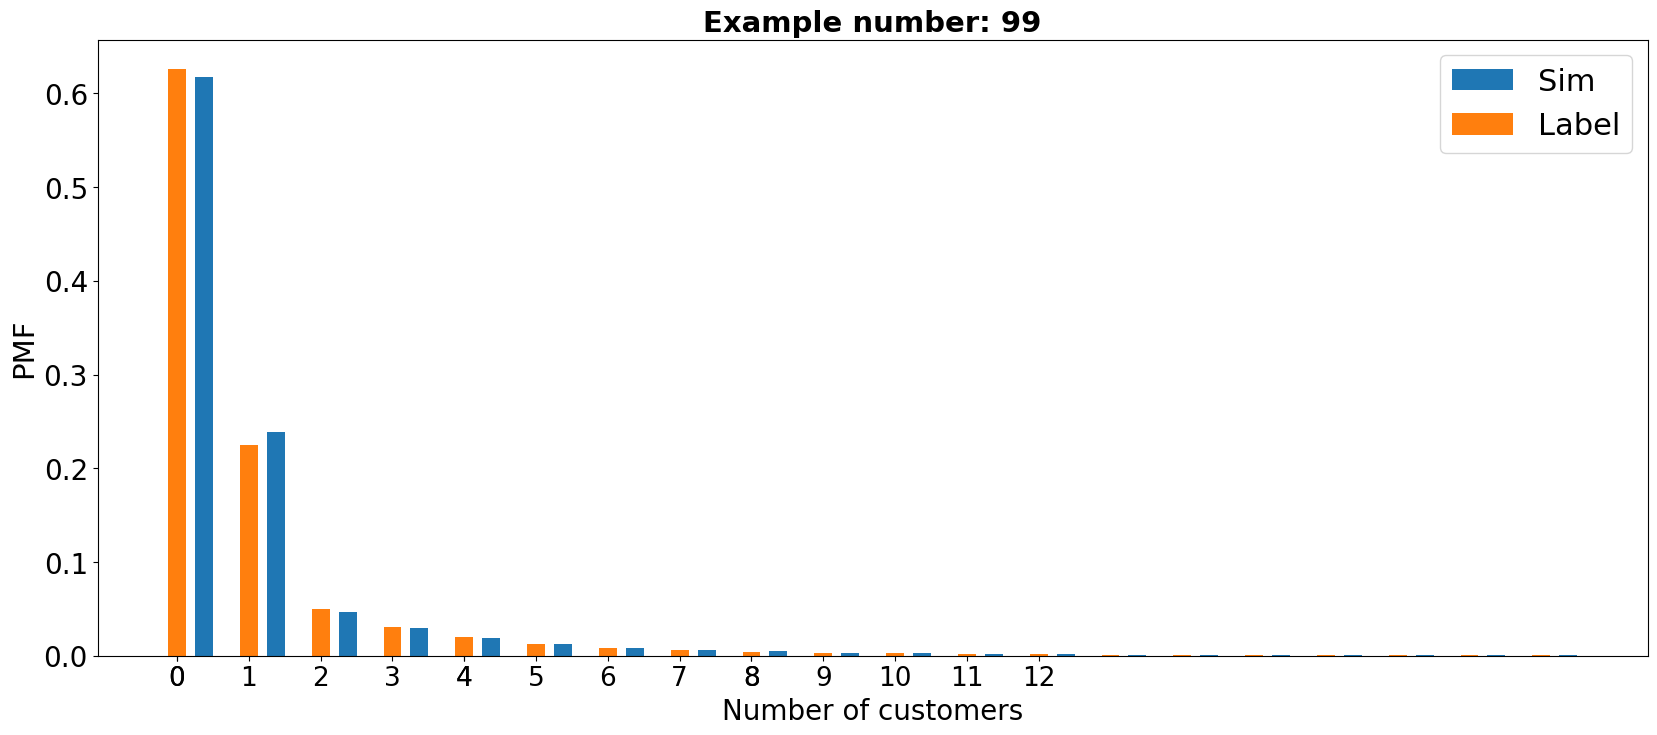

In [31]:
for ind in range(100):

    with torch.no_grad():
    
        fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8))
        width = 0.25
        max_probs = 20
        rects1 = ax1.bar(1.5*width+np.arange(max_probs), output[ind,:max_probs].cpu(), width, label='Sim')
        rects2 = ax1.bar(np.arange(max_probs) , labels[ind,:max_probs].cpu(), width, label='Label')
        plt.rcParams['font.size'] = '20'
    
        # # Add some text for labels, title and custom x-axis tick labels, etc.
        ax1.set_ylabel('PMF', fontsize=21)
        ax1.set_xlabel('Number of customers', fontsize=20)
        ax1.set_title( 'Example number: '+str(ind) , fontsize=21, fontweight="bold")
        ax1.set_xticks(np.linspace(0,12,16).astype(int))
        ax1.set_xticklabels(np.linspace(0,12,16).astype(int), fontsize=19)
        ax1.legend(fontsize=22)
        plt.show()